In [17]:
import json
import os

from analysis import *
from plot_main import *
from choice_analysis import *
import seaborn as sns
import scipy.stats as stats

plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams.update({'font.size': 20})
plt.rcParams['image.interpolation']='nearest'


from models import HierarchicalRNN
from task import MDPRL

# %load_ext autoreload
# %autoreload 0

### Load model and run simulation on experimental reward schedule and stimuli

In [18]:
# exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/exp/no_rwd_input_large_rate_reg_good_0/'
exp_dir = '/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/exp/'
plot_save_dir = 'no_rwd_input_large_rate_reg'
os.chdir('/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN')

model_array_dir = [
    'no_rwd_input_large_rate_reg_good_0',
    'no_rwd_input_large_rate_reg_2',
    'no_rwd_input_large_rate_reg_3',
    'no_rwd_input_large_rate_reg_4',
    'no_rwd_input_large_rate_reg_5',
    'no_rwd_input_large_rate_reg_6',
    'no_rwd_input_large_rate_reg_7',
    'no_rwd_input_large_rate_reg_8',
    'no_rwd_input_large_rate_reg_9',
]


# os.chdir('/Volumes/f005d7d/attn-rnn/Attn-WM-RNN')
# exp_dir = 'exp/dual_hierarchical_good_based_2_area_no_choice_to_area_1'

f = open(os.path.join(exp_dir, model_array_dir[0], 'args.json'), 'r')
args = json.load(f)
print('loaded args')
# load model
ITI = 0.2
choice_start = 0.6
rwd_start = 0.85
stim_end = 0.95
mask_onset = 0.4
# experiment timeline [0.75 fixation, 2.5 stimulus, 0.5 action presentation, 1.0 reward presentation]
# 2021 paper          [0.5          , 0.7         , 0.3                    , 0.2                   ]
# here                [0.2          , 0.6         , 0.15                   , 0.15                  ]

exp_times = {
    'start_time': -ITI,
    'end_time': stim_end,
    'stim_onset': 0.0,
    'stim_end': stim_end,
    'mask_onset': mask_onset,
    'mask_end': choice_start,
    'choice_onset': choice_start,
    'choice_end': stim_end,
    'rwd_onset': rwd_start,
    'rwd_end': stim_end,
    'total_time': ITI+stim_end,
    'dt': args['dt']}
log_interval = 1

task_mdprl = MDPRL(exp_times, args['input_type'])

input_size = {
    'feat': args['stim_dim']*args['stim_val'],
    'feat+obj': args['stim_dim']*args['stim_val']+args['stim_val']**args['stim_dim'], 
    'feat+conj+obj': args['stim_dim']*args['stim_val']+args['stim_dim']*args['stim_val']*args['stim_val']+args['stim_val']**args['stim_dim'],
}[args['input_type']]

args['num_options'] = 2 if 'double' in args['task_type'] else 1

num_options = 1 if args['task_type']=='value' else 2
if args['decision_space']=='action':
    output_size = num_options
elif args['decision_space']=='good':
    output_size = args['stim_val']**args['stim_dim']
else:
    raise ValueError('Invalid decision space')
args['output_size'] = output_size


model_specs = {'input_size': input_size, 'hidden_size': args['hidden_size'], 'output_size': output_size, 'num_options': num_options,
                'plastic': args['plas_type']=='all', 'activation': args['activ_func'],
                'dt': args['dt'], 'tau_x': args['tau_x'], 'tau_w': args['tau_w'], 
                'e_prop': args['e_prop'], 'init_spectral': args['init_spectral'], 'balance_ei': args['balance_ei'],
                'sigma_rec': args['sigma_rec'], 'sigma_in': args['sigma_in'], 'sigma_w': args['sigma_w'], 
                'rwd_input': args.get('rwd_input', False), 'action_input': args['action_input'], 
                'sep_lr': args['sep_lr'], 'num_choices': 2 if 'double' in args['task_type'] else 1,
                'structured_conn': args['structured_conn'], 'num_areas': args['num_areas'],
                'inter_regional_sparsity': (1, 1), 'inter_regional_gain': (1, 1)}

E_SIZE = round(args['hidden_size']*args['e_prop'])
I_SIZE = round(args['hidden_size']*(1-args['e_prop']))
NUM_AREAS = args['num_areas']


all_models = []

for model_dir in model_array_dir:
    model = HierarchicalRNN(**model_specs)
#     print(model)
#     for n, p in model.named_parameters():
#         print(n, p.numel())
    state_dict = torch.load(os.path.join(exp_dir, model_dir, 'checkpoint.pth.tar'), 
                            map_location=torch.device('cpu'))['model_state_dict']
    print(model.load_state_dict(state_dict))
    all_models.append(model)
    print(f'model at {model_dir} loaded successfully')
    
    

loaded args
<All keys matched successfully>
model at no_rwd_input_large_rate_reg_good_0 loaded successfully
<All keys matched successfully>
model at no_rwd_input_large_rate_reg_2 loaded successfully
<All keys matched successfully>
model at no_rwd_input_large_rate_reg_3 loaded successfully
<All keys matched successfully>
model at no_rwd_input_large_rate_reg_4 loaded successfully
<All keys matched successfully>
model at no_rwd_input_large_rate_reg_5 loaded successfully
<All keys matched successfully>
model at no_rwd_input_large_rate_reg_6 loaded successfully
<All keys matched successfully>
model at no_rwd_input_large_rate_reg_7 loaded successfully
<All keys matched successfully>
model at no_rwd_input_large_rate_reg_8 loaded successfully
<All keys matched successfully>
model at no_rwd_input_large_rate_reg_9 loaded successfully


In [19]:
def run_model(args, model_list, task_mdprl, n_samples=None):
    all_saved_states = defaultdict(list)
    output_size = args['output_size']    

    for model in model_list:
        model.eval()
        for p in model.parameters():
            p.requires_grad = False # disable gradient calculation for parameters
    if n_samples is None:
        n_samples = task_mdprl.test_stim_order.shape[1]
        
    n_models = len(model_list)
    model_assignment = np.concatenate([
        np.repeat(np.arange(n_models), n_samples//n_models),
        np.random.choice(np.arange(n_models), size=n_samples%n_models, replace=False)])
    model_assignment = np.random.permutation(model_assignment)
    
    print(np.unique(model_assignment, return_counts=True))
    
        
    for batch_idx in tqdm.tqdm(range(n_samples)):
        model = model_list[model_assignment[batch_idx]]
        # sample random order to permute reward schedule dimensions
#             curr_dim_order = all_dim_orders[np.random.choice(len(all_dim_orders))]
        pop_s, rwd_s, target_valid, output_mask, rwd_mask, ch_mask, index_s, prob_s = task_mdprl.generateinputfromexp(
            batch_size=1, test_N_s=args['test_N_s'], num_choices=args['num_options'], participant_num=batch_idx)
#             all_saved_states['dim_orders'].append(torch.from_numpy(np.expand_dims(np.array(curr_dim_order), axis=(0,1,2)))) # num trials (1) X time_steps(1) X batch_size(1) X num_dims
        # add empty list for the current episode
        all_saved_states['whs_final'].append([])

        all_saved_states['stimuli'].append(torch.from_numpy(np.expand_dims(index_s, axis=(1,2)))) # num trials X time_steps(1) X batch_size(1) X num_choices
        all_saved_states['reward_probs'].append(torch.from_numpy(np.expand_dims(prob_s, axis=(1,)))) # num_trials X time_steps(1) X batch_size X num_choices
        

        all_saved_states['choices'].append([])
        all_saved_states['foregone'].append([])
        all_saved_states['rewards'].append([])
        all_saved_states['choose_better'].append([])
        
        all_saved_states['hs_pre'].append([])
        all_saved_states['hs_post'].append([])

        all_saved_states['sensitivity'].append([])

        # reinitialize hidden layer activity
        hidden = None

        for i in range(len(pop_s['pre_choice'])):
            # first phase, give stimuli and no feedback
            output, hs, hidden, ss = model(pop_s['pre_choice'][i], hidden=hidden, 
                                            DAs=torch.zeros(1, args['batch_size'], 1)*rwd_mask['pre_choice'],
                                            Rs=torch.zeros(1, args['batch_size'], 2)*rwd_mask['pre_choice'],
                                            acts=torch.zeros(1, args['batch_size'], output_size)*ch_mask['pre_choice'],
                                            save_weights=True)

            # save activities before reward
            all_saved_states['hs_pre'][-1].append(hs.detach()) # [num_sessions, [num_trials, [time_pre, num_batch_size, hidden_size]]]

            if args['task_type']=='on_policy_double':
                # use output to calculate action, reward, and record loss function
                if args['decision_space']=='action':
                    action = torch.argmax(output[-1,:,:], -1) # batch size
                    rwd = (torch.rand(args['batch_size'])<prob_s[i][range(args['batch_size']), action]).float()
                    all_saved_states['choose_better'][-1].append((action==torch.argmax(prob_s[i], -1)).float().squeeze())
                elif args['decision_space']=='good':
                    # action_valid = torch.argmax(output[-1,:,index_s[i]], -1) # the object that can be chosen (0~1), (batch size, )
                    action_valid = torch.multinomial(output[-1,:,index_s[i]].softmax(-1), num_samples=1).squeeze(-1)
                    # backpropagate from choice to previous reward
                    if i>0:
#                         grad_logit_rwd = torch.empty(args['output_size'])
#                         for out_idx in range(args['output_size']):
#                             output_mask = torch.zeros(args['output_size'])
#                             output_mask[out_idx] = 1
#                             output[-1,:,:].sum(0).backward(gradient=output_mask, 
#                                                            retain_graph=True if out_idx<args['output_size']-1\
#                                                                           else False)
#                             grad_logit_rwd[out_idx] = rwd.grad
#                             rwd.grad = None
                        (output[-1,:,index_s[i,1]]-output[-1,:,index_s[i,0]]).sum().backward()
                        all_saved_states['sensitivity'][-1].append(rwd.grad[None])
                        rwd.grad=None
                    else:
                        all_saved_states['sensitivity'][-1].append(torch.zeros(1, 1))
                    
                    action = index_s[i, action_valid] # (batch size, )
                    nonaction = index_s[i, 1-action_valid] # (batch size, )
                    # rwd = (torch.rand(args['batch_size'])<prob_s[i][range(args['batch_size']), action_valid]).long()
                    rwd = rwd_s[i][range(args['batch_size']), action_valid]
                    all_saved_states['choose_better'][-1].append((action_valid==torch.argmax(prob_s[i], -1)).float()[None,...]) 
                all_saved_states['rewards'][-1].append(rwd.float()[None,...])
                all_saved_states['choices'][-1].append(action[None,...])
                all_saved_states['foregone'][-1].append(nonaction[None,...])
            elif args['task_type'] == 'value':
                raise NotImplementedError
                rwd = (torch.rand(1)<prob_s[i]).float()
                output = output.reshape(output_mask['target'].shape[0], 1, output_size)
                acc.append(((output-target_valid['pre_choice'][i])*output_mask['target'].float().unsqueeze(-1)).pow(2).mean(0)/output_mask['target'].float().mean())
                curr_rwd.append(rwd)
            
            if args['task_type']=='on_policy_double':
                # use the action (optional) and reward as feedback
                pop_post = pop_s['post_choice'][i]
                action_enc = torch.eye(output_size)[action]
                rwd_enc = torch.eye(2)[rwd]
                action_enc = action_enc*ch_mask['post_choice']
                rwd_enc = rwd_enc*rwd_mask['post_choice']
                rwd = rwd.float().requires_grad_()
                DAs = (2*rwd-1)*rwd_mask['post_choice']
                for h_idx, h in enumerate(hidden):
                    hidden[h_idx] = hidden[h_idx].detach()
                _, hs, hidden, ss = model(pop_post, hidden=hidden, Rs=rwd_enc, acts=action_enc, DAs=DAs, save_weights=False)
            elif args['task_type'] == 'value':
                raise NotImplementedError
                pop_post = pop_s['post_choice'][i]
                rwd_enc = torch.eye(2)[rwd]
                DAs = (2*rwd.float()-1)*rwd_mask['post_choice']
                _, hs, hidden, ss = model(pop_post, hidden=hidden, Rs=rwd_enc, acts=None, DAs=DAs, save_weights=False)
            
            all_saved_states['hs_post'][-1].append(hs.detach()) # [num_sessions, [num_trials, [time_post, num_batch_size, hidden_size]]]
            all_saved_states['whs_final'][-1].append(hidden[2][None,...].detach()) 
                # [num_sessions, [num_trials, [1, num_batch_size, hidden_size, hidden_size]]]

        # stack to create a trial dimension for each session
        for k in all_saved_states.keys():
            if isinstance(all_saved_states[k][-1], list):
                all_saved_states[k][-1] = torch.stack(all_saved_states[k][-1], axis=0)
        # [num_sessions, [num_trials, time_steps, num_batch_size, ...]]

    # concatenate all saved states along the batch dimension
    for k in all_saved_states.keys():
        all_saved_states[k] = torch.cat(all_saved_states[k], axis=2) # [num_trials, time_steps, num_sessions, ...]
        
    # all saved states of the form [num_trials, time_steps, num_sessions, ...]

    # concatenate activities pre- and post-feedback
    all_saved_states['hs'] = torch.cat([all_saved_states['hs_pre'], all_saved_states['hs_post']], dim=1)

    # concatenate all accuracies and rewards
    print(all_saved_states['rewards'].mean(), all_saved_states['choose_better'].mean())
    
    for k, v in all_saved_states.items():
        print(k, v.shape)
        
    all_saved_states['model_assignment'] = model_assignment
    
    return all_saved_states


In [20]:
# run model

import pickle

test_activities_dir = '/dartfs-hpc/scratch/f005d7d/attn-rnn/test_activities'
test_task_dir = '/dartfs-hpc/scratch/f005d7d/attn-rnn/task_mdprl'

if os.path.exists(test_activities_dir):
    print('found previous record pickle, loading previous results')
    with open(test_activities_dir, 'rb') as f:
        all_saved_states = pickle.load(f)
    with open(test_task_dir, 'rb') as f:
        task_mdprl = pickle.load(f)
    print('loaded previous results')
else:
    task_mdprl = MDPRL(exp_times, args['input_type'])
    print('loaded task')
    with open(test_task_dir, 'wb') as f:
        pickle.dump(task_mdprl, f)
    print(f'saved task to {test_task_dir}')
    all_saved_states = run_model(args, all_models, task_mdprl)
    print('simulation complete')
    with open(test_activities_dir, 'wb') as f:
        pickle.dump(all_saved_states, f)
    print(f'saved results to {test_activities_dir}')

found previous record pickle, loading previous results
loaded previous results


### Learning Curve

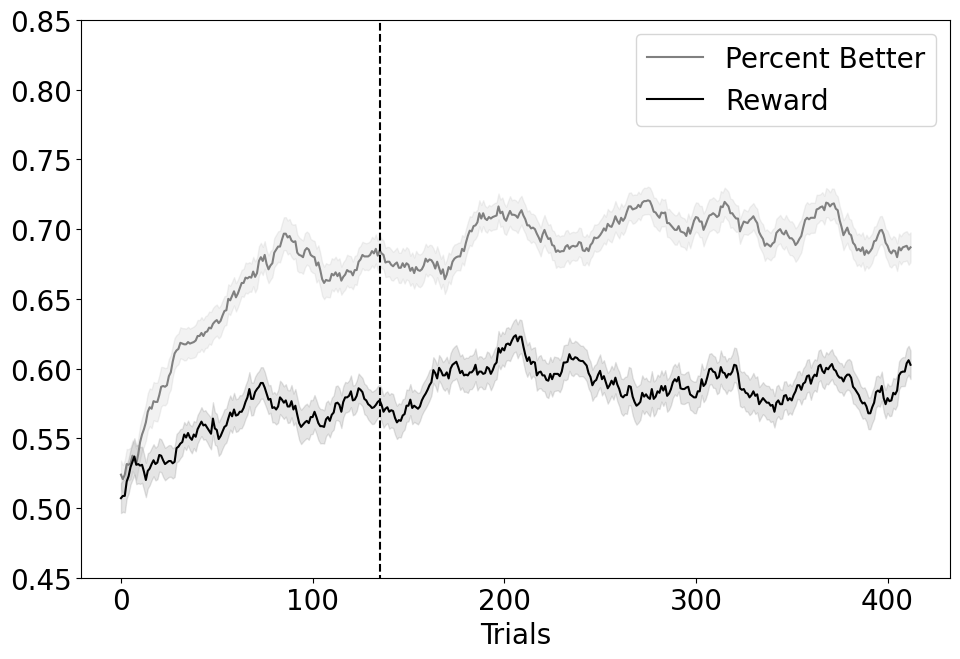

Figure saved at plots/no_rwd_input_large_rate_reg/learning_curve.pdf


In [5]:
plot_learning_curve(args, all_saved_states['rewards'], all_saved_states['choose_better'], plot_save_dir)

In [ ]:
# all_saved_states['whs_final'].shape
plot_weight_summary(args, all_saved_states['whs_final']*model.rnn.h2h.mask, 
                    model.rnn.h2h.effective_weight().detach())

# Behavioral Analysis

In [6]:
def obj_to_ft_conj(obj, task_mdprl):
    F1 = task_mdprl.index_shp[obj]
    F2 = task_mdprl.index_pttrn[obj]
    F3 = task_mdprl.index_clr[obj]

    C1 = task_mdprl.index_pttrnclr[obj]
    C2 = task_mdprl.index_shpclr[obj]
    C3 = task_mdprl.index_shppttrn[obj]

    return np.stack([F1, F2, F3, C1, C2, C3, obj], axis=-1)

def obj_to_value_est(obj, task_mdprl):
    pF1, pF2, pF3, pC1, pC2, pC3, pO = task_mdprl.value_est()

    return pF1[obj], pC1[obj], pO[obj]

def steady_state_choice_analysis(all_saved_states, task_mdprl):
    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(432-216, num_trials)
    num_subj = all_saved_states['rewards'].shape[2]

    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):
        # stim in sensory space, ntrials X 2
        stims = all_saved_states['stimuli'][num_trials_to_fit,0,idx_subj,:] 
        # stim back to reward schedule space, ntrials X 2
        stims_rwd_mat = task_mdprl.permute_mapping(stims, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        pF1, pC1, pO = obj_to_value_est(stims_rwd_mat, task_mdprl) # ntrials X 2 for each
        # choices are in sensory space, map back to schedule space
        choices = all_saved_states['choices'][num_trials_to_fit,0,idx_subj]
#         choices = task_mdprl.permute_mapping(choices, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        choices = choices==stims[:,1] # ntrials

        all_Xs.append(np.stack([np.log(pF1[:,1]/pF1[:,0]), 
                                np.log(pC1[:,1]/pC1[:,0]),
                                np.log(pO[:,1]/pO[:,0]),], axis=1))
        all_Ys.append(choices)
        
    all_Xs = np.concatenate(all_Xs, 0)
    all_Ys = np.concatenate(all_Ys, 0)[:, None]
    

    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=['pFinf', 'pCinf', 'pO', 'choice']).fillna(0)
    data_group_by_F_m = all_data.groupby('pFinf').mean().apply(np.array).loc[:,'choice']
    data_group_by_F_se = all_data.groupby('pFinf').sem().apply(np.array).loc[:,'choice']
    data_group_by_C_m = all_data.groupby('pCinf').mean().apply(np.array).loc[:,'choice']
    data_group_by_C_se = all_data.groupby('pCinf').sem().apply(np.array).loc[:,'choice']

    fig, axes = plt.subplots()
    fig.set_size_inches((7, 5))
    axes.errorbar(data_group_by_F_m.index.values, 
                 data_group_by_F_m.values, 
                 data_group_by_F_se.values,
                 c=mpl.colormaps['tab10']([0]),
                 ls='', marker='o', mfc='white')
    axes.errorbar(data_group_by_C_m.index.values, 
                 data_group_by_C_m.values, 
                 data_group_by_C_se.values,
                 c=mpl.colormaps['tab10']([3]),
                 ls='', marker='o', mfc='white')
    

    mdl = smf.glm('choice~pFinf+pCinf+pO', all_data, missing='drop', family=sm.families.Binomial())
    mdlf = mdl.fit()
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:]
    all_ses = mdlf.bse[1:]
    all_ps = mdlf.pvalues[1:]

    all_coeffs = np.stack(all_coeffs)
    all_ses = np.stack(all_ses)
    all_ps = np.stack(all_ps)

    var_names = ['F0', 'C0', 'O']
    
    xs = np.linspace(-1., 1., 100)
    
    axes.plot(xs, 1/(1+np.exp(-all_coeffs[0]*xs)), color=mpl.colormaps['tab10']([0]), label='F0')
    axes.plot(xs, 1/(1+np.exp(-all_coeffs[1]*xs)), color=mpl.colormaps['tab10']([3]), label='C0')
    axes.legend()
    
    
    axin = axes.inset_axes([0.65, 0.1, 0.3, 0.3])
    axin.bar(np.arange(1, len(var_names)+1), all_coeffs, color=mpl.colormaps['tab10']([0, 3, 7]))
    axin.errorbar(np.arange(1, len(var_names)+1), all_coeffs, all_ses, linestyle="", color='k')
    axin.text(1, all_coeffs[0]+all_ses[0]+0.05, convert_pvalue_to_asterisks(all_ps[0]), 
            verticalalignment='center', horizontalalignment='center', fontsize=16)
    axin.text(2, all_coeffs[1]+all_ses[1]+0.05, convert_pvalue_to_asterisks(all_ps[1]), 
            verticalalignment='center', horizontalalignment='center', fontsize=16)
    axin.text(3, all_coeffs[2]+np.sign(all_coeffs[2])*(all_ses[2]+0.3), convert_pvalue_to_asterisks(all_ps[2]), 
            verticalalignment='center', horizontalalignment='center', fontsize=16)
    axin.set_ylim([-0.9, 3.5])
    axin.set_xticks(range(1,4), labels=var_names, fontsize=12)
    axin.set_yticks(range(0,4), labels=range(0,4), fontsize=12)
    axin.set_ylabel('Slopes', fontsize=16)
    axes.set_xlabel('Log odd of reward')
    axes.set_ylabel('Choice probability')
    plt.tight_layout()
    plt.savefig(os.path.join('plots/', plot_save_dir, "choice_curves_slopes.pdf"))
    print(f'Figure saved at plots/{plot_save_dir}/choice_curves_slopes.pdf')
    plt.show()
    plt.close()
    return


def credit_assignment(all_saved_states, task_mdprl):
    # find chosen feedback, unchosen feedback
    # stimuli torch.Size([432, 1, 92, 2])
    # reward_probs torch.Size([432, 1, 92, 2])
    # choices torch.Size([432, 1, 92])
    # rewards torch.Size([432, 1, 92])
    # choose_better torch.Size([432, 1, 92])
    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(0, 216-1)
    num_subj = all_saved_states['rewards'].shape[2]
    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):
        
        stims_post = all_saved_states['stimuli'][num_trials_to_fit+1,0,idx_subj,:] # ntrials X 2
        stims_post = task_mdprl.permute_mapping(stims_post, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        stims_pre_chosen = all_saved_states['choices'][num_trials_to_fit,0,idx_subj] # ntrials
        stims_pre_chosen = task_mdprl.permute_mapping(stims_pre_chosen, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        choices = all_saved_states['choices'][num_trials_to_fit+1,0,idx_subj]
        choices = task_mdprl.permute_mapping(choices, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        choices = choices==stims_post[:,1]
        rwd_pre = 2*all_saved_states['rewards'][num_trials_to_fit,0,idx_subj]-1 # ntrials
        
        stimsFCO_pre_chosen = obj_to_ft_conj(stims_pre_chosen, task_mdprl) # ntrials X 7
        stimsFCO_post = obj_to_ft_conj(stims_post, task_mdprl) # ntrials X 2 X 7
        
        
        # predictors are inf dim R chosen, inf dim C chosen, noninf dim R chosen, noninf dim C chosen, 
        subj_Xs = np.concatenate([rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  rwd_pre[:,None]*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:]),\
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:])], axis=-1)
        
        all_Xs.append(subj_Xs)
        all_Ys.append(choices)

    all_Xs = np.concatenate(all_Xs, axis=0)
    all_Ys = np.concatenate(all_Ys, axis=0)[:,None]
    
    var_names = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
    rw_ch = ['R', 'C']

    all_var_names = ['_'.join([s, 'R']) for s in var_names] + ['_'.join([s, 'C']) for s in var_names]

    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=[*all_var_names, 'choice'])

    mdl = smf.glm('choice~'+'+'.join(all_var_names), data=all_data, family=sm.families.Binomial())
    mdlf = mdl.fit()
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:]
    all_ses = mdlf.bse[1:]
    all_ps = mdlf.pvalues[1:]

    all_xlabels = var_names

    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches((10, 5))
    
    bar_rw = axes[0].bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[:len(var_names)], \
                yerr=all_ses[:len(var_names)], \
                color=mpl.colormaps['tab10'](np.arange(0,7)), 
                capsize=5)
    bar_ch = axes[1].bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[len(var_names):], \
                yerr=all_ses[len(var_names):], \
                color=mpl.colormaps['tab10'](np.arange(0,7)), 
                capsize=5)
    axes[0].set_ylabel('Regression weights')
    axes[0].set_xlabel('Win-stay lose-switch')
    axes[1].set_xlabel('Choice autocorrelation')
    axes[0].set_ylim([-0.25, 0.55])
    axes[1].set_ylim([-0.25, 0.55])
    axes[0].set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    axes[1].set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    for i in range(len(var_names)):
        axes[0].text(i+1, all_coeffs[i]+np.sign(all_coeffs[i])*(all_ses[i]+0.02)-0.01, 
                     convert_pvalue_to_asterisks(all_ps[i]), 
                     verticalalignment='center', horizontalalignment='center')
        
    for i in range(len(var_names)):
        axes[1].text(i+1, all_coeffs[i+len(var_names)]+np.sign(all_coeffs[i+len(var_names)])*(all_ses[i+len(var_names)]+0.02)-0.01, 
                     convert_pvalue_to_asterisks(all_ps[i+len(var_names)]), 
                     verticalalignment='center', horizontalalignment='center')
    plt.tight_layout()
    with PdfPages(f'plots/{plot_save_dir}/credit_assignment.pdf') as pdf:
        pdf.savefig(fig)
        print(f'Figure saved at plots/{plot_save_dir}/credit_assignment.pdf')
    plt.show()
    plt.close()
    return


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                19872
Model:                            GLM   Df Residuals:                    19868
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10693.
Date:                Wed, 04 Oct 2023   Deviance:                       21386.
Time:                        17:06:25   Pearson chi2:                 1.97e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2665
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0307      0.017     -1.828      0.0

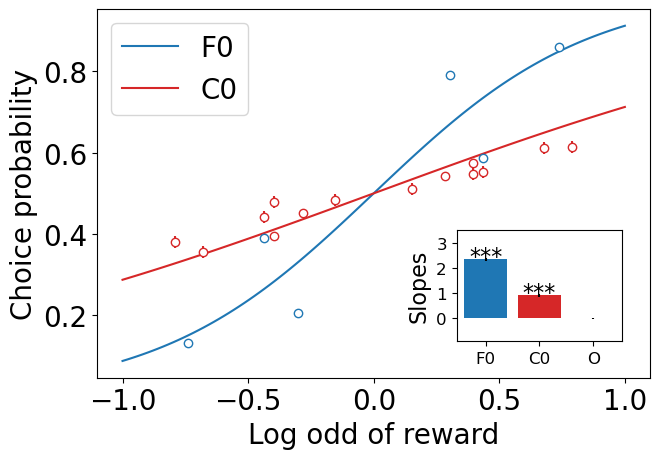

In [7]:
steady_state_choice_analysis(all_saved_states, task_mdprl)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 choice   No. Observations:                19780
Model:                            GLM   Df Residuals:                    19765
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13400.
Date:                Wed, 04 Oct 2023   Deviance:                       26799.
Time:                        17:06:26   Pearson chi2:                 1.98e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03094
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0030      0.014      0.206      0.8

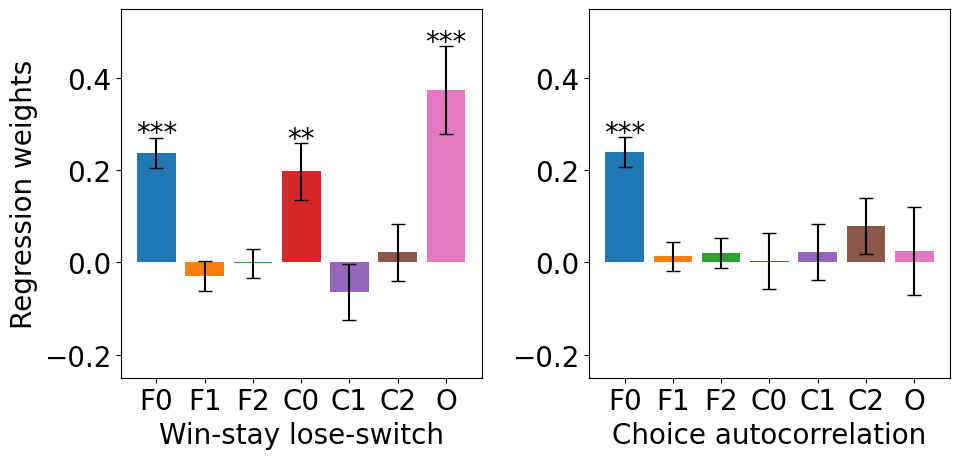

In [8]:
credit_assignment(all_saved_states, task_mdprl)

In [9]:
def sensitivity_regression(all_saved_states, task_mdprl):
    # find chosen feedback, unchosen feedback
    # stimuli torch.Size([432, 1, 92, 2])
    # reward_probs torch.Size([432, 1, 92, 2])
    # choices torch.Size([432, 1, 92])
    # rewards torch.Size([432, 1, 92])
    # choose_better torch.Size([432, 1, 92])
    num_trials = all_saved_states['rewards'].shape[0]
    num_trials_to_fit = np.arange(0, 216-1)
    num_subj = all_saved_states['rewards'].shape[2]
    all_Xs = []
    all_Ys = []

    for idx_subj in range(num_subj):
        
        stims_post = all_saved_states['stimuli'][num_trials_to_fit+1,0,idx_subj,:] # ntrials X 2
        stims_post = task_mdprl.permute_mapping(stims_post, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        stims_pre_chosen = all_saved_states['choices'][num_trials_to_fit,0,idx_subj] # ntrials
        stims_pre_chosen = task_mdprl.permute_mapping(stims_pre_chosen, task_mdprl.test_sensory2stim_idx[idx_subj]) 
        sensitivity = all_saved_states['sensitivity'][num_trials_to_fit+1,0,idx_subj]
        
        stimsFCO_pre_chosen = obj_to_ft_conj(stims_pre_chosen, task_mdprl) # ntrials X 7
        stimsFCO_post = obj_to_ft_conj(stims_post, task_mdprl) # ntrials X 2 X 7
        
        
        # predictors are inf dim R chosen, inf dim C chosen, noninf dim R chosen, noninf dim C chosen, 
        subj_Xs = np.concatenate([1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,1,:])-
                                  1.0*(stimsFCO_pre_chosen==stimsFCO_post[:,0,:])], axis=-1)
        
        all_Xs.append(subj_Xs)
        all_Ys.append(sensitivity)

    all_Xs = np.concatenate(all_Xs, axis=0)
    all_Ys = np.concatenate(all_Ys, axis=0)[:,None]
    
    var_names = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
    
    all_data = pd.DataFrame(np.concatenate([all_Xs, all_Ys], axis=1), columns=[*var_names, 'sensitivity'])
    

    mdl = smf.ols('sensitivity~'+'+'.join(var_names), data=all_data)
    mdlf = mdl.fit()
    print(mdlf.summary())
    all_coeffs = mdlf.params[1:]
    all_ses = mdlf.bse[1:]
    all_ps = mdlf.pvalues[1:]

    all_xlabels = var_names

    fig, axes = plt.subplots(figsize=(8,5))
    
    bar_rw = axes.bar(x=np.arange(1,len(var_names)+1), \
                height=all_coeffs[:len(var_names)], \
                yerr=all_ses[:len(var_names)], \
                color=mpl.colormaps['tab10'](np.arange(0,7)), 
                capsize=5)
#     bar_ch = axes[1].bar(x=np.arange(1,len(var_names)+1), \
#                 height=all_coeffs[len(var_names):], \
#                 yerr=all_ses[len(var_names):], \
#                 color=mpl.colormaps['tab10'](np.arange(0,7)), 
#                 capsize=5)
    axes.set_ylabel('Regression weights')
    axes.set_xlabel('Shared dimension')
#     axes[1].set_xlabel('Choice autocorrelation')
    axes.set_ylim([-0.05, 0.85])
#     axes[1].set_ylim([-0.25, 0.55])
    axes.set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
#     axes[1].set_xticks(np.arange(1, len(var_names)+1), labels=all_xlabels)
    for i in range(len(var_names)):
        axes.text(i+1, all_coeffs[i]+np.sign(all_coeffs[i])*(all_ses[i]+0.02)-0.01, 
                     convert_pvalue_to_asterisks(all_ps[i]), 
                     verticalalignment='center', horizontalalignment='center')
        
#     for i in range(len(var_names)):
#         axes[1].text(i+1, all_coeffs[i+len(var_names)]+np.sign(all_coeffs[i+len(var_names)])*(all_ses[i+len(var_names)]+0.02)-0.01, 
#                      convert_pvalue_to_asterisks(all_ps[i+len(var_names)]), 
#                      verticalalignment='center', horizontalalignment='center')
    plt.tight_layout()
#     with PdfPages(f'plots/{plot_save_dir}/credit_assignment.pdf') as pdf:
#         pdf.savefig(fig)
#         print(f'Figure saved at plots/{plot_save_dir}/credit_assignment.pdf')
    plt.show()
    plt.close()
    return


                            OLS Regression Results                            
Dep. Variable:            sensitivity   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     9492.
Date:                Wed, 04 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:06:26   Log-Likelihood:                 1671.3
No. Observations:               19780   AIC:                            -3327.
Df Residuals:                   19772   BIC:                            -3263.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004      0.002      0.260      0.7

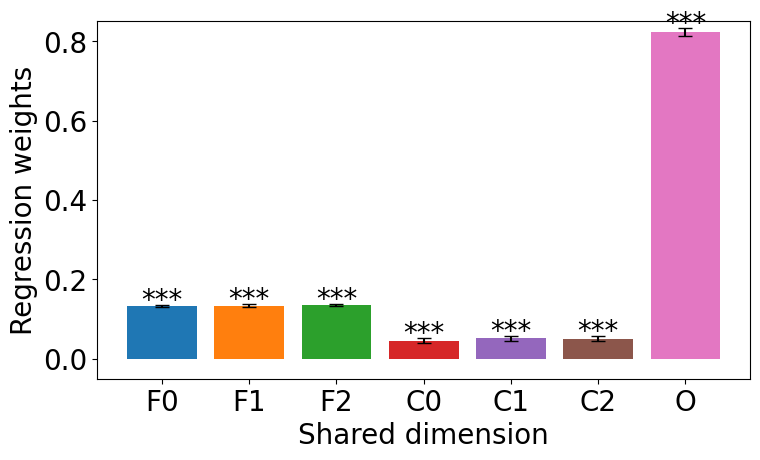

In [10]:
sensitivity_regression(all_saved_states, task_mdprl)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                39652
Model:                            GLM   Df Residuals:                    39651
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27317.
Date:                Wed, 04 Oct 2023   Deviance:                       54633.
Time:                        17:06:29   Pearson chi2:                 3.97e+04
No. Iterations:                     4   Pseudo R-squ. (CS):           0.008413
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.4214      0.024     17.847      0.0

(-5.0, 5.0)

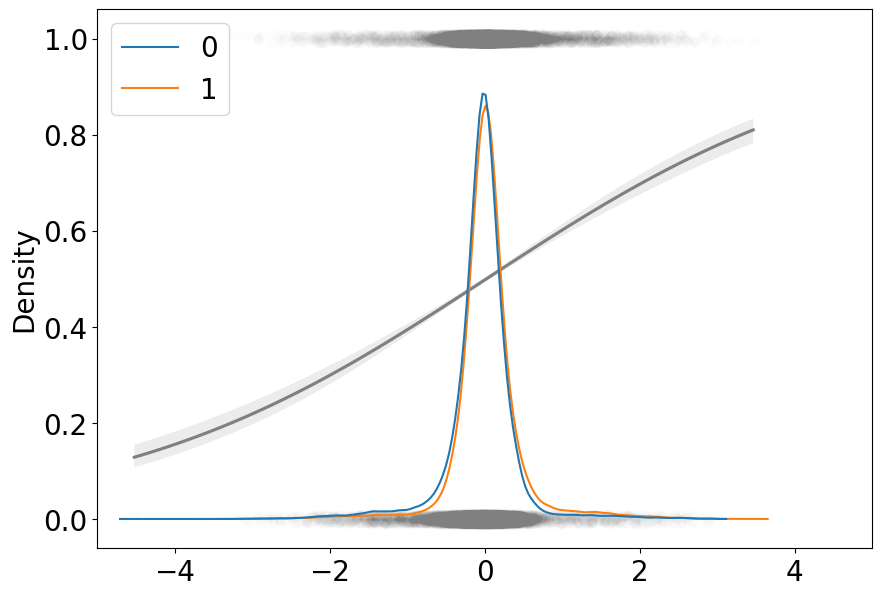

In [11]:
import statsmodels.api as sm

log_reg_choice_sensitivity = sm.GLM((all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy(), 
                                      ((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['sensitivity'][1:]).flatten().numpy(),
                                   family=sm.families.Binomial()).fit()

print(log_reg_choice_sensitivity.summary())

# plt.plot(np.linspace(-4, 4, 100), 1/(1+np.exp(-0.4214*np.linspace(-4, 4, 100))))
# plt.scatter(((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['sensitivity'][1:]).flatten().numpy(),
#             (all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy(),
#            alpha=0.01)


sns.regplot(x=((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['sensitivity'][1:]).flatten().numpy(),
           y=(all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy(),
          logistic=True, y_jitter=0.01, color='grey', scatter_kws={'alpha': 0.01})

sns.kdeplot(x=((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['sensitivity'][1:]).flatten().numpy(),
           hue=(all_saved_states['choices'][1:]==all_saved_states['stimuli'][1:,...,1]).long().flatten().numpy())

plt.xlim([-5, 5])


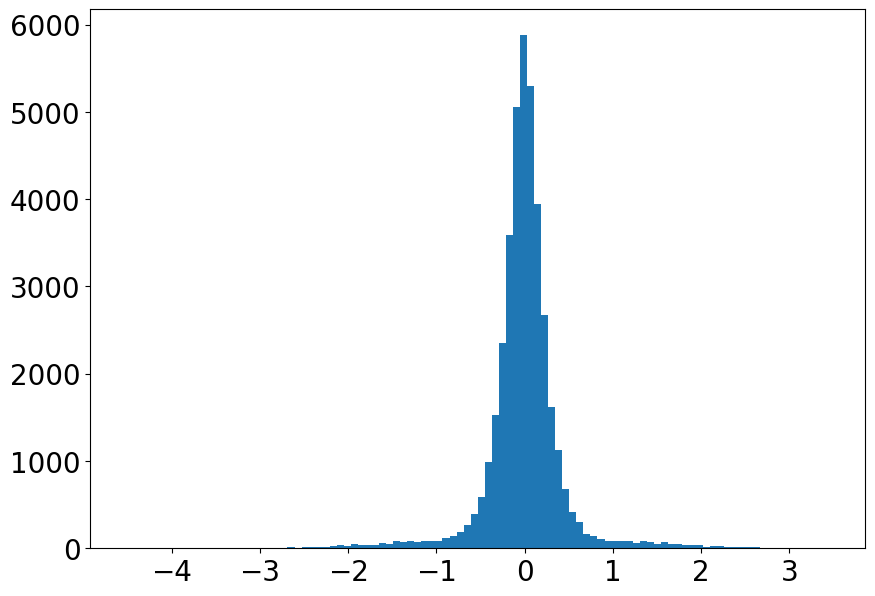

In [12]:
plt.hist(((2*all_saved_states['rewards'][:-1]-1)*all_saved_states['sensitivity'][1:]).flatten().numpy(), bins=100);

# Plot Initial Connectivity

In [21]:
model_vis_idx = 4

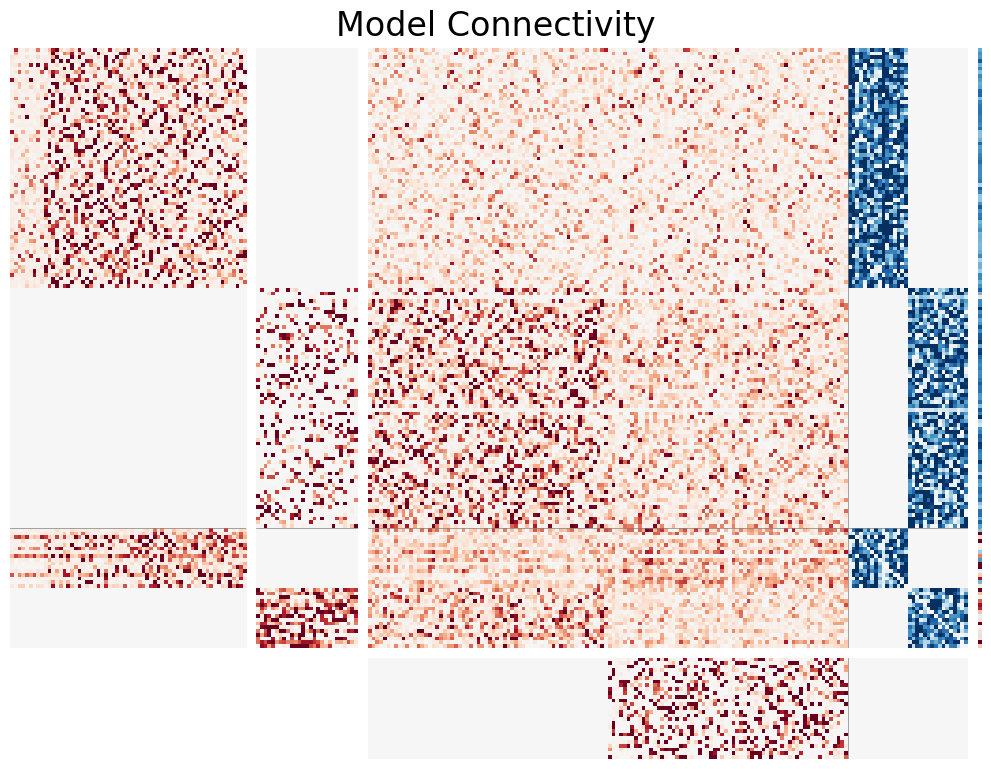

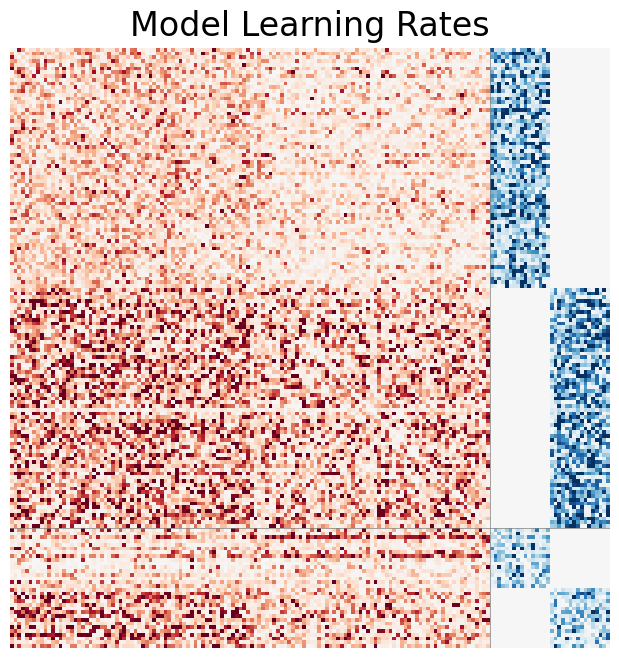

In [22]:
plot_connectivity_lr(torch.arange(args['hidden_size']*args['num_areas']), 
                             x2hw=all_models[model_vis_idx].rnn.x2h.effective_weight().detach(),
                             h2hw=all_models[model_vis_idx].rnn.h2h.effective_weight().detach(),
                             hb=all_models[model_vis_idx].rnn.h2h.bias.detach(),
                             h2ow=torch.cat([torch.zeros(27, E_SIZE), all_models[model_vis_idx].h2o.effective_weight().detach(), torch.zeros(27, I_SIZE*2)], dim=1),
                             aux2h=all_models[model_vis_idx].rnn.aux2h.effective_weight().detach(),
                             kappa_rec=all_models[model_vis_idx].rnn.kappa_rec.squeeze().abs().detach()*model.rnn.h2h.mask,
                             e_size=int(args['e_prop']*args['hidden_size'])*args['num_areas'], args=args)

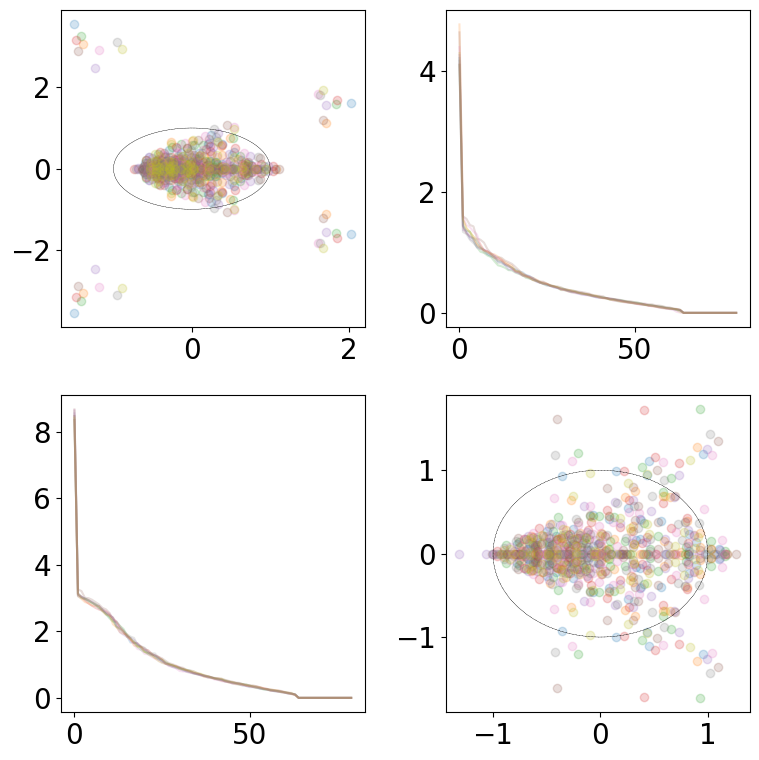

In [23]:
all_model_rec_intra = []
all_model_rec_inter_ff = []
all_model_rec_inter_fb = []

fig, axes = plt.subplots(NUM_AREAS, NUM_AREAS, figsize=(8,8))

for i in range(NUM_AREAS):
    axes[i,i].plot(np.cos(np.linspace(-2*np.pi,2*np.pi,100)),\
                   np.sin(np.linspace(-2*np.pi,2*np.pi,100)), \
                   'k--', linewidth=0.2)

for model in all_models:
    h2h = torch.clamp(model.rnn.h2h.effective_weight().detach(), -1, 1)

    rec_intra = []
#     us = []
#     vhs = []
    ss = []
    for i in range(NUM_AREAS):
        rec_intra.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                             list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                          [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                             list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
        u, sv, vh = np.linalg.svd(rec_intra[i], full_matrices=False)
        s = np.linalg.eigvals(rec_intra[i])
    #     us.append(u)
    #     vhs.append(vh)
        ss.append(s)

    #     axes[i,1].hlines(0.95, 0, 80, colors='grey', linestyles='dashed')
    
    all_model_rec_intra.append(rec_intra)

    rec_inter_ff = []
    rec_inter_fb = []
#     us_ff = []
#     us_fb = []
#     vhs_ff = []
#     vhs_fb = []
    ss_ff = []
    ss_fb = []
    for i in range(NUM_AREAS-1):
       rec_inter_ff.append(h2h[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))]
                             [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
       rec_inter_fb.append(h2h[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                             [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])
       u, s, vh = np.linalg.svd(rec_inter_ff[i], full_matrices=False)
#        us_ff.append(u)
#        vhs_ff.append(vh)
       ss_ff.append(s)
       u, s, vh = np.linalg.svd(rec_inter_fb[i], full_matrices=False)
#        us_fb.append(u)
#        vhs_fb.append(vh)
       ss_fb.append(s)
        
    all_model_rec_inter_ff.append(rec_inter_ff)
    all_model_rec_inter_fb.append(rec_inter_fb)


    for i in range(NUM_AREAS):
        axes[i,i].scatter(ss[i].real, ss[i].imag, alpha=0.2)
    #     axes[i,i].bar(np.arange(0,args['hidden_size']),ss[i])

    for i in range(NUM_AREAS-1):
        axes[1,0].plot(np.arange(0,args['hidden_size']),ss_ff[i],'-', alpha=0.2)
        axes[0,1].plot(np.arange(0,args['hidden_size']),ss_fb[i],'-', alpha=0.2)


        
plt.tight_layout()
plt.show()

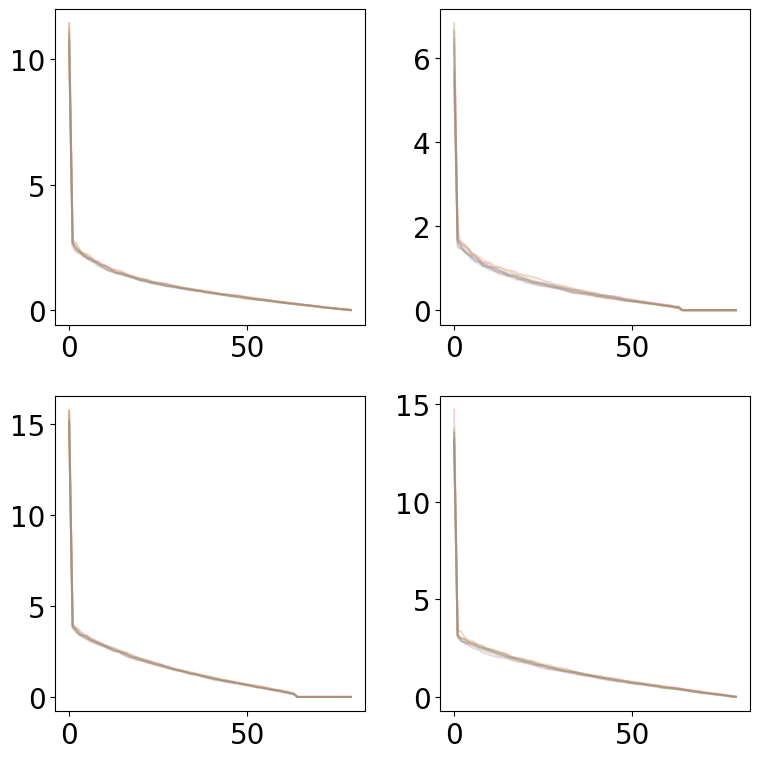

In [24]:
all_model_kappa_rec_intra = []
all_model_kappa_inter_ff = []
all_model_kappa_inter_fb = []

fig, axes = plt.subplots(2,2, figsize=(8,8))

for model in all_models:

    kappa_rec = model.rnn.kappa_rec.abs().detach()*model.rnn.h2h.mask

    kappa_rec_intra = []
    us = []
    vhs = []
    ss = []
    for i in range(NUM_AREAS):
        kappa_rec_intra.append(kappa_rec[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                   list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                                  [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                     list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
        u, s, vh = np.linalg.svd(kappa_rec_intra[i], full_matrices=False)
    #     s = np.linalg.eigvals(kappa_rec_intra[i])
#         us.append(u)
#         vhs.append(vh)
        ss.append(s)
        
    all_model_kappa_rec_intra.append(kappa_rec_intra)
    
    for i in range(NUM_AREAS):
        axes[i,i].plot(np.arange(0,args['hidden_size']), ss[i][:], '-', alpha=0.2)
        
    
    kappa_inter_ff = []
    kappa_inter_fb = []
    us_ff = []
    us_fb = []
    vhs_ff = []
    vhs_fb = []
    ss_ff = []
    ss_fb = []
    for i in range(NUM_AREAS-1):
        kappa_inter_ff.append(kappa_rec[list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                     list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))]
                                 [:,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                    list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
        kappa_inter_fb.append(kappa_rec[list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                     list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))]
                                    [:,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                       list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])
        u, s, vh = np.linalg.svd(kappa_inter_ff[i], full_matrices=False)
#        us_ff.append(u)
#        vhs_ff.append(vh)
        ss_ff.append(s)
        u, s, vh = np.linalg.svd(kappa_inter_fb[i], full_matrices=False)
#        us_fb.append(u)
#        vhs_fb.append(vh)
        ss_fb.append(s)
        
    all_model_kappa_inter_ff.append(kappa_inter_ff)
    all_model_kappa_inter_fb.append(kappa_inter_fb)

    
    axes[1,0].plot(np.arange(0,args['hidden_size']), ss_ff[0][:], '-', alpha=0.2)
    axes[0,1].plot(np.arange(0,args['hidden_size']), ss_fb[0][:], '-', alpha=0.2)

plt.tight_layout()
plt.show()

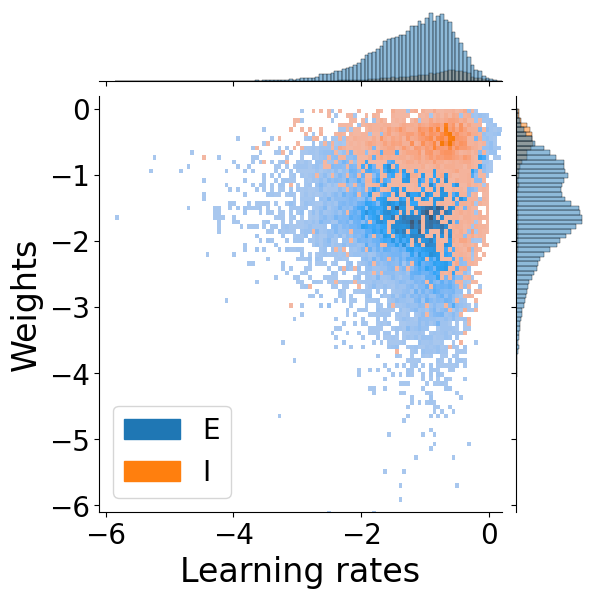

In [25]:

ei_label = np.empty(torch.sum(all_models[model_vis_idx].rnn.h2h.mask.squeeze().flatten().abs()>0).long().item(), dtype=object)
ei_label[model.rnn.h2h.mask.squeeze().flatten()[all_models[model_vis_idx].rnn.h2h.mask.squeeze().flatten().abs()>0]>0] = 'E'
ei_label[model.rnn.h2h.mask.squeeze().flatten()[all_models[model_vis_idx].rnn.h2h.mask.squeeze().flatten().abs()>0]<0] = 'I'
sjp = sns.jointplot(x=np.log10(all_models[model_vis_idx].rnn.kappa_rec.squeeze().abs().detach().flatten()[all_models[model_vis_idx].rnn.h2h.mask.squeeze().flatten().abs()>0]),
                    y=np.log10(all_models[model_vis_idx].rnn.h2h.effective_weight().detach().flatten().abs()[all_models[model_vis_idx].rnn.h2h.mask.squeeze().flatten().abs()>0]),
                    hue=ei_label, kind='hist')
sjp.set_axis_labels('Learning rates', 'Weights', fontsize=24)
sns.move_legend(sjp.ax_joint, 'lower left')
plt.xlim([-6.1, 0.2])
plt.ylim([-6.1, 0.2])
plt.show()

# a, b = np.polyfit(np.log10(model.rnn.kappa_rec.squeeze().abs().detach().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]), \
#                   np.log10(model.rnn.h2h.effective_weight().detach().flatten().abs()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]), 1)
# plt.plot(np.linspace(-4, 0, 100), a*np.linspace(-4, 0, 100)+b, c='k')
# stats.spearmanr(np.log10(model.rnn.kappa_rec.squeeze().abs().detach().flatten()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]), \
#                 np.log10(model.rnn.h2h.effective_weight().detach().flatten().abs()[model.rnn.h2h.mask.squeeze().flatten().abs()>0]))

# Subspace Analysis


### Decompose each input, output, and choice pattern as a sum of feature, conjunction, and object patterns
$I_{i} = I_{ft}(i)+I_{conj}(i)+I_{obj}(i)$

In [26]:
input_weight_inds = list(range(E_SIZE)) + list(range(E_SIZE*args['num_areas'], E_SIZE*args['num_areas']+I_SIZE))
output_weight_inds = list(range(E_SIZE, 2*E_SIZE)) + list(range(E_SIZE*args['num_areas']+I_SIZE, E_SIZE*args['num_areas']+2*I_SIZE))


all_model_stims = []


for model in all_models:
    stims, global_avg_in, ft_avg_in, conj_avg_in, obj_avg_in = get_input_encodings(
        model.rnn.x2h.effective_weight()[input_weight_inds].detach().numpy(), 
        task_mdprl.stim_encoding('all_onehot'))
    all_model_stims.append(stims)

# global_avg_out, ft_avg_out, conj_avg_out, obj_avg_out = get_input_encodings(
#     model.h2o.effective_weight().detach().numpy().T, np.eye(27))

## Use dPCA to get ft/conj/obj specific axes in the input and output weights

In [27]:
n_components_for_dpca = {'s':2, 'p':2, 'c':2, 'sc':4, 'sp':4, 'pc':4, 'spc': 8}


all_model_dpca_in = []
all_model_dpca_out = []
all_model_dpca_ch = []


all_model_low_input = []
all_model_low_output = []
all_model_low_ch = []

for model_idx, model in enumerate(all_models):
    dpca_in = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
    low_input = dpca_in.fit_transform(all_model_stims[model_idx].reshape((args['hidden_size'],3,3,3)))

    expanded_h2o = torch.cat([model.h2o.effective_weight().detach(), torch.zeros(27, I_SIZE)], dim=1)
    dpca_out = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
    low_output = dpca_out.fit_transform(expanded_h2o.numpy().T.reshape((args['hidden_size'],3,3,3)))

    dpca_ch = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
    low_ch = dpca_ch.fit_transform(model.rnn.aux2h.effective_weight().detach().numpy()\
                                   [list(range(E_SIZE, E_SIZE*2))+list(range(E_SIZE*2+I_SIZE, E_SIZE*2+I_SIZE*2)),:]\
                                   .reshape((args['hidden_size'],3,3,3)))

    all_model_low_input.append(low_input)
    all_model_low_output.append(low_output)
    all_model_low_ch.append(low_ch)
    
    all_model_dpca_in.append(dpca_in)
    all_model_dpca_out.append(dpca_out)
    all_model_dpca_ch.append(dpca_ch)

#     dpca_stim = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
#     low_stims = dpca_stim.fit_transform(task_mdprl.stim_encoding('all_onehot').T.reshape((63,3,3,3)))


/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:980: RuntimeWarning: invalid value encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]


Figure saved at plots/no_rwd_input_large_rate_reg/selectivity_profile.pdf


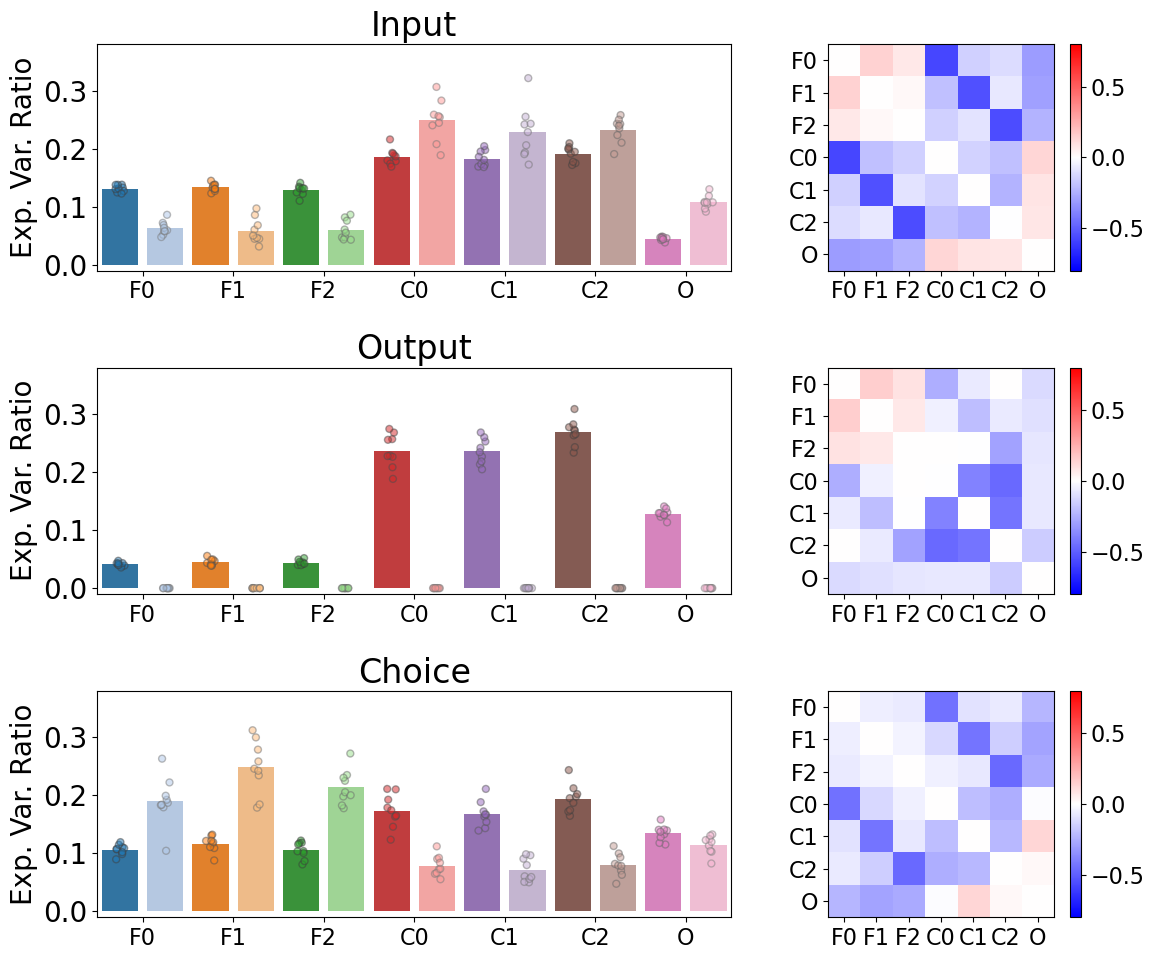

In [28]:
fig, axes = plt.subplots(3, 2, width_ratios=(2, 1), figsize=(12,10))

corr_scale = 0.8

xxx_for_plot = np.repeat(np.arange(14)[None], len(all_models), axis=0)
xxx_for_plot[xxx_for_plot%2==0]=xxx_for_plot[xxx_for_plot%2==0]
xxx_for_plot[xxx_for_plot%2==1]=xxx_for_plot[xxx_for_plot%2==1]

unitwise_selectivity_input = np.zeros((len(all_models), 7, 2))
selelctivity_corr_input = np.zeros((len(all_models), 7, 7))
for model_idx, model in enumerate(all_models):
    curr_model_unitwise_selectivity = np.zeros((7, args['hidden_size']))
    for k_idx, k in enumerate(['s','p','c','pc','sc','sp','spc']):
        curr_model_unitwise_selectivity[k_idx] = \
            np.sum(all_model_dpca_in[model_idx].unitwise_explained_variance_ratio_[k], 0)
    unitwise_selectivity_input[model_idx,:,0] = np.mean(curr_model_unitwise_selectivity[:,:E_SIZE], 1)
    unitwise_selectivity_input[model_idx,:,1] = np.mean(curr_model_unitwise_selectivity[:,E_SIZE:], 1)
    selelctivity_corr_input[model_idx] = np.corrcoef(curr_model_unitwise_selectivity)-np.eye(7)
# axes[0,0].imshow(unitwise_selectivity_input.mean(0).T, aspect='auto', cmap='hot', vmin=0, vmax=1)
sns.barplot(ax=axes[0,0], x=xxx_for_plot.flatten(), y=unitwise_selectivity_input.flatten(),
              palette='tab20', errorbar=None)
sns.stripplot(ax=axes[0,0], x=xxx_for_plot.flatten(), y=unitwise_selectivity_input.flatten(),
              hue=xxx_for_plot.flatten(),
              palette='tab20', legend=False, linewidth=1, alpha=0.5)
im = axes[0,1].imshow(selelctivity_corr_input.mean(0), cmap='bwr', vmin=-corr_scale, vmax=corr_scale)
cb = plt.colorbar(im, shrink=1)
cb.ax.tick_params(labelsize=16)
axes[0,0].set_title('Input')

unitwise_selectivity_output = np.zeros((len(all_models), 7, 2))
selelctivity_corr_output = np.zeros((len(all_models), 7, 7))
for model_idx, model in enumerate(all_models):
    curr_model_unitwise_selectivity = np.zeros((7, args['hidden_size']))
    for k_idx, k in enumerate(['s','p','c','pc','sc','sp','spc']):
        curr_model_unitwise_selectivity[k_idx] = \
            np.sum(all_model_dpca_out[model_idx].unitwise_explained_variance_ratio_[k], 0)
    curr_model_unitwise_selectivity = np.nan_to_num(curr_model_unitwise_selectivity, 0)
    unitwise_selectivity_output[model_idx,:,0] = np.mean(curr_model_unitwise_selectivity[:,:E_SIZE], 1)
    unitwise_selectivity_output[model_idx,:,1] = np.nanmean(curr_model_unitwise_selectivity[:,E_SIZE:], 1)
    selelctivity_corr_output[model_idx] = np.corrcoef(curr_model_unitwise_selectivity[:,:E_SIZE])-np.eye(7)    
# axes[0,1].imshow(unitwise_selectivity_output.mean(0).T, aspect='auto', cmap='hot', vmin=0, vmax=1)
sns.barplot(ax=axes[1,0], x=xxx_for_plot.flatten(), y=unitwise_selectivity_output.flatten(),
             palette='tab20', errorbar=None)
sns.stripplot(ax=axes[1,0], x=xxx_for_plot.flatten(), y=unitwise_selectivity_output.flatten(),
              hue=xxx_for_plot.flatten(), 
              palette='tab20', legend=False, linewidth=1, alpha=0.5)
im = axes[1,1].imshow(selelctivity_corr_output.mean(0), cmap='bwr', vmin=-corr_scale, vmax=corr_scale)
cb = plt.colorbar(im, shrink=1)
cb.ax.tick_params(labelsize=16)
axes[1,0].set_title('Output')

unitwise_selectivity_choice = np.zeros((len(all_models), 7, 2))
selelctivity_corr_choice = np.zeros((len(all_models), 7, 7))
for model_idx, model in enumerate(all_models):
    curr_model_unitwise_selectivity = np.zeros((7, args['hidden_size']))
    for k_idx, k in enumerate(['s','p','c','pc','sc','sp','spc']):
        curr_model_unitwise_selectivity[k_idx] = \
            np.sum(all_model_dpca_ch[model_idx].unitwise_explained_variance_ratio_[k], 0)
    unitwise_selectivity_choice[model_idx,:,0] = np.mean(curr_model_unitwise_selectivity[:,:E_SIZE], 1)
    unitwise_selectivity_choice[model_idx,:,1] = np.mean(curr_model_unitwise_selectivity[:,E_SIZE:], 1)
    selelctivity_corr_choice[model_idx] = np.corrcoef(curr_model_unitwise_selectivity)-np.eye(7)    
# axes[0,2].imshow(unitwise_selectivity_choice.mean(0).T, aspect='auto', cmap='hot', vmin=0, vmax=1)
sns.barplot(ax=axes[2,0], x=xxx_for_plot.flatten(), y=unitwise_selectivity_choice.flatten(),
             palette='tab20', errorbar=None)
sns.stripplot(ax=axes[2,0], x=xxx_for_plot.flatten(), y=unitwise_selectivity_choice.flatten(),
              hue=xxx_for_plot.flatten(), 
              palette='tab20', legend=False, linewidth=1, alpha=0.5)
im = axes[2,1].imshow(selelctivity_corr_choice.mean(0), cmap='bwr', vmin=-corr_scale, vmax=corr_scale)
cb = plt.colorbar(im, shrink=1)
cb.ax.tick_params(labelsize=16)
axes[2,0].set_title('Choice')


# axes[0,0].set_yticks([32, 72], ['E', 'I'])


for i in range(3):
    axes[i,0].set_ylabel('Exp. Var. Ratio')
    axes[i,0].set_ylim([-0.01, 0.38])
    axes[i,0].set_xticks(np.arange(7)*2+0.5, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)
    axes[i,1].set_xticks(np.arange(7), ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)
    axes[i,1].set_yticks(np.arange(7), ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)

plt.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/selectivity_profile.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/selectivity_profile.pdf')


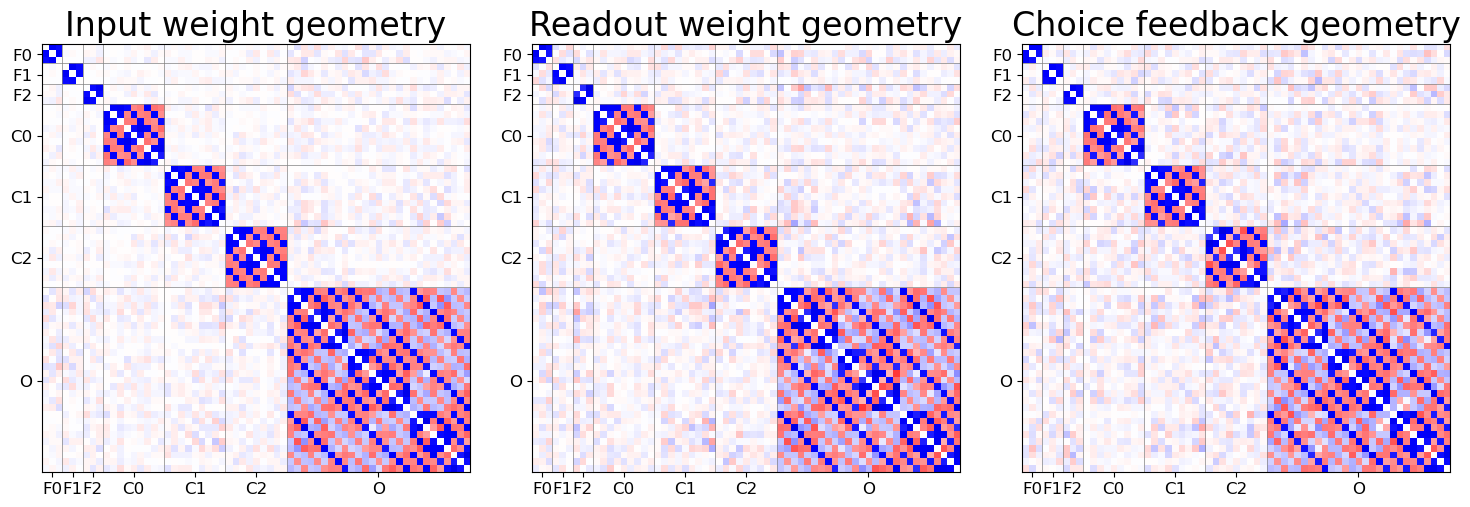

Figure saved at plots/no_rwd_input_large_rate_reg/weight_psth_geometry.pdf


In [29]:
all_model_dpca_psth_in = []
all_model_dpca_psth_out = []
all_model_dpca_psth_ch = []

for dpca_in, dpca_out, dpca_ch in zip(all_model_dpca_in, all_model_dpca_out, all_model_dpca_ch):
    all_dpca_psth_in = np.concatenate([dpca_in.marginalized_psth['s'].squeeze(), 
                                       dpca_in.marginalized_psth['p'].squeeze(), 
                                       dpca_in.marginalized_psth['c'].squeeze(), 
                                       dpca_in.marginalized_psth['pc'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_in.marginalized_psth['sc'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_in.marginalized_psth['sp'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_in.marginalized_psth['spc'].squeeze().reshape((args['hidden_size'], 27))], 
                                       axis=1)

    all_dpca_psth_out = np.concatenate([dpca_out.marginalized_psth['s'].squeeze(), 
                                       dpca_out.marginalized_psth['p'].squeeze(), 
                                       dpca_out.marginalized_psth['c'].squeeze(), 
                                       dpca_out.marginalized_psth['pc'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_out.marginalized_psth['sc'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_out.marginalized_psth['sp'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_out.marginalized_psth['spc'].squeeze().reshape((args['hidden_size'], 27))], 
                                       axis=1)

    all_dpca_psth_ch = np.concatenate([dpca_ch.marginalized_psth['s'].squeeze(), 
                                       dpca_ch.marginalized_psth['p'].squeeze(), 
                                       dpca_ch.marginalized_psth['c'].squeeze(), 
                                       dpca_ch.marginalized_psth['pc'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_ch.marginalized_psth['sc'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_ch.marginalized_psth['sp'].squeeze().reshape((args['hidden_size'], 9)), 
                                       dpca_ch.marginalized_psth['spc'].squeeze().reshape((args['hidden_size'], 27))], 
                                       axis=1)
    
    all_model_dpca_psth_in.append(all_dpca_psth_in.T)
    all_model_dpca_psth_out.append(all_dpca_psth_out.T)
    all_model_dpca_psth_ch.append(all_dpca_psth_ch.T)

all_model_dpca_psth_in = np.stack(all_model_dpca_psth_in)
all_model_dpca_psth_out = np.stack(all_model_dpca_psth_out)
all_model_dpca_psth_ch = np.stack(all_model_dpca_psth_ch)
    
fig, axes = plt.subplots(1,3)
fig.set_size_inches((15, 8))
axes[0].imshow(batch_cosine_similarity(all_model_dpca_psth_in, all_model_dpca_psth_in).mean(0)-np.eye(63),
           cmap='seismic', vmin=-1, vmax=1)
axes[0].set_title("Input weight geometry")
axes[1].imshow(batch_cosine_similarity(all_model_dpca_psth_out, all_model_dpca_psth_out).mean(0)-np.eye(63),
           cmap='seismic', vmin=-1, vmax=1)
axes[1].set_title("Readout weight geometry")
axes[2].imshow(batch_cosine_similarity(all_model_dpca_psth_ch, all_model_dpca_psth_ch).mean(0)-np.eye(63),
           cmap='seismic', vmin=-1, vmax=1)
axes[2].set_title("Choice feedback geometry")

block_boundaries = [2.5, 5.5, 8.5, 17.5, 26.5, 35.5]
ticks = [1, 4, 7, 13, 22, 31, 49]
labels = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']
for i in range(3):
    for bb in block_boundaries:
        axes[i].axvline(x=bb,color='grey',lw=0.5)
        axes[i].axhline(y=bb-0.2,color='grey',lw=0.5)
    axes[i].set_xticks(ticks)
    axes[i].set_xticklabels(labels, fontsize=12)
    axes[i].set_yticks(ticks)
    axes[i].set_yticklabels(labels, fontsize=12)
    
plt.tight_layout()
plt.show()

with PdfPages(f'plots/{plot_save_dir}/weight_psth_geometry.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/weight_psth_geometry.pdf')


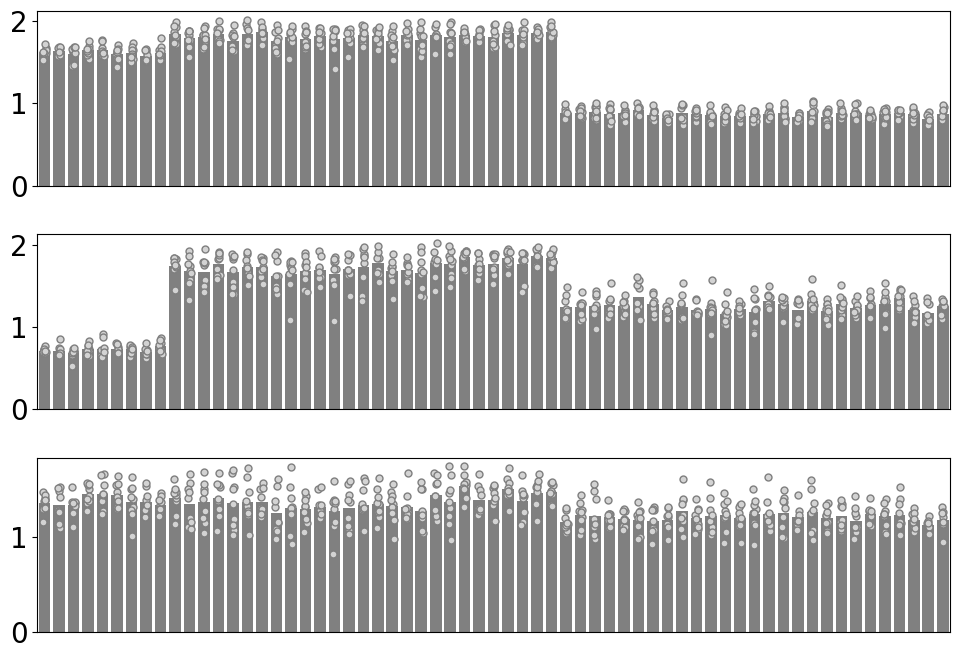

In [30]:
fig, axes = plt.subplots(3,1)

xxx_for_plot = np.tile(np.arange(63).reshape(1, 63), 9).flatten()

for idx, all_model_dpca_psth in \
    enumerate([all_model_dpca_psth_in, all_model_dpca_psth_out, all_model_dpca_psth_ch]):
    sns.stripplot(ax=axes[idx], x=xxx_for_plot, y=np.linalg.norm(all_model_dpca_psth, axis=2).flatten(), 
                  color='lightgrey', linewidth=1)
    sns.barplot(ax=axes[idx], x=xxx_for_plot, y=np.linalg.norm(all_model_dpca_psth, axis=2).flatten(), 
                  errorbar=None, color='grey')
    axes[idx].set_xticks([])


plt.tight_layout()

Figure saved at plots/no_rwd_input_large_rate_reg/input_output_weight_variance.pdf


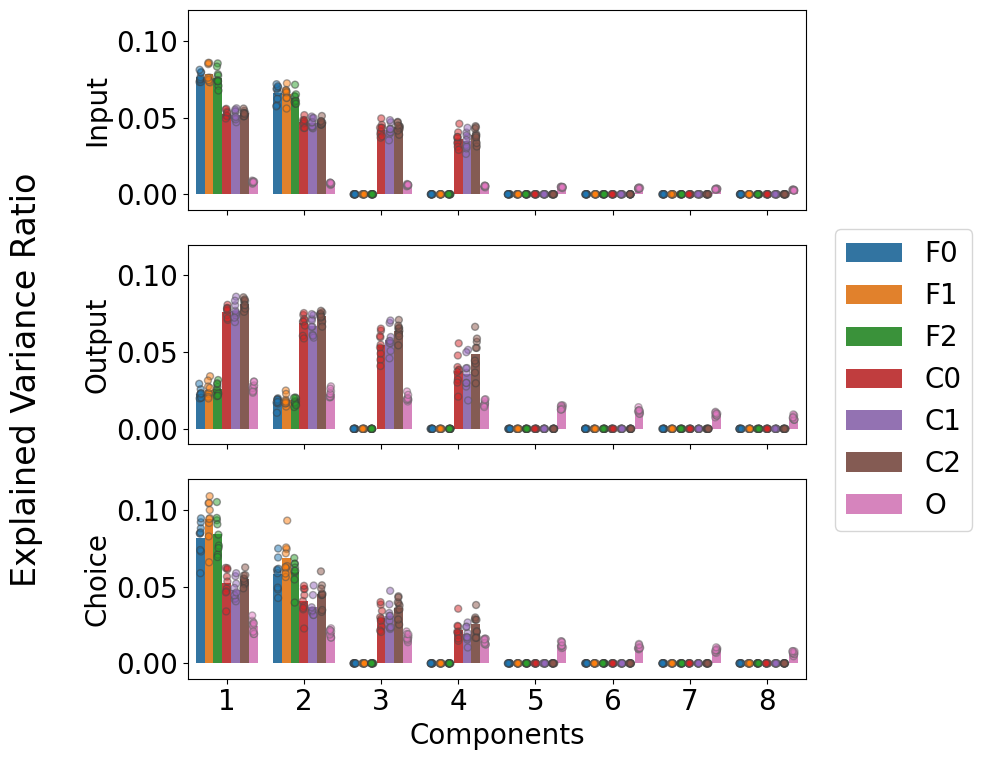

In [31]:
fig, axes = plt.subplots(3,1, figsize=(10,8))

def plot_weight_exp_vars(n_components_for_dpca, all_model_dpca, axes, ylabel):
    
    bar_width = 0.1

    key_plot_order = ['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']
    
    xxx_for_plot = np.tile(np.arange(8).reshape(1,1,8), [len(all_model_dpca),7,1])
    hue_for_plot = np.tile(np.arange(7).reshape(1,7,1), [len(all_model_dpca),1,8])

    all_model_dpca_exp_var = []
    
    for curr_model_dpca in all_model_dpca:
        all_dpca_exp_var = np.zeros((7, 8))
        for k_idx, k in enumerate(key_plot_order):
            all_dpca_exp_var[k_idx][...,:n_components_for_dpca[k]] = \
                np.array(curr_model_dpca.explained_variance_ratio_[k])
        all_model_dpca_exp_var.append(all_dpca_exp_var)
            
    all_model_dpca_exp_var = np.stack(all_model_dpca_exp_var)
    
    sns.stripplot(ax=axes, x=xxx_for_plot.flatten(), y=all_model_dpca_exp_var.flatten(),
                  hue=hue_for_plot.flatten(), palette='tab10', 
                  legend=False, linewidth=1, dodge=True, alpha=0.5)
    bb = sns.barplot(ax=axes, x=xxx_for_plot.flatten(), y=all_model_dpca_exp_var.flatten(),
                 hue=hue_for_plot.flatten(), palette='tab10', dodge=True, errorbar=None)
    bb.legend_.remove()
    
    axes.set_xticks(np.arange(0,8,1))
    axes.set_xticklabels([])
    axes.set_ylim([-0.01, 0.12])
    axes.set_ylabel(ylabel)
    
    

plot_weight_exp_vars(n_components_for_dpca, all_model_dpca_in, axes[0], "Input")
plot_weight_exp_vars(n_components_for_dpca, all_model_dpca_out, axes[1], "Output")
plot_weight_exp_vars(n_components_for_dpca, all_model_dpca_ch, axes[2], "Choice")

labels = ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O']

axes[2].set_xlabel('Components')
axes[2].set_xticklabels(np.arange(1,9,1))
fig.supylabel('Explained Variance Ratio')
plt.tight_layout()
handles, _ = axes[0].get_legend_handles_labels()

for ax in axes:
    box = ax.get_position()
    # axes[0].text(5, 8, rf'$R^2$ = {100*np.round(np.sum([np.sum(v) for v in dpca_in.explained_variance_ratio_.values()]))}%')
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

fig.legend(handles, labels, loc='center right')
fig.show()

with PdfPages(f'plots/{plot_save_dir}/input_output_weight_variance.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/input_output_weight_variance.pdf')


44 out of 2484 comparisons were significant
128 out of 2484 comparisons were significant
238 out of 2484 comparisons were significant
Figure saved at plots/no_rwd_input_large_rate_reg/fixed_weight_axis_overlap.pdf


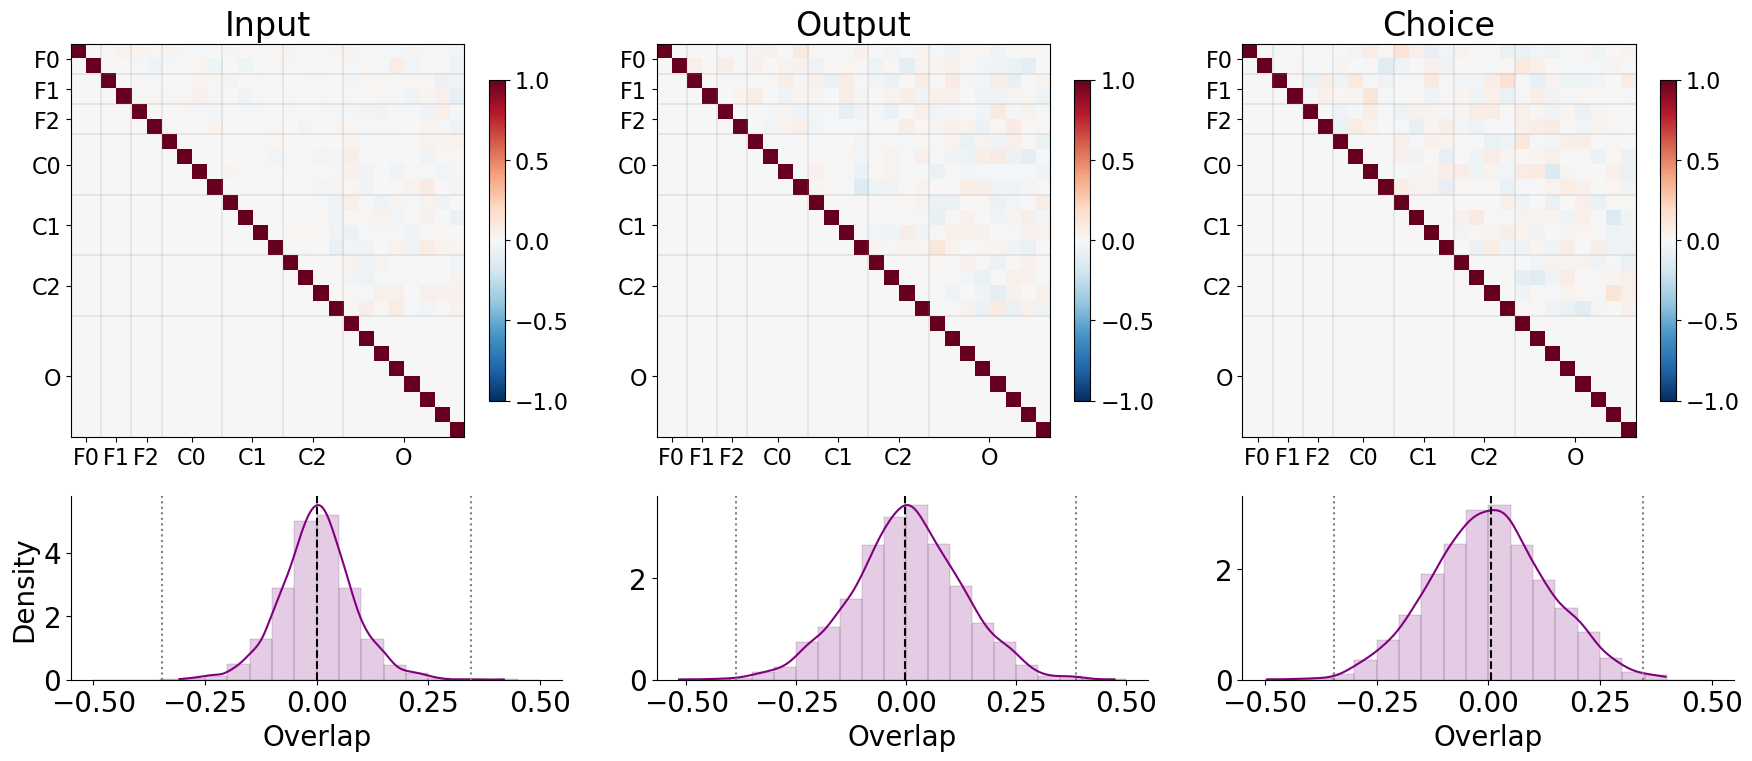

In [32]:
from statsmodels.stats.multitest import fdrcorrection

def test_dpca_overlap(all_dpca_results, keys, all_low_hs, overlap_scale, label, axes):
    
    all_model_axes_overlap = []
    all_model_flat_overlap = []
    all_model_low_hs_corr_val = []
    all_model_pvals = []
    all_model_axes = []
    for dpca_result, low_hs in zip(all_dpca_results, all_low_hs):
        all_dpca_axes = np.concatenate([dpca_result.P[k] for k in keys], axis=1) # concat all axes
        all_dpca_low_hs = np.concatenate([low_hs[k].reshape((low_hs[k].shape[0],-1)) 
                                          for k in keys], axis=0) # concat all axes
        low_hs_corr_val = np.corrcoef(all_dpca_low_hs)
        axes_overlap = all_dpca_axes.T@all_dpca_axes # dot product similarity
        axes_corr_val, axes_corr_ps = spearmanr(all_dpca_axes, axis=0) # rank correlation similarity
        all_overlaps = []
        all_pvals = []
        sig_thresh = np.abs(norm.ppf(0.001))*overlap_scale
        for k_idx1 in range(len(keys)):
            for k_idx2 in range(k_idx1+1, len(keys)):
                pair_overlaps = (dpca_result.P[keys[k_idx1]].T@dpca_result.P[keys[k_idx2]]).flatten()
                all_overlaps.append(pair_overlaps)
                all_pvals.append(norm.cdf(-np.abs(pair_overlaps), loc=0, scale=overlap_scale)+ \
                    norm.sf(np.abs(pair_overlaps), loc=0, scale=overlap_scale))
        all_overlaps = np.concatenate(all_overlaps)
        all_pvals = np.concatenate(all_pvals)
        _, all_corrected_pvals = fdrcorrection(all_pvals)
        
        all_model_axes.append(all_dpca_axes)
        all_model_axes_overlap.append(axes_overlap)
        all_model_pvals.append(all_pvals)
        all_model_flat_overlap.append(all_overlaps)
        all_model_low_hs_corr_val.append(low_hs_corr_val)
        
    all_model_axes = np.stack(all_model_axes)
    all_model_axes_overlap = np.stack(all_model_axes_overlap)
    all_model_pvals = np.stack(all_model_pvals)
    all_model_flat_overlap = np.stack(all_model_flat_overlap)
    all_model_low_hs_corr_val = np.stack(all_model_low_hs_corr_val)
        
    tril_mask = np.zeros_like(all_model_axes_overlap.mean(0))
    tril_mask[np.tril_indices(axes_overlap.shape[0], k=-1)] = 1

    triu_mask = np.zeros_like(all_model_axes_overlap.mean(0))
    triu_mask[np.triu_indices(axes_overlap.shape[0], k=0)] = 1
    
    # plot overlap values
    im = axes[0].imshow(all_model_axes_overlap.mean(0)*triu_mask+\
                   all_model_low_hs_corr_val.mean(0)*tril_mask, \
                   cmap='RdBu_r', vmin=-1, vmax=1)
    cb=plt.colorbar(im, shrink=0.7)
    cb.ax.tick_params(labelsize=16)
    
    txs, tys = np.meshgrid(np.arange(axes_overlap.shape[0]),np.arange(axes_overlap.shape[0]))
    txs = txs[(np.abs(all_model_axes_overlap.mean(0))>sig_thresh)]
    tys = tys[(np.abs(all_model_axes_overlap.mean(0))>sig_thresh)]
    
    block_boundaries = np.cumsum(list(n_components_for_dpca.values()))[:-1]-0.5
    for i in block_boundaries:
        axes[0].axvline(x=i,color='grey',linewidth=0.2)
        axes[0].axhline(y=i,color='grey',linewidth=0.2)
        
    tick_locs = np.cumsum([0, *n_components_for_dpca.values()])[:-1]+np.array(list(n_components_for_dpca.values()))//2-0.5

    axes[0].set_xticks(tick_locs, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)
    axes[0].set_yticks(tick_locs, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=16)
    
    for (x,y) in zip(txs, tys):
        if x<=y:
            continue
        else:
            axes[0].text(x-0.4, y+0.7, '*', {'size': 16})
    
    sns.histplot(x=all_model_flat_overlap.flatten(), color='purple',ax=axes[1], stat='density', 
                 kde=True, bins=np.linspace(-0.5,0.5,21), linewidth=0.1, alpha=0.2)
    axes[1].set_xlabel('Overlap')
    axes[1].axvline(sig_thresh, color='grey', linestyle=':')
    axes[1].axvline(all_overlaps.mean(), color='black', linestyle='--')
    axes[1].axvline(-sig_thresh, color='grey', linestyle=':')
    
    
    axes[0].set_title(label, fontsize=24)
    
    axes[1].spines[['right', 'top']].set_visible(False)
    
    print(f"{(all_model_pvals.flatten()<0.05).sum()} out of {np.prod(all_model_pvals.shape)} comparisons were significant")
    
    return all_model_axes
    
    
fig, axes = plt.subplots(2, 3, height_ratios=(2.5, 1), figsize=(18, 8))
    
all_model_dpca_axes_in = test_dpca_overlap(all_model_dpca_in, ['s','p','c','pc','sc','sp','spc'], 
                              all_model_low_input, 1/np.sqrt(args['hidden_size']), 
                              "Input", axes[:,0])
all_model_dpca_axes_out = test_dpca_overlap(all_model_dpca_out, ['s','p','c','pc','sc','sp','spc'], 
                              all_model_low_output, 1/np.sqrt(int(args['hidden_size']*args['e_prop'])), 
                              "Output", axes[:,1])
all_model_dpca_axes_ch = test_dpca_overlap(all_model_dpca_ch, ['s','p','c','pc','sc','sp','spc'], 
                              all_model_low_ch, 1/np.sqrt(args['hidden_size']), 
                              "Choice", axes[:,2])
axes[1,1].set_ylabel(" ")
axes[1,2].set_ylabel(" ")


plt.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/fixed_weight_axis_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/fixed_weight_axis_overlap.pdf')

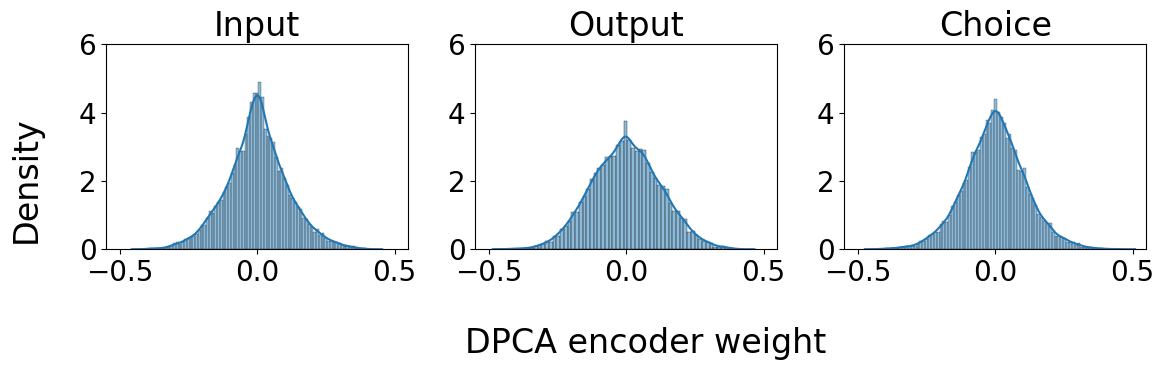

In [33]:
fig, axes = plt.subplots(1,3,figsize=(12, 4))

sns.histplot(x=all_model_dpca_axes_in.flatten(), stat='density', kde=True, ax=axes[0])
axes[0].set_title('Input')
sns.histplot(x=all_model_dpca_axes_out[:,:E_SIZE,:].flatten(), stat='density', kde=True, ax=axes[1])
axes[1].set_title('Output')
sns.histplot(x=all_model_dpca_axes_ch.flatten(), stat='density', kde=True, ax=axes[2])
axes[2].set_title('Choice')

fig.supxlabel('DPCA encoder weight', y=0.05, x=0.55)
fig.supylabel('Density')

for i in range(3):
    axes[i].set_ylabel("")
    axes[i].set_xlim([-0.55, 0.55])
    axes[i].set_ylim([0, 6])

plt.tight_layout()

# Analysis of Naive Weights of RNN

MannwhitneyuResult(statistic=672131.0, pvalue=2.4302378244728604e-133)
MannwhitneyuResult(statistic=674385.0, pvalue=3.8443140153274355e-135)
MannwhitneyuResult(statistic=669408.0, pvalue=3.5065881093798954e-131)
Figure saved at plots/no_rwd_input_large_rate_reg/recurrent_transform_overlap.pdf


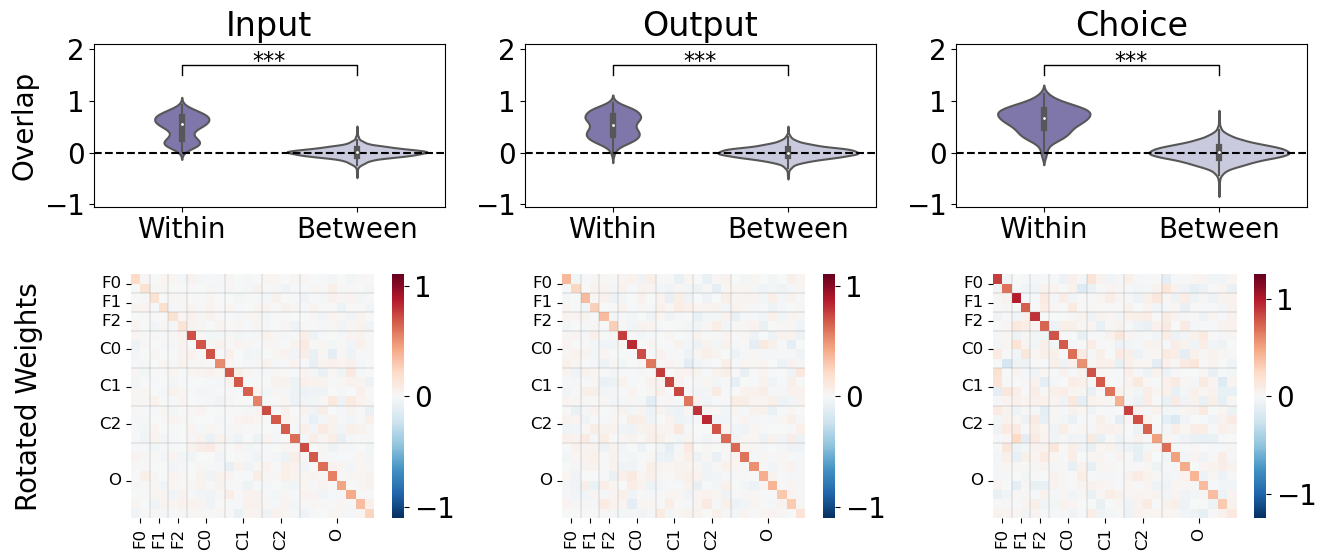

In [34]:
def plot_recurrence(all_model_dpca_axes, all_model_rec_intra, axes, title, cmap_scale):
    all_model_rec_overlap = []
    all_model_overlap_within = []
    all_model_overlap_between = []
    for (all_dpca_axes, rec_intra) in zip(all_model_dpca_axes, all_model_rec_intra):
        num_components = all_dpca_axes.shape[1]
        rec_overlap = all_dpca_axes.T@rec_intra.detach().numpy()@all_dpca_axes
        all_model_rec_overlap.append(rec_overlap)
        all_model_overlap_within.append(np.diag(rec_overlap))
        all_model_overlap_between.append(rec_overlap[np.triu_indices(num_components, k=1)])
        
    all_model_rec_overlap = np.stack(all_model_rec_overlap)
    all_model_overlap_within = np.stack(all_model_overlap_within)
    all_model_overlap_between = np.stack(all_model_overlap_between)
        
#     im=axes[1].imshow(all_model_rec_overlap.mean(0), vmin=-cmap_scale, vmax=cmap_scale, cmap='RdBu_r')
    sns.heatmap(all_model_rec_overlap.mean(0), ax=axes[1], vmin=-cmap_scale, vmax=cmap_scale, cmap='RdBu_r', 
                     square=True, annot_kws={'fontdict':{'fontsize':10}}, cbar_kws={"shrink": 1})
    cb=plt.colorbar(im, shrink=0.8)
    cb.ax.tick_params(labelsize=12)
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    sns.violinplot(ax=axes[0], 
        x=['Within']*np.prod(all_model_overlap_within.shape).astype(int)\
                   +['Between']*np.prod(all_model_overlap_between.shape).astype(int),
        y=np.concatenate([all_model_overlap_within.flatten(), all_model_overlap_between.flatten()]),
        palette=sns.color_palette('Purples_r', 2))
    
    temp_stats = stats.mannwhitneyu(all_model_overlap_within.flatten(), all_model_overlap_between.flatten())
    
    
#     axes[0].text(0.5, 1.1, f"p={np.format_float_scientific(temp_stats.pvalue, precision=2)}", fontsize=16)
    axes[0].axhline(0, linestyle='--', color='k')
    axes[0].set_xlim([-0.5, 1.5])
    axes[0].set_ylim([-1.05, 2.1])
    axes[0].set_yticks(np.arange(-1, 3))
    axes[0].set_ylabel("")
    axes[0].set_title(title)
    print(temp_stats)
    
    axes[0].plot([0, 0, 1, 1], [1.5, 1.7, 1.7, 1.5], lw=1, c='k')
    axes[0].text(0.5, 1.55, convert_pvalue_to_asterisks(temp_stats.pvalue), 
                 ha='center', va='bottom', c='k', fontsize=16)
    

fig, axes = plt.subplots(2,3, figsize=(14, 6), height_ratios=[1, 1.5])


plot_recurrence(all_model_dpca_axes_in, [rec_intra[0] for rec_intra in all_model_rec_intra], 
                axes[:,0], "Input", 1.1)
plot_recurrence(all_model_dpca_axes_out, [rec_intra[1] for rec_intra in all_model_rec_intra], 
                axes[:,1], "Output", 1.1)
plot_recurrence(all_model_dpca_axes_ch, [rec_intra[1] for rec_intra in all_model_rec_intra], 
                axes[:,2], "Choice", 1.25)


axes[0,0].set_ylabel('Overlap')
axes[1,0].set_ylabel('Rotated Weights', labelpad=40)

for j in range(3):
    block_boundaries = np.cumsum(list(n_components_for_dpca.values()))[:-1]
    for i in block_boundaries:
        axes[1,j].axvline(x=i,color='grey',linewidth=0.2)
        axes[1,j].axhline(y=i,color='grey',linewidth=0.2)
    tick_locs = np.cumsum([0, *n_components_for_dpca.values()])[:-1]+np.array(list(n_components_for_dpca.values()))//2
    axes[1,j].set_xticks(tick_locs, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=12)
    axes[1,j].set_yticks(tick_locs, ['F0', 'F1', 'F2', 'C0', 'C1', 'C2', 'O'], size=12)

fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/recurrent_transform_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/recurrent_transform_overlap.pdf')


MannwhitneyuResult(statistic=11907.0, pvalue=1.4799322483521023e-32)
MannwhitneyuResult(statistic=11907.0, pvalue=1.4799322483521023e-32)
MannwhitneyuResult(statistic=11907.0, pvalue=1.4799322483521023e-32)
Figure saved at plots/no_rwd_input_large_rate_reg/interareal_transform_overlap.pdf


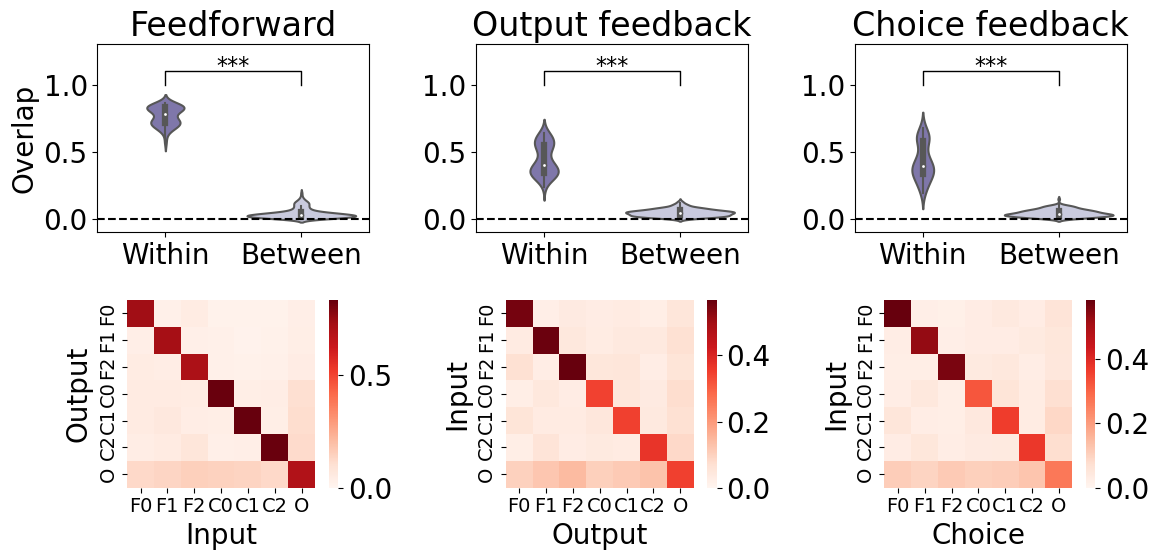

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(12,6), height_ratios=(1,1))

def plot_ff_fb(all_model_dpca_pre, all_model_dpca_post, all_model_rec_inter, 
               axes, title, pre_label, post_label):

    all_model_explained_vars = []
    all_model_vars_within = []
    all_model_vars_between = []
    
    for (dpca_pre, dpca_post, rec_inter) in zip(all_model_dpca_pre, all_model_dpca_post, all_model_rec_inter):
        
        explained_vars = np.zeros((7,7))

        for k_in_idx, k_in in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
            currents = rec_inter.detach().numpy()@dpca_pre.P[k_in]
            currents = currents-currents.mean(1, keepdims=True)
            for k_out_idx, k_out in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
                explained_vars[k_out_idx][k_in_idx] = \
                    1-(np.sum((currents-dpca_post.P[k_out]@dpca_post.P[k_out].T@currents)**2))\
                        /np.sum(currents**2)

        all_model_explained_vars.append(explained_vars)
        all_model_vars_within.append(np.diag(explained_vars))
        all_model_vars_between.append(explained_vars[np.triu_indices(7, k=1)])
        
    all_model_explained_vars = np.stack(all_model_explained_vars)
    all_model_vars_within = np.stack(all_model_vars_within)
    all_model_vars_between = np.stack(all_model_vars_between)
    
    cm = sns.heatmap(all_model_explained_vars.mean(0), ax=axes[1], vmin=0, vmax=None, cmap='Reds', 
                     square=True, annot_kws={'fontdict':{'fontsize':10}}, cbar_kws={"shrink": 1})
    # fig.colorbar(cm,fraction=0.046, pad=0.04)
    axes[1].set_ylabel(post_label)
    axes[1].set_xlabel(pre_label)
    
    sns.violinplot(ax=axes[0], 
        x=['Within']*np.prod(all_model_vars_within.shape).astype(int)\
                   +['Between']*np.prod(all_model_vars_between.shape).astype(int),
        y=np.concatenate([all_model_vars_within.flatten(), all_model_vars_between.flatten()]),
        palette=sns.color_palette('Purples_r', 2))
    
    temp_stats = stats.mannwhitneyu(all_model_vars_within.flatten(), all_model_vars_between.flatten())
    
    
#     axes[0].text(0.5, 1.1, f"p={np.format_float_scientific(temp_stats.pvalue, precision=2)}", fontsize=16)
    axes[0].axhline(0, linestyle='--', color='k')
    axes[0].set_xlim([-0.5, 1.5])
    axes[0].set_ylim([-.1, 1.3])
#     axes[0].set_yticks(np.arange(0, 2))
    axes[0].set_ylabel("")
    axes[0].set_title(title)
    print(temp_stats)
    
    axes[0].plot([0, 0, 1, 1], [1., 1.1, 1.1, 1.], lw=1, c='k')
    axes[0].text(0.5, 1.05, convert_pvalue_to_asterisks(temp_stats.pvalue), 
                 ha='center', va='bottom', c='k', fontsize=16)

    
plot_ff_fb(all_model_dpca_in, all_model_dpca_out, [rec_inter_ff[0] for rec_inter_ff in all_model_rec_inter_ff],
           axes[:,0], 'Feedforward', 'Input', 'Output')
plot_ff_fb(all_model_dpca_out, all_model_dpca_in, [rec_inter_fb[0] for rec_inter_fb in all_model_rec_inter_fb],
           axes[:,1], 'Output feedback', 'Output', 'Input')
plot_ff_fb(all_model_dpca_ch, all_model_dpca_in, [rec_inter_fb[0] for rec_inter_fb in all_model_rec_inter_fb],
           axes[:,2], 'Choice feedback', 'Choice', 'Input')

for i in range(3):
    axes[1,i].set_xticks(np.arange(0,7)+0.5)
    axes[1,i].set_xticklabels(["F0", "F1", "F2", "C0", "C1", "C2", "O"], fontsize=14)
    axes[1,i].set_yticks(np.arange(0,7)+0.5)
    axes[1,i].set_yticklabels(["F0", "F1", "F2", "C0", "C1", "C2", "O"], fontsize=14)

axes[0,0].set_ylabel('Overlap')
# axes[1,0].set_ylabel('Rotated Weights', labelpad=40)
    
fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/interareal_transform_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{plot_save_dir}/interareal_transform_overlap.pdf')


# Analysis of learning rate matrix of the recurrent weights

Figure saved at plots/exp/test0/hebbian_learning_overlap.pdf


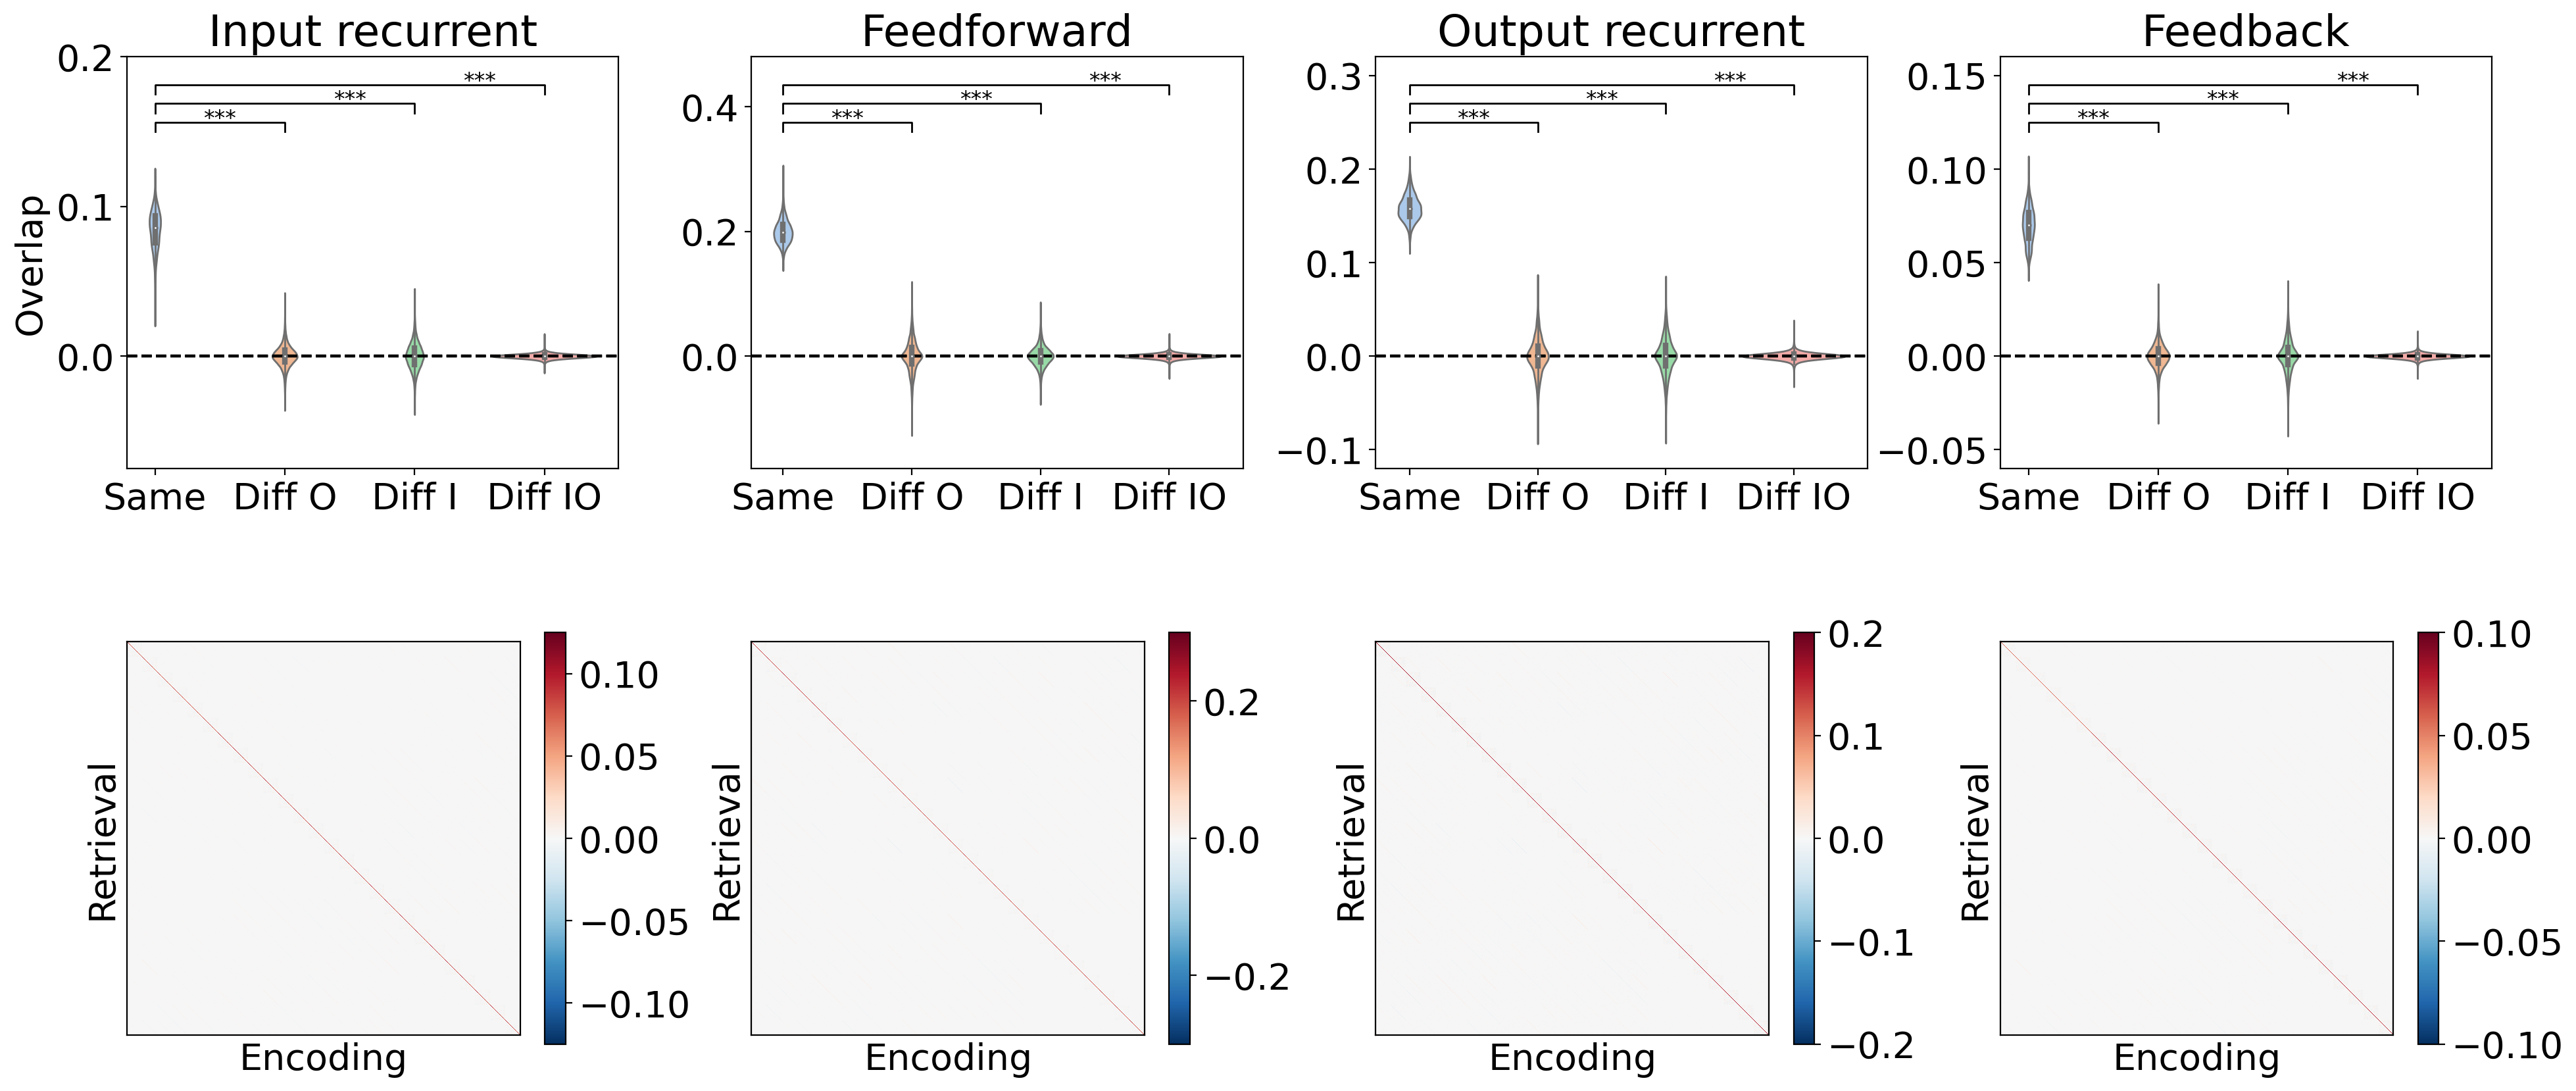

In [36]:
fig, axes = plt.subplots(2,4, figsize=(20, 10), height_ratios=(1, 2), dpi=200)


def plot_hebb_overlap(all_model_dpca_axes_pre_enc, all_model_dpca_axes_post_enc, 
                      all_model_dpca_axes_pre_rtv, all_model_dpca_axes_post_rtv, 
                      all_model_kappa_rec, 
                      axes, title, cmap_scale):

    # recurrent plasticity in input area
    all_model_overlaps = {'same_pre_post': [], 'same_pre': [], 'same_post': [], 'diff': []}
    all_model_overlaps_mat = []
        
    
    for all_dpca_axes_pre_enc, all_dpca_axes_post_enc, \
        all_dpca_axes_pre_rtv, all_dpca_axes_post_rtv, kappa_rec in \
            zip(all_model_dpca_axes_pre_enc, all_model_dpca_axes_post_enc, \
                all_model_dpca_axes_pre_rtv, all_model_dpca_axes_post_rtv, all_model_kappa_rec):
        
        overlaps = {'same_pre_post': [], 'same_pre': [], 'same_post': [], 'diff': []}
        num_axis = all_dpca_axes_pre_enc.shape[1]
        overlap_mat = np.zeros((num_axis**2, num_axis**2))
        
        for i in range(num_axis):
            for j in range(num_axis):
                # calculate hebbian memory
                mem_mat = kappa_rec.numpy()*(all_dpca_axes_post_enc[:,i:i+1]@all_dpca_axes_pre_enc[:,j:j+1].T)
                for k in range(num_axis):
                    for l in range(num_axis):
                        curr_overlap = all_dpca_axes_post_rtv[:,k:k+1].T@mem_mat@all_dpca_axes_pre_rtv[:,l:l+1]
                        if i==k and j==l:
                            overlaps['same_pre_post'].append(curr_overlap)
                        elif j==l:
                            overlaps['same_pre'].append(curr_overlap)
                        elif i==k:
                            overlaps['same_post'].append(curr_overlap)
                        else:
                            overlaps['diff'].append(curr_overlap)
                            
                        overlap_mat[k*num_axis+l, i*num_axis+j] = curr_overlap
                                            
        for k, v in overlaps.items():
            all_model_overlaps[k].append(v)
        all_model_overlaps_mat.append(overlap_mat)
    
    for k, v in overlaps.items():
        all_model_overlaps[k] = np.stack(all_model_overlaps[k])
    all_model_overlaps_mat = np.stack(all_model_overlaps_mat)
        
    im=axes[1].imshow(all_model_overlaps_mat.mean(0), 
                      vmin=-cmap_scale, vmax=cmap_scale, 
                      cmap='RdBu_r', interpolation='nearest')
    plt.colorbar(im, shrink=0.5)
#     axes[1].axis('off')
    axes[1].set_yticks([])
    axes[1].set_xticks([])
    axes[1].set_ylabel('Retrieval')
    axes[1].set_xlabel('Encoding')
        
    sns.violinplot(ax=axes[0],
                  x=['Same']*np.prod(all_model_overlaps['same_pre_post'].shape)+\
                   ['Diff O']*np.prod(all_model_overlaps['same_pre'].shape)+
                   ['Diff I']*np.prod(all_model_overlaps['same_post'].shape)+\
                   ['Diff IO']*np.prod(all_model_overlaps['diff'].shape),
                  y=np.concatenate([all_model_overlaps['same_pre_post'].flatten(),
                                   all_model_overlaps['same_pre'].flatten(),
                                   all_model_overlaps['same_post'].flatten(),
                                   all_model_overlaps['diff'].flatten()]),
                  palette=sns.color_palette('pastel'), linewidth=1)
    axes[0].axhline(0, linestyle = '--', color='k')
    axes[0].set_title(title)
    axes[0].set_ylim([-cmap_scale*0.6, cmap_scale*1.6])
    
    for key_idx, key in enumerate(['same_pre', 'same_post', 'diff']):
        temp_stats = stats.mannwhitneyu(all_model_overlaps['same_pre_post'].flatten(), 
                                        all_model_overlaps[key].flatten())

        axes[0].axhline(0, linestyle='--', color='k')
        
        unit_len = cmap_scale/10
        
        bar_bottom = cmap_scale+unit_len*(key_idx+2)
        bar_top = cmap_scale+unit_len*(key_idx+2.5)
        
        axes[0].plot([0, 0, key_idx+1, key_idx+1], 
                     [bar_bottom, bar_top, bar_top, bar_bottom], lw=1, c='k')
        axes[0].text(0.5+key_idx, bar_bottom+unit_len/10, 
                     convert_pvalue_to_asterisks(temp_stats.pvalue), 
                     ha='center', va='bottom', c='k', fontsize=12)
    
    

plot_hebb_overlap(all_model_dpca_axes_in, all_model_dpca_axes_in, 
                  all_model_dpca_axes_in, all_model_dpca_axes_in, 
                  [kappa_rec_intra[0] for kappa_rec_intra in all_model_kappa_rec_intra],
                 axes[:,0], 'Input recurrent', 0.125)

plot_hebb_overlap(all_model_dpca_axes_in, all_model_dpca_axes_out, 
                  all_model_dpca_axes_in, all_model_dpca_axes_out, 
                  [kappa_inter_ff[0] for kappa_inter_ff in all_model_kappa_inter_ff],
                 axes[:,1], 'Feedforward', 0.3)

plot_hebb_overlap(all_model_dpca_axes_out, all_model_dpca_axes_out, 
                  all_model_dpca_axes_out, all_model_dpca_axes_out, 
                  [kappa_rec_intra[1] for kappa_rec_intra in all_model_kappa_rec_intra],
                 axes[:,2],'Output recurrent', 0.2)

plot_hebb_overlap(all_model_dpca_axes_out, all_model_dpca_axes_in, 
                  all_model_dpca_axes_out, all_model_dpca_axes_in, 
                  [kappa_inter_fb[0] for kappa_inter_fb in all_model_kappa_inter_fb],
                 axes[:,3],'Feedback', 0.1)


axes[0,0].set_ylabel('Overlap')
# axes[1,0].set_ylabel('Retrieval')
# fig.supxlabel('Encoding')

fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/hebbian_learning_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/hebbian_learning_overlap.pdf')


# dPCA Analysis of the Activity of the RNN

In [19]:
def get_area_ei_indices(args, ind_area):
    hidden_size_per_area = args['hidden_size']
    E_SIZE = round(args['hidden_size']*args['e_prop'])
    I_SIZE = round(args['hidden_size']*(1-args['e_prop']))
    NUM_AREAS = args['num_areas']
    return np.concatenate([np.arange(E_SIZE*ind_area, E_SIZE*(ind_area+1)), 
                           np.arange(E_SIZE*NUM_AREAS+I_SIZE*ind_area, E_SIZE*NUM_AREAS+I_SIZE*(ind_area+1))])

def make_dpca_results(Xs, labels, n_components):
    all_non_time_labels = labels
    join_dict = {}
    for r in range(1, len(labels)+1):
        for label in list(itertools.combinations(all_non_time_labels, r)):
            label_str = ''.join(label)
            join_dict['t'+label_str] = [label_str, 't'+label_str]
#             print(join_dict)

    dpca_model = dPCA.dPCA('t'+labels, join=join_dict, n_components=n_components)
    low_hs = dpca_model.fit_transform(Xs)

    all_axes = []
    all_explained_vars = []
    all_labels = []
    for k in dpca_model.marginalized_psth.keys():
        eff_components = np.sum(np.array(dpca_model.explained_variance_ratio_[k])>0.00)
        all_explained_vars.append(dpca_model.explained_variance_ratio_[k][:eff_components])
#         print(f"Variance explained by {eff_components} of {k}: {np.round(100*np.array(dpca_model.explained_variance_ratio_[k]),4)} %")
        all_axes.append(dpca_model.P[k][:,:eff_components])
        all_labels += [k]*eff_components

    all_axes = np.concatenate(all_axes, axis=1)
    all_explained_vars = np.concatenate(all_explained_vars, axis=0)

    dpca_results = {}
    dpca_results['low_hs'] = low_hs
    dpca_results['encoding_axes'] = dpca_model.P
    dpca_results['explained_variances'] = dpca_model.explained_variance_ratio_
    dpca_results['marginalized_psth'] = dpca_model.marginalized_psth

    return dpca_results

def get_dpca_by_area(all_saved_states, task_mdprl, args, 
                     trials_to_fit, area_to_fit, model_to_fit):
    '''
    (1) regress hs activity with
            previous trial choice shape, color, pattern (3x3x3), 
            previous trial reward (2),
            current trial stimuli shape, color, pattern pairs (3x3x3), 
            current trial choice shape, color, pattern (3x3x3), 
            current trial reward (2),
    (2) get beta weights which is a mixture of value and stimulus intensity: h ~ Xw. 
        This will give beta weights timepoints X trials X hidden X latent variables,
        calculate cpd gives timepoints X trials X hidden X latent variables CPD values
    (3) compare w with marginal reward probability? see which it dimension it corresponds to the best
    '''
    
    n_trials, n_timesteps, n_sessions, n_hidden = all_saved_states['hs'].shape
    n_areas = args['num_areas'] 
    n_hidden = n_hidden//n_areas

    area_inds = get_area_ei_indices(args, area_to_fit)
    sessions_to_fit = all_saved_states['model_assignment'].astype(int)==model_to_fit
    num_sessions_to_fit = np.sum(sessions_to_fit)

    area_hs = all_saved_states['hs'][...,area_inds]
    num_trials_to_fit = len(trials_to_fit)

#     print("Calculating PSTH by prev trial")

    '''
    organize by previous trial outcome
    '''
    hs_by_prev = np.zeros((n_hidden, n_timesteps, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes
    
    flat_hs_post = area_hs.numpy()[trials_to_fit[1:],...][:,:,sessions_to_fit]\
                        .transpose((2,0,1,3)).reshape((num_sessions_to_fit*(num_trials_to_fit-1), n_timesteps, n_hidden))
    flat_rwds_pre = all_saved_states['rewards'].numpy()[trials_to_fit[:-1],...][:,:,sessions_to_fit]\
                        .transpose((2,0,1)).reshape((num_sessions_to_fit*(num_trials_to_fit-1))).astype(int)
    flat_acts_pre = all_saved_states['choices'].numpy()[trials_to_fit[:-1],...][:,:,sessions_to_fit]\
                        .transpose((2,0,1)).reshape((num_sessions_to_fit*(num_trials_to_fit-1))).astype(int)

    # the prev_f{}_vals are IN TERMS OF THE REWARD SCHEDULE, NOT THE PERCEPTUAL DIMENSIONS

    act_f1_val = task_mdprl.index_shp[flat_acts_pre]
    act_f2_val = task_mdprl.index_pttrn[flat_acts_pre]
    act_f3_val = task_mdprl.index_clr[flat_acts_pre]

    n_components_for_dpca_by_prev = {'t':3, 'tr':1, 'ts':2, 'tp':2, 'tc':2, 
                                             'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8,
                                             'trs':2, 'trp':2, 'trc':2, 
                                             'trsp':4, 'trsc':4, 'trpc':4, 'trspc': 8}
    
    for prev_rwd_val in range(2):
        for prev_f1_val in range(3): 
            for prev_f2_val in range(3):
                for prev_f3_val in range(3):
                    # n_trials, 1, n_sessions, ...
                    where_trial = (flat_rwds_pre==prev_rwd_val) & \
                                  (act_f1_val==prev_f1_val) & \
                                  (act_f2_val==prev_f2_val) & \
                                  (act_f3_val==prev_f3_val)
                    hs_by_prev[:, :, prev_rwd_val, prev_f1_val, prev_f2_val, prev_f3_val] = \
                        flat_hs_post[where_trial,...].mean(0).T
                        

    del flat_hs_post
    del flat_rwds_pre
    del flat_acts_pre
    
    '''
    organize by current trial stimuli
    '''
#     print("Calculating PSTH by current trial stimuli")

    n_components_for_dpca_by_curr_stim = {'t':5, 'ts':2, 'tp':2, 'tc':2, 
                                          'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8}

    hs_by_curr_stim = np.zeros((n_hidden, n_timesteps, 6, 6, 6)) # sort data by current trial choices and outcomes

    flat_hs_curr = area_hs[trials_to_fit][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1,3)).reshape((num_sessions_to_fit*num_trials_to_fit, n_timesteps, n_hidden))
    flat_stims = all_saved_states['stimuli'][trials_to_fit][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1,3)).reshape((num_sessions_to_fit*num_trials_to_fit, 2)).astype(int)

    pair_to_ind = {(0,1): 0, (1,0): 1, (0,2): 2, (2,0): 3, (1,2): 4, (2,1): 5}

    stim_f1_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f2_val = np.ones_like(flat_stims[:,0])*np.nan
    stim_f3_val = np.ones_like(flat_stims[:,0])*np.nan
    
    for k, v in pair_to_ind.items():
        stim_f1_val[(task_mdprl.index_shp[flat_stims[:,0]]==k[0]) & (task_mdprl.index_shp[flat_stims[:,1]]==k[1])] = v
        stim_f2_val[(task_mdprl.index_pttrn[flat_stims[:,0]]==k[0]) & (task_mdprl.index_pttrn[flat_stims[:,1]]==k[1])] = v
        stim_f3_val[(task_mdprl.index_clr[flat_stims[:,0]]==k[0]) & (task_mdprl.index_clr[flat_stims[:,1]]==k[1])] = v
    
    for curr_f1_val in range(6):
        for curr_f2_val in range(6):
            for curr_f3_val in range(6):
                # n_trials, 1, n_sessions, ...
                where_trial = (stim_f1_val==curr_f1_val) & \
                              (stim_f2_val==curr_f2_val) & \
                              (stim_f3_val==curr_f3_val)
                hs_by_curr_stim[:, :, curr_f1_val, curr_f2_val, curr_f3_val] = \
                    flat_hs_curr[where_trial,...].mean(0).T

    del flat_stims

    '''
    organize by current trial outcome
    '''
#     print("Calculating PSTH by current trial outcome")

    n_components_for_dpca_by_curr_outcome = {'t':3, 'tr':1, 'ts':2, 'tp':2, 'tc':2, 
                                             'tsp':4, 'tsc':4, 'tpc':4, 'tspc': 8,
                                             'trs':2, 'trp':2, 'trc':2, 
                                             'trsp':4, 'trsc':4, 'trpc':4, 'trspc': 8}

    hs_by_curr_outcome = np.zeros((n_hidden, n_timesteps, 2, 3, 3, 3)) # sort data by previous trial choices and outcomes
    flat_rwds_curr = all_saved_states['rewards'][trials_to_fit,...][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1)).reshape((num_sessions_to_fit*num_trials_to_fit)).astype(int)
    flat_acts_curr = all_saved_states['choices'][trials_to_fit,...][:,:,sessions_to_fit]\
                            .numpy().transpose((2,0,1)).reshape((num_sessions_to_fit*num_trials_to_fit)).astype(int)

    act_f1_val = task_mdprl.index_shp[flat_acts_curr]
    act_f2_val = task_mdprl.index_pttrn[flat_acts_curr]
    act_f3_val = task_mdprl.index_clr[flat_acts_curr]

    for curr_rew_val in range(2):
        for curr_f1_val in range(3):
            for curr_f2_val in range(3):
                for curr_f3_val in range(3):      
                    # n_trials, 1, n_sessions, ...
                    where_trial = (flat_rwds_curr==curr_rew_val) & \
                                  (act_f1_val==curr_f1_val) & \
                                  (act_f2_val==curr_f2_val) & \
                                  (act_f3_val==curr_f3_val)
                    hs_by_curr_outcome[:, :, curr_rew_val, curr_f1_val, curr_f2_val, curr_f3_val] = \
                        flat_hs_curr[where_trial,...].mean(0).T
         
    del flat_hs_curr
    del flat_rwds_curr
    del flat_acts_curr


#     print("-------------------------------------------")
#     print('Calculating DPCA by previous trial outcome')
    dpca_results_by_prev = make_dpca_results(hs_by_prev, "rspc", n_components=n_components_for_dpca_by_prev)
#     print("-------------------------------------------")
#     print('Calculating DPCA by current trial stimuli')
    dpca_results_by_curr_stim = make_dpca_results(hs_by_curr_stim, "spc", n_components=n_components_for_dpca_by_curr_stim)
#     print("-------------------------------------------")
#     print('Calculating DPCA by current trial outcome')
    dpca_results_by_curr_outcome = make_dpca_results(hs_by_curr_outcome, "rspc", n_components=n_components_for_dpca_by_curr_outcome)

#     fig, axes = plt.subplots(2, 2)
#     for i in range(4):
#         plot_mean_and_std(axes[i//2, i%2], all_cpds[i].mean([0, 2]), 
#                           all_cpds[i].std([0, 2])/np.sqrt(n_trials//4*n_batch), label=['F1', 'F2', 'F3', 'C1', 'C2', 'C3', 'O'])
    return dpca_results_by_prev, dpca_results_by_curr_stim, dpca_results_by_curr_outcome

In [20]:
def get_dpca_axes_overlap(dpca_results_row, dpca_results_col,
                          row_keys=['ts','tp','tc','tpc','tsc','tsp','tspc'], 
                          col_keys=['ts','tp','tc','tpc','tsc','tsp','tspc']):
    overlap_mat = np.empty((7,7))
    for k_row_idx, k_row in enumerate(row_keys):
        for k_col_idx, k_col in enumerate(col_keys):
            overlap_mat[k_row_idx, k_col_idx] = \
                np.sum((dpca_results_row[k_row].T@dpca_results_col[k_col])**2)/dpca_results_row[k_row].shape[1]
    return overlap_mat

def get_dpca_exp_var(dpca_results, keys=['ts','tp','tc','tpc','tsc','tsp','tspc']):
    exp_var_mat = np.empty(7)
    for k_idx, k in enumerate(keys):
        exp_var_mat[k_idx] = np.sum(dpca_results['explained_variances'][k])
    return exp_var_mat
    

In [21]:
all_model_curr_stim_overlap = []
all_model_curr_outcome_overlap = []

for idx_model in tqdm.tqdm(range(len(all_models))):
    # iterate all area for each model
    all_area_curr_stim_overlap = []
    all_area_curr_outcome_overlap = [] 
    for idx_area in range(NUM_AREAS):
        # for each area of each network, split into two blocks of trials
        dpca_results_by_curr_stim_split = []
        dpca_results_by_curr_outcome_split = []
        for idx_block in range(2):
            trials_to_fit = np.arange(idx_block*27*8, (idx_block+1)*27*8)
            _, area_dpca_by_curr_stim, area_dpca_by_curr_outcome = \
                            get_dpca_by_area(all_saved_states, task_mdprl, args, 
                                             area_to_fit=idx_area, 
                                             trials_to_fit=trials_to_fit,
                                             model_to_fit=idx_model)
            dpca_results_by_curr_stim_split.append(area_dpca_by_curr_stim)
            dpca_results_by_curr_outcome_split.append(area_dpca_by_curr_outcome)
        
            
        curr_stim_overlap = get_dpca_axes_overlap(dpca_results_by_curr_stim_split[0]['encoding_axes'],
                                                  dpca_results_by_curr_stim_split[1]['encoding_axes'])


        curr_outcome_overlap = get_dpca_axes_overlap(dpca_results_by_curr_outcome_split[0]['encoding_axes'],
                                                     dpca_results_by_curr_outcome_split[1]['encoding_axes'])

        
        all_area_curr_stim_overlap.append(np.stack(curr_stim_overlap))
        all_area_curr_outcome_overlap.append(np.stack(curr_outcome_overlap))
        
    all_model_curr_stim_overlap.append(np.stack(all_area_curr_stim_overlap))
    all_model_curr_outcome_overlap.append(np.stack(all_area_curr_outcome_overlap))
    
all_model_curr_stim_overlap = np.stack(all_model_curr_stim_overlap)
all_model_curr_outcome_overlap = np.stack(all_model_curr_outcome_overlap)
        

 44%|████▍     | 4/9 [00:33<00:41,  8.28s/it]/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:980: RuntimeWarning: invalid value encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]
/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:980: RuntimeWarning: divide by zero encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]
100%|██████████| 9/9 [01:14<00:00,  8.31s/it]


Figure saved at plots/exp/test0/dpca_stability_by_block.pdf


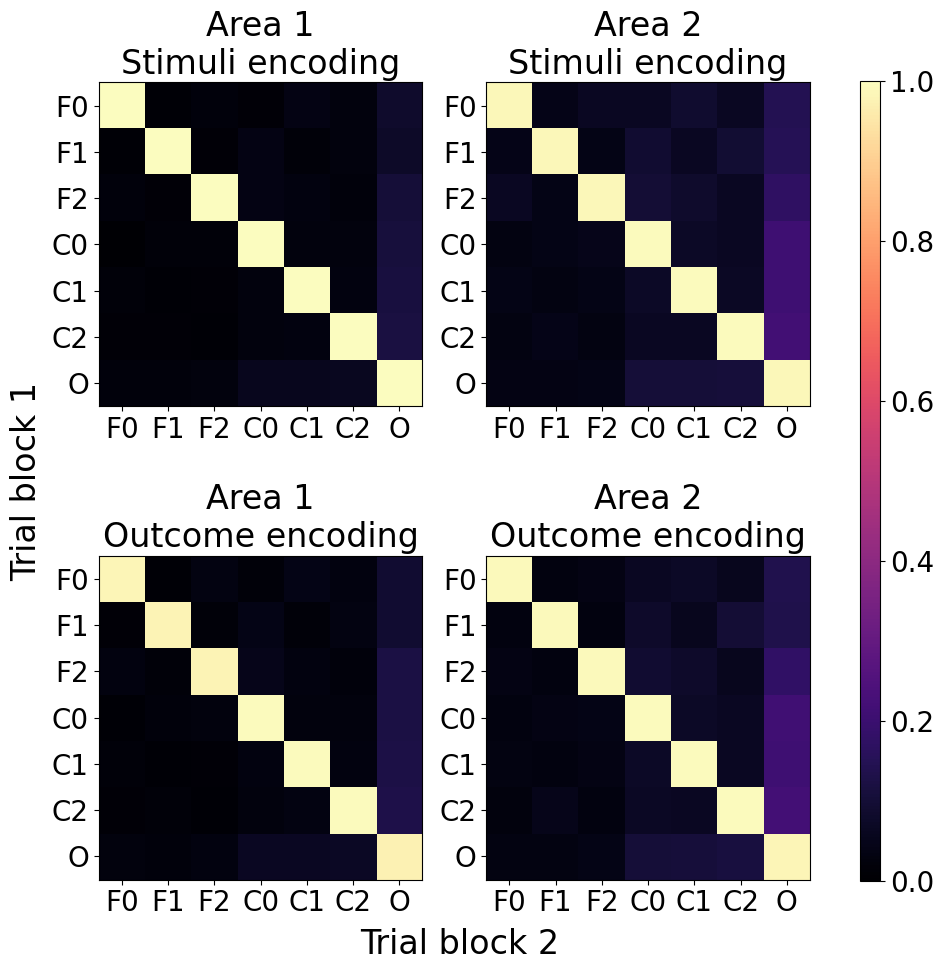

In [22]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))


for area in range(2):
    cm = axes[0,area].imshow(all_model_curr_stim_overlap.mean(0)[area], vmin=0, vmax=1, cmap='magma')  
    axes[0,area].set_xticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
    axes[0,area].set_yticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
    axes[0,area].set_title(f'Area {area+1}\nStimuli encoding')
        
for area in range(2):
    cm = axes[1,area].imshow(all_model_curr_outcome_overlap.mean(0)[area], vmin=0, vmax=1, cmap='magma') 
    axes[1,area].set_xticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
    axes[1,area].set_yticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
    axes[1,area].set_title(f'Area {area+1}\nOutcome encoding')
        
fig.supxlabel("Trial block 2", y=0.02)
fig.supylabel("Trial block 1", x=0.05)
fig.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.85, top=0.9)
cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)


with PdfPages(f'plots/{plot_save_dir}/dpca_stability_by_block.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/dpca_stability_by_block.pdf')



In [23]:
all_model_dpca_curr_stim = []
all_model_dpca_curr_outcome = []

for idx_model in tqdm.tqdm(range(len(all_models))):
    # iterate all area for each model
    all_area_dpca_curr_stim = []
    all_area_dpca_curr_outcome = [] 
    for idx_area in range(NUM_AREAS):
        # for each area of each network, split into two blocks of trials
        trials_to_fit = np.arange(args['test_N_s'])
        _, area_dpca_by_curr_stim, area_dpca_by_curr_outcome = \
                        get_dpca_by_area(all_saved_states, task_mdprl, args, 
                                         area_to_fit=idx_area, 
                                         trials_to_fit=trials_to_fit,
                                         model_to_fit=idx_model)
        
        all_area_dpca_curr_stim.append(area_dpca_by_curr_stim)
        all_area_dpca_curr_outcome.append(area_dpca_by_curr_outcome)
        
    all_model_dpca_curr_stim.append(all_area_dpca_curr_stim)
    all_model_dpca_curr_outcome.append(all_area_dpca_curr_outcome)


 44%|████▍     | 4/9 [00:17<00:21,  4.35s/it]/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:980: RuntimeWarning: invalid value encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]
/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:980: RuntimeWarning: divide by zero encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]
100%|██████████| 9/9 [00:39<00:00,  4.36s/it]


Figure saved at plots/exp/test0/dpca_curr_outcome_overlap.pdf


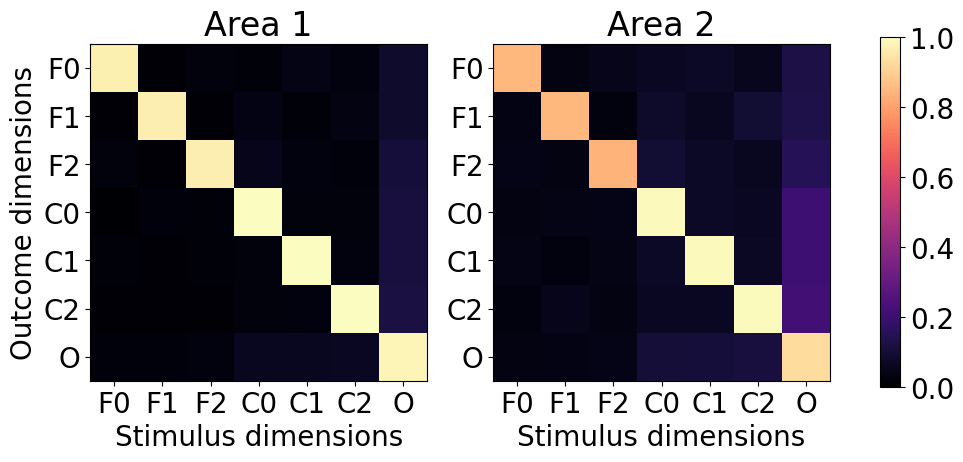

In [24]:
all_model_stim_outcome_overlap = []

fig, axes = plt.subplots(1, 2, figsize=(10, 7))

for idx_model in range(len(all_models)):
    all_areas_stim_outcome_overlap = []
    for idx_area in range(NUM_AREAS):
        stim_outcome_overlap = get_dpca_axes_overlap(all_model_dpca_curr_outcome[idx_model][idx_area]['encoding_axes'],
                                                     all_model_dpca_curr_stim[idx_model][idx_area]['encoding_axes'])
#         for k_outcome_idx, k_outcome in enumerate(['s','p','c','pc','sc','sp','spc']):
#             for k_stim_idx, k_stim in enumerate(['s','p','c','pc','sc','sp','spc']):
#                 stim_outcome_overlap[k_outcome_idx, k_stim_idx] = \
#                     np.sum((all_model_dpca_curr_outcome[idx_model][idx_area]['encoding_axes']['t'+k_outcome].T@\
#                             all_model_dpca_curr_stim[idx_model][idx_area]['encoding_axes']['t'+k_stim])**2)/\
#                     all_model_dpca_curr_stim[idx_model][idx_area]['encoding_axes']['t'+k_stim].shape[1]

        all_areas_stim_outcome_overlap.append(stim_outcome_overlap)
    all_model_stim_outcome_overlap.append(np.stack(all_areas_stim_outcome_overlap))
all_model_stim_outcome_overlap = np.stack(all_model_stim_outcome_overlap)

    
for idx_area in range(NUM_AREAS):
    cm = axes[idx_area].imshow(all_model_stim_outcome_overlap.mean(0)[idx_area], vmin=0, vmax=1, cmap='magma')  
    axes[idx_area].set_xticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
    axes[idx_area].set_yticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"])
    axes[idx_area].set_xlabel("Stimulus dimensions")
    axes[idx_area].set_title(f"Area {idx_area+1}")
    
axes[0].set_ylabel("Outcome dimensions")
    
fig.tight_layout()
    
plt.subplots_adjust(bottom=0.05, right=0.85, top=0.95)
cb_ax = fig.add_axes([0.9, 0.25, 0.02, 0.5])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)


with PdfPages(f'plots/{plot_save_dir}/dpca_curr_outcome_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/dpca_curr_outcome_overlap.pdf')


In [25]:
all_model_weight_dpca_overlap_stim = []
all_model_weight_dpca_overlap_outcome = []


for idx_model in range(len(all_models)):
    
    all_model_weight_dpca_overlap_stim.append(np.stack([
        get_dpca_axes_overlap(all_model_dpca_in[idx_model].P, 
                              all_model_dpca_curr_stim[idx_model][0]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_out[idx_model].P, 
                              all_model_dpca_curr_stim[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_ch[idx_model].P, 
                              all_model_dpca_curr_stim[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc'])
    ]))
    
    all_model_weight_dpca_overlap_outcome.append(np.stack([
        get_dpca_axes_overlap(all_model_dpca_in[idx_model].P, 
                              all_model_dpca_curr_outcome[idx_model][0]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_out[idx_model].P, 
                              all_model_dpca_curr_outcome[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc']),
        get_dpca_axes_overlap(all_model_dpca_ch[idx_model].P, 
                              all_model_dpca_curr_outcome[idx_model][1]['encoding_axes'],
                              ['s','p','c','pc','sc','sp','spc'],
                              ['ts','tp','tc','tpc','tsc','tsp','tspc'])
    ]))
    
all_model_weight_dpca_overlap_stim = np.stack(all_model_weight_dpca_overlap_stim)
all_model_weight_dpca_overlap_outcome = np.stack(all_model_weight_dpca_overlap_outcome)
    
    

Figure saved at plots/exp/test0/dpca_struct_func_overlap.pdf


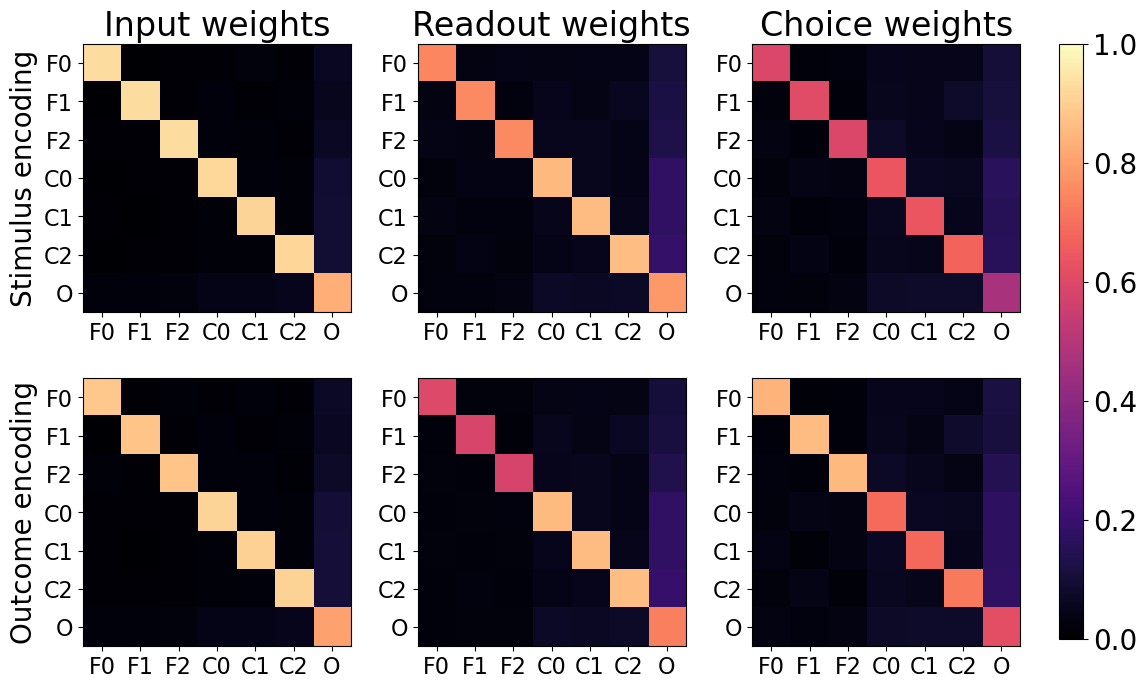

In [26]:
fig, axes = plt.subplots(2, 3, figsize=(12,7))


for i in range(3):
    axes[0,i].imshow(all_model_weight_dpca_overlap_stim.mean(0)[i], vmin=0, vmax=1, cmap='magma')
    axes[1,i].imshow(all_model_weight_dpca_overlap_outcome.mean(0)[i], vmin=0, vmax=1, cmap='magma')

    



for i in range(2):
    for j in range(3):
        axes[i,j].set_xticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"], fontsize=16)
        axes[i,j].set_yticks(np.arange(7),["F0", "F1", "F2", "C0", "C1", "C2", "O"], fontsize=16)

axes[0,0].set_ylabel("Stimulus encoding")
axes[1,0].set_ylabel("Outcome encoding")
axes[0,0].set_title("Input weights")
axes[0,1].set_title("Readout weights")
axes[0,2].set_title("Choice weights")

fig.tight_layout()
plt.subplots_adjust(top=0.95, right=0.88)
cb_ax = fig.add_axes([0.9, 0.1, 0.02, 0.85])
fig.colorbar(cm,fraction=0.046, pad=0.04, cax=cb_ax)

with PdfPages(f'plots/{plot_save_dir}/dpca_struct_func_overlap.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/dpca_struct_func_overlap.pdf')


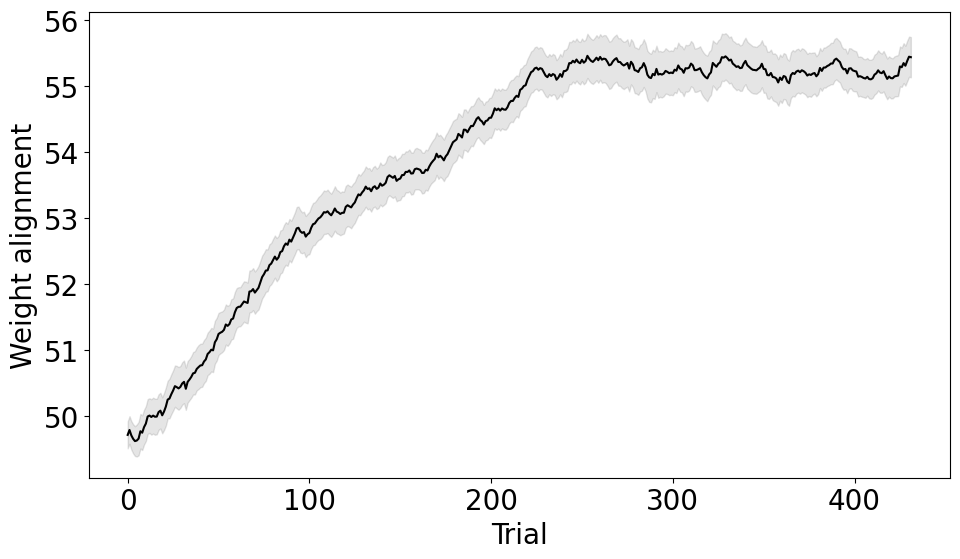

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharey=True)

weight_alignment = np.trace(all_saved_states['whs_final'].squeeze()[...,64:128,:][...,:64]@\
             all_saved_states['whs_final'].squeeze()[...,:64,:][...,64:128], axis1=-2, axis2=-1)

plot_mean_and_std(ax, weight_alignment.mean(1), weight_alignment.std(1)/np.sqrt(weight_alignment.shape[1]), label=None, color='k')
            
ax.set_xlabel('Trial')
ax.set_ylabel('Weight alignment')

fig.tight_layout()

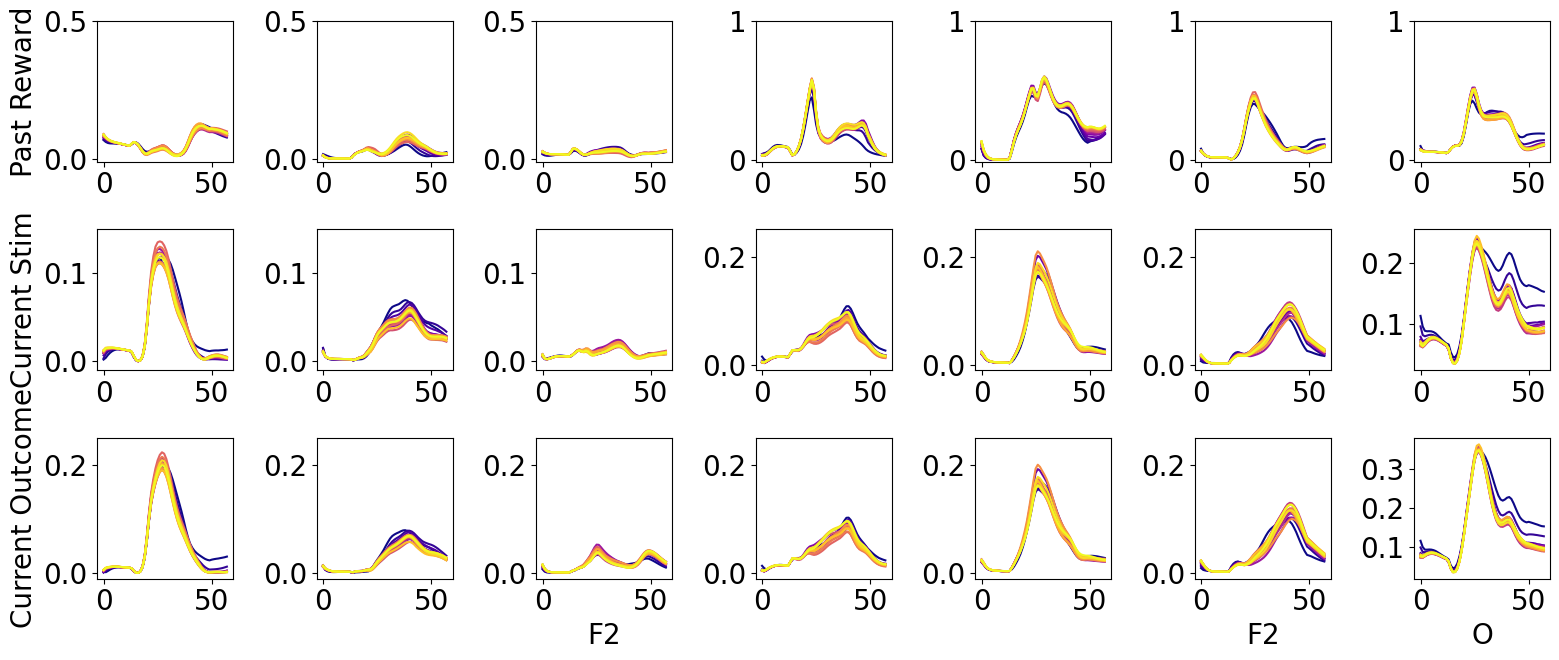

In [182]:
num_blocks = 16
colors = plt.cm.plasma(np.linspace(0,1,num_blocks))

centered_hs = all_saved_states['hs'][:,:,:,input_weight_inds]
total_var = (centered_hs**2).sum(-1)

fig, axes = plt.subplots(3,7, figsize=(16, 7)) # three rows for past, curr stim, curr outcome

'''past reward'''
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[0]['encoding_axes']['tr'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[0,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[0,ft_idx].set_ylim([-0.01, 0.5])

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[0]['encoding_axes']['tr'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[0,3+conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[0,3+conj_idx].set_ylim([-0.01, 1])

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[0]['encoding_axes']['trspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[0,6].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")
axes[0,6].set_ylim([-0.01, 1])
axes[0,0].set_ylabel('Past Reward')

    
'''curr stim''' 
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[0]['encoding_axes']['t'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[1,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[1,ft_idx].set_ylim([-0.01, 0.15])

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[0]['encoding_axes']['t'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[1,3+conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[1,3+conj_idx].set_ylim([-0.01, 0.25])

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[0]['encoding_axes']['tspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[1,6].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")

axes[1,0].set_ylabel('Current Stim')
    
'''curr outcome''' 
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[0]['encoding_axes']['t'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[2,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[2,ft_idx].set_ylim([-0.01, 0.25])
axes[2,ft_idx].set_xlabel(f"F{ft_idx}")

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[0]['encoding_axes']['t'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[2,3+conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[2,3+conj_idx].set_ylim([-0.01, 0.25])
axes[2,3+conj_idx].set_xlabel(f"F{conj_idx}")

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[0]['encoding_axes']['tspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[2,6].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")
axes[2,6].set_xlabel("O")    

axes[2,0].set_ylabel('Current Outcome')


# plt.plot(avg_corr/27, label='O')
# plt.legend(ncol=1)
# plt.ylabel('Cosine similarity')
# plt.xlabel('Timesteps')
# plt.yticks(np.linspace(-0.2, 1.0, 7))
# plt.title('Choice encoding of input area driven by input connectivity')
plt.tight_layout()

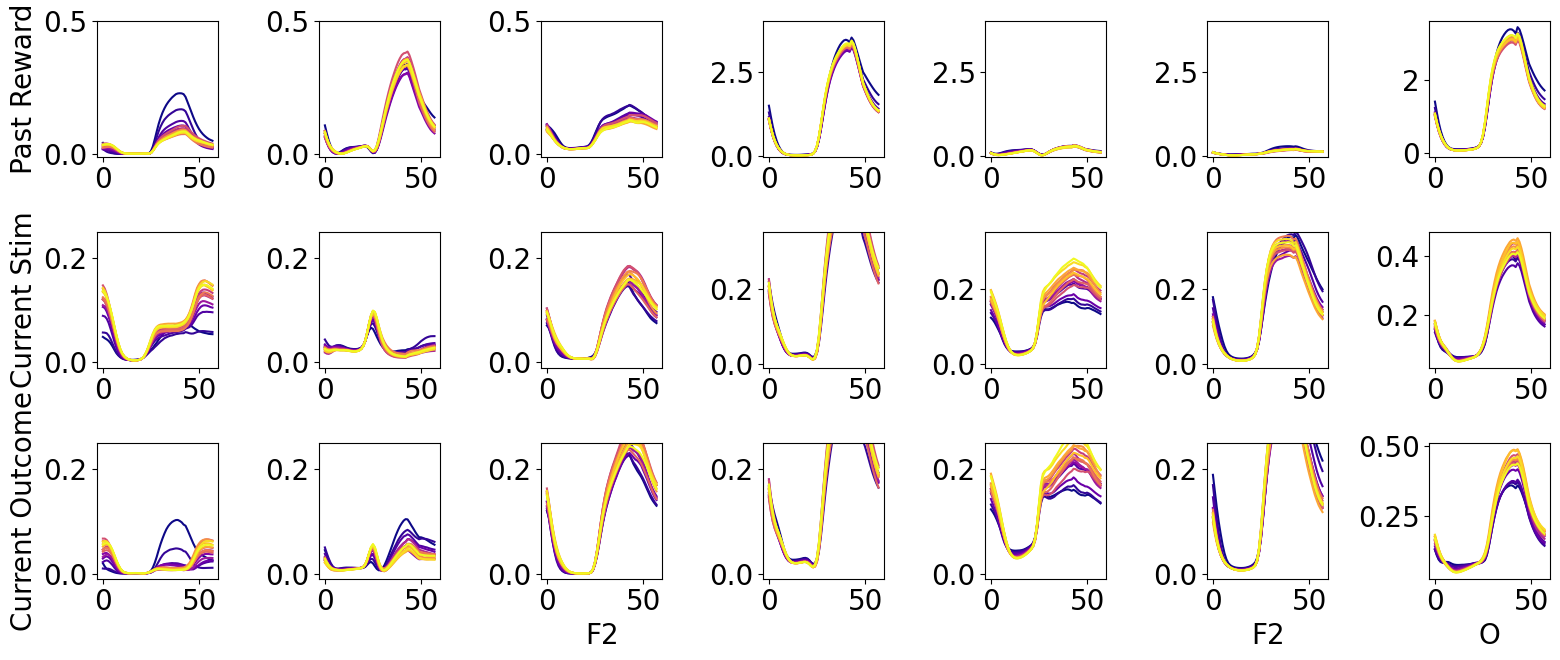

In [186]:
num_blocks = 16
colors = plt.cm.plasma(np.linspace(0,1,num_blocks))

centered_hs = all_saved_states['hs'][:,:,:,output_weight_inds]
total_var = (centered_hs**2).sum(-1)

fig, axes = plt.subplots(3,7, figsize=(16, 7)) # three rows for past, curr stim, curr outcome

'''past reward'''
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[1]['encoding_axes']['tr'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[0,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[0,ft_idx].set_ylim([-0.01, 0.5])

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[1]['encoding_axes']['tr'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[0,3+conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[0,3+conj_idx].set_ylim([-0.01, 4])

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_prev[1]['encoding_axes']['trspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[0,6].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")
# axes[0,6].set_ylim([-0.01, 1])
axes[0,0].set_ylabel('Past Reward')

    
'''curr stim''' 
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[1]['encoding_axes']['t'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[1,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[1,ft_idx].set_ylim([-0.01, 0.25])

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[1]['encoding_axes']['t'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[1,3+conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[1,3+conj_idx].set_ylim([-0.01, 0.35])

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_stim[1]['encoding_axes']['tspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[1,6].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")

axes[1,0].set_ylabel('Current Stim')
    
'''curr outcome''' 
for ft_idx, ft_key in enumerate(['s', 'p', 'c']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[1]['encoding_axes']['t'+ft_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[2,ft_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"F{ft_idx}")
    axes[2,ft_idx].set_ylim([-0.01, 0.25])
axes[2,ft_idx].set_xlabel(f"F{ft_idx}")

for conj_idx, conj_key in enumerate(['pc','sc','sp']):
    avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[1]['encoding_axes']['t'+conj_key])**2).sum(-1)
    for trial_idx in range(num_blocks):
        trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                                   (trial_idx+1)*(args['test_N_s']//num_blocks))
        axes[2,3+conj_idx].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"C{conj_idx}")
    axes[2,3+conj_idx].set_ylim([-0.01, 0.25])
axes[2,3+conj_idx].set_xlabel(f"F{conj_idx}")

avg_exp_var = ((centered_hs.mean(2)@dpca_results_by_curr_outcome[1]['encoding_axes']['tspc'])**2).sum(-1)
for trial_idx in range(num_blocks):
    trials_to_plot = np.arange(trial_idx*(args['test_N_s']//num_blocks), \
                               (trial_idx+1)*(args['test_N_s']//num_blocks))
    axes[2,6].plot(avg_exp_var[trials_to_plot].mean(0), color=colors[trial_idx], label=f"O")
axes[2,6].set_xlabel("O")    

axes[2,0].set_ylabel('Current Outcome')


# plt.plot(avg_corr/27, label='O')
# plt.legend(ncol=1)
# plt.ylabel('Cosine similarity')
# plt.xlabel('Timesteps')
# plt.yticks(np.linspace(-0.2, 1.0, 7))
# plt.title('Choice encoding of input area driven by input connectivity')
plt.tight_layout()

# Candidate mechanisms of modulating attention
$$
\begin{align*}
    \frac{\partial \text{logit}_s}{\partial r_{s-1}}=\underbrace{B diag(\sigma'_{ })}_{\text{1.gain modulation}} 
    \underbrace{(I-W_sdiag(\sigma'_{}))^{-1}}_{\text{2.recurrence}}
    \underbrace{(A\odot(h_{s-1}h_{s-1}^{\top}))h_s}_{\text{3.routing through alignment}}
\end{align*}
$$
1. Gain modulation
2. Amplification through recurrence
2. Dynamic routing through alignment

### activity of rnn at the end of choice trials and choice presentation approximately converges, so we can simplify with implicit function

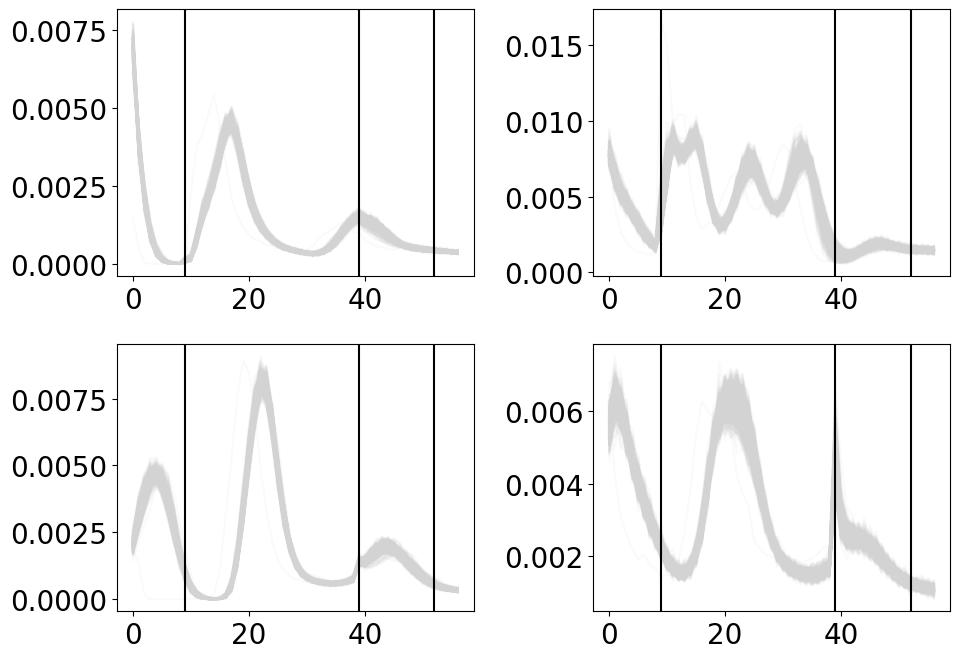

In [37]:
fig, axes = plt.subplots(2, 2)

delta_h = ((all_saved_states['hs'][:,1:,:,:]-all_saved_states['hs'][:,:-1,:,:])**2).mean(2) 
# shape = trial X time X units

axes[0,0].plot(delta_h[...,input_weight_inds[:64]].mean(-1).T, alpha=0.1, color='lightgrey');
axes[0,1].plot(delta_h[...,input_weight_inds[64:]].mean(-1).T, alpha=0.1, color='lightgrey');
axes[1,0].plot(delta_h[...,output_weight_inds[:64]].mean(-1).T, alpha=0.1, color='lightgrey');
axes[1,1].plot(delta_h[...,output_weight_inds[64:]].mean(-1).T, alpha=0.1, color='lightgrey');

for i in range(2):
    for j in range(2):
        axes[i,j].axvline(np.where(task_mdprl.T_stim)[0][0]-1, color='black')
        axes[i,j].axvline(np.where(task_mdprl.T_ch)[0][0]-1, color='black')
        axes[i,j].axvline(np.where(task_mdprl.T_rwd)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][-1], color='black')

plt.tight_layout()


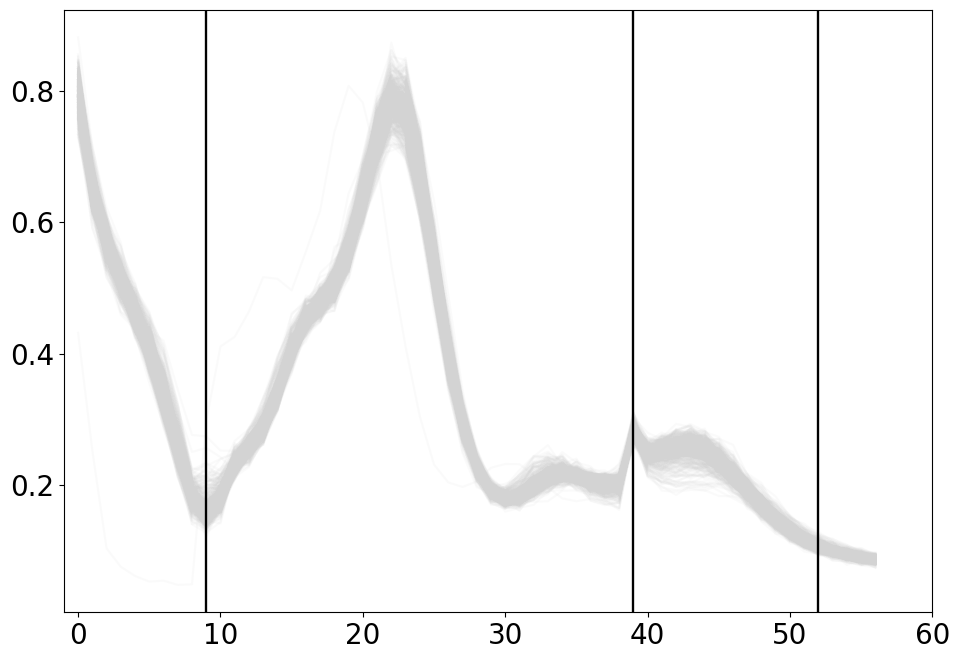

In [38]:
plt.plot(delta_h.sum(-1).T, alpha=0.1, color='lightgrey');

for i in range(2):
    for j in range(2):
        plt.axvline(np.where(task_mdprl.T_stim)[0][0]-1, color='black')
        plt.axvline(np.where(task_mdprl.T_ch)[0][0]-1, color='black')
        plt.axvline(np.where(task_mdprl.T_rwd)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][0]-1, color='black')
#         axes[i,j].axvline(np.where(task_mdprl.T_mask)[0][-1], color='black')

plt.xlim([-1, 60])

plt.tight_layout()

In [39]:
# get the gains and average firing rates necessary for further calculations

h_avg_ch = all_saved_states['hs'][:,task_mdprl.T_mask,:,:][:,-1,...] # activity at steady state
h_avg_lrn = all_saved_states['hs'][:,task_mdprl.T_rwd,:,:].mean(1) # activity at steady state
h_gain = ((h_avg_ch>0).float()*(1-h_avg_ch**2)) # gain at steady state



In [40]:
print(h_avg_ch.shape, h_avg_lrn.shape, h_gain.shape)
print(model.h2o.effective_weight().detach().shape, all_saved_states['whs_final'].shape)

torch.Size([432, 92, 160]) torch.Size([432, 92, 160]) torch.Size([432, 92, 160])
torch.Size([27, 64]) torch.Size([432, 1, 92, 160, 160])


In [41]:
h2o_gain_mod = []
whs_gain_mod = []
delta_ws = []

for idx_sess in tqdm.tqdm(range(all_saved_states['hs'].shape[2])):
    model = all_models[all_saved_states['model_assignment'][idx_sess]]
    # gain modulated readout
    h2o_gain_mod.append(
        h_gain[:,idx_sess:idx_sess+1,output_weight_inds[:64]]*\
        model.h2o.effective_weight().detach()[None,...])
    # gain modulated recurrent weights
    whs_gain_mod.append(
        h_gain[:,idx_sess:idx_sess+1,:]*\
        model.rnn.h2h.effective_weight(all_saved_states['whs_final'][:,0,idx_sess,...]))
    # weight change 
    delta_ws.append((model.rnn.kappa_rec.squeeze().abs().detach()*model.rnn.h2h.mask)[None]*\
                (h_avg_lrn[:,idx_sess][...,None]*h_avg_lrn[:,idx_sess][...,None,:]))

h2o_gain_mod = torch.stack(h2o_gain_mod, axis=1)
whs_gain_mod = torch.stack(whs_gain_mod, axis=1)
delta_ws = torch.stack(delta_ws, axis=1)


100%|██████████| 92/92 [00:05<00:00, 15.78it/s]


In [42]:
print(h_avg_ch.shape, h_avg_lrn.shape, h_gain.shape)
print(h2o_gain_mod.shape, whs_gain_mod.shape, delta_ws.shape)

torch.Size([432, 92, 160]) torch.Size([432, 92, 160]) torch.Size([432, 92, 160])
torch.Size([432, 92, 27, 64]) torch.Size([432, 92, 160, 160]) torch.Size([432, 92, 160, 160])


In [43]:
h2o_gain_mod_avail = torch.empty(431, 92, 64)

for idx_trial in range(1,432):
    for idx_sess in range(92):
        curr_stimuli = all_saved_states['stimuli'][idx_trial, 0, idx_sess]
        h2o_gain_mod_avail[idx_trial-1, idx_sess] = \
            h2o_gain_mod[idx_trial,idx_sess,curr_stimuli[1]]-h2o_gain_mod[idx_trial,idx_sess,curr_stimuli[0]]


### correlation between analytical gradient and approximation

In [44]:
# calculate the numerically stable inverse of (I-Jac)
# inv_jac_times_hebb = torch.linalg.lstsq(
#             torch.eye(args['hidden_size']*args['num_areas'])[None,None]-\
#             whs_gain_mod[1:], (delta_ws[:-1]@h_avg_ch[1:,...,None]), 
#                 rcond=0.01, driver='gelsd')

In [46]:
# invert I-jacobian 
# CAUTION TAKES LOOOONG TIME TO RUN 
# inv_jac = torch.linalg.pinv(torch.eye(args['hidden_size']*args['num_areas'])[None,None]-whs_gain_mod,
#                             atol=0.001, rtol=0.01)


inv_jac = torch.zeros_like(whs_gain_mod)

for idx_trial in tqdm.tqdm(range(432)):
    for idx_sess in range(92):
        try:
#             print(torch.linalg.svd(torch.eye(args['hidden_size']*args['num_areas'])-whs_gain_mod[idx_trial, idx_sess]).S.max(),
#                   torch.linalg.svd(torch.eye(args['hidden_size']*args['num_areas'])-whs_gain_mod[idx_trial, idx_sess]).S.min())
            inv_jac[idx_trial, idx_sess] = \
                torch.linalg.pinv(torch.eye(args['hidden_size']*args['num_areas'])-whs_gain_mod[idx_trial, idx_sess], 
                                  rtol=0.01, atol=0.001)
        except:
            print(f"SVD failed at {idx_trial, idx_sess}")
            inv_jac[idx_trial, idx_sess] = torch.eye(args['hidden_size']*args['num_areas'])

100%|██████████| 432/432 [01:37<00:00,  4.41it/s]


In [47]:
inv_jac_times_hebb = inv_jac[1:]@(delta_ws[:-1]@h_avg_ch[1:,...,None])

In [48]:
# calculate approximate sensitivity
approx_sensitivity = h2o_gain_mod_avail[...,None,:]@inv_jac_times_hebb[...,output_weight_inds[:64],:]

Figure saved at plots/exp/test0/true_approx_sensitivity_corr.pdf


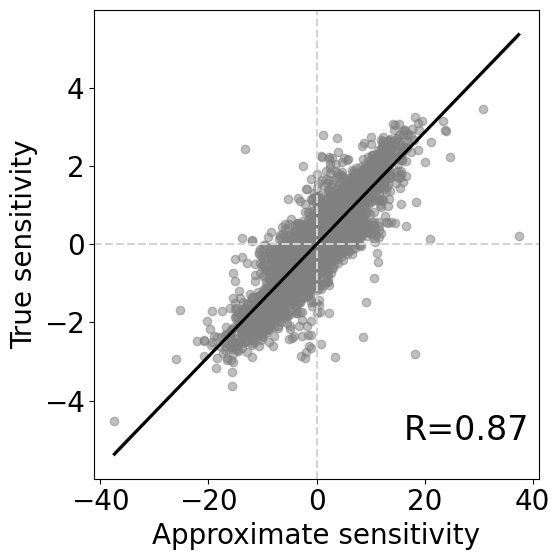

In [49]:
# plot scatter 
fig, ax = plt.subplots(figsize=(6,6))
ax.axhline(0, color='lightgrey', linestyle='--')
ax.axvline(0, color='lightgrey', linestyle='--')
sns.regplot(x=approx_sensitivity.squeeze().flatten().numpy(), 
              y=all_saved_states['sensitivity'][1:].squeeze().flatten().numpy(),
              ax=ax, scatter_kws={'color':'grey', 'alpha':0.5}, line_kws={'color':'k'})
sensitivity_approx_corr = stats.pearsonr(approx_sensitivity.squeeze().flatten(), all_saved_states['sensitivity'][1:].squeeze().flatten())
ax.set_xlabel('Approximate sensitivity')
ax.set_ylabel('True sensitivity')
ax.text(ax.get_xlim()[1]-25, ax.get_ylim()[0]+1, 
        f"R={np.round(sensitivity_approx_corr.statistic, 2)}", 
        fontsize=24)
fig.tight_layout()

with PdfPages(f'plots/{plot_save_dir}/true_approx_sensitivity_corr.pdf') as pdf:
    pdf.savefig(fig)
    print(f'Figure saved at plots/{args["exp_dir"]}/true_approx_sensitivity_corr.pdf')
          

## Calculate gain modulation of readout
$$ 
B diag(\sigma')
$$

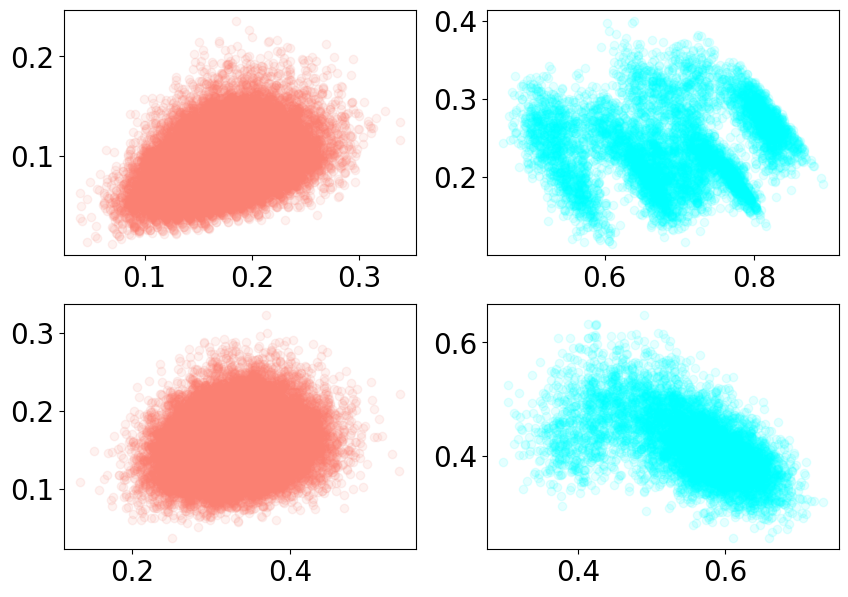

In [50]:
fig, axes = plt.subplots(2, 2)



axes[0,0].scatter(h_avg_ch[:,:,input_weight_inds[:64]].mean(1), h_gain[:,:,input_weight_inds[:64]].mean(1), 
                  alpha=0.1, c='salmon')
# axes[0,0].imshow(h_gain[:,input_weight_inds[:64]].T, aspect='auto')
    
axes[0,1].scatter(h_avg_ch[:,:,input_weight_inds[64:]].mean(1), h_gain[:,:,input_weight_inds[64:]].mean(1), 
                  alpha=0.1, c='cyan')
# axes[0,1].imshow(h_gain[:,input_weight_inds[64:]].T, aspect='auto')
    
axes[1,0].scatter(h_avg_ch[:,:,output_weight_inds[:64]].mean(1), h_gain[:,:,output_weight_inds[:64]].mean(1), 
                  alpha=0.1, c='salmon')
# axes[1,0].imshow(h_gain[:,output_weight_inds[:64]].T, aspect='auto')

axes[1,1].scatter(h_avg_ch[:,:,output_weight_inds[64:]].mean(1), h_gain[:,:,output_weight_inds[64:]].mean(1), 
                  alpha=0.1, c='cyan')
# axes[1,1].imshow(h_gain[:,output_weight_inds[64:]].T, aspect='auto')


In [51]:
h2o_gain_mod_variance_ratio = np.empty((432, 92, 7))

for idx_trial in tqdm.tqdm(range(args['test_N_s'])):
    for idx_sess in range(92):
        dpca_out_gain_mod = dPCA.dPCA('spc', n_components=n_components_for_dpca, regularizer=None)
        curr_h2o_gain_mod = h2o_gain_mod[idx_trial,idx_sess].numpy().T
        curr_h2o_gain_mod = curr_h2o_gain_mod[:,task_mdprl.test_sensory2stim_idx[idx_sess]]
        curr_h2o_gain_mod = curr_h2o_gain_mod.reshape((E_SIZE,3,3,3))
        low_output = dpca_out_gain_mod.fit_transform(curr_h2o_gain_mod)
        for idx_k, k in enumerate(['s','p','c','pc','sc','sp','spc']):
            h2o_gain_mod_variance_ratio[idx_trial, idx_sess, idx_k] = \
                    np.sum(dpca_out_gain_mod.explained_variance_ratio_[k])

            

  0%|          | 0/432 [00:00<?, ?it/s]/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:980: RuntimeWarning: divide by zero encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]
/dartfs-hpc/rc/home/d/f005d7d/attn-rnn/Attn-WM-RNN/rnn/dPCA/dPCA.py:980: RuntimeWarning: invalid value encountered in divide
  return [1 - np.sum((Xr - P[:,k:k+1]@(D[:,k:k+1].T@Xr))**2, -1) / (unitwise_variance) for k in range(D.shape[1])]
100%|██████████| 432/432 [02:11<00:00,  3.29it/s]


Figure saved at plots/exp/test0/output_gain_mod_variance.pdf


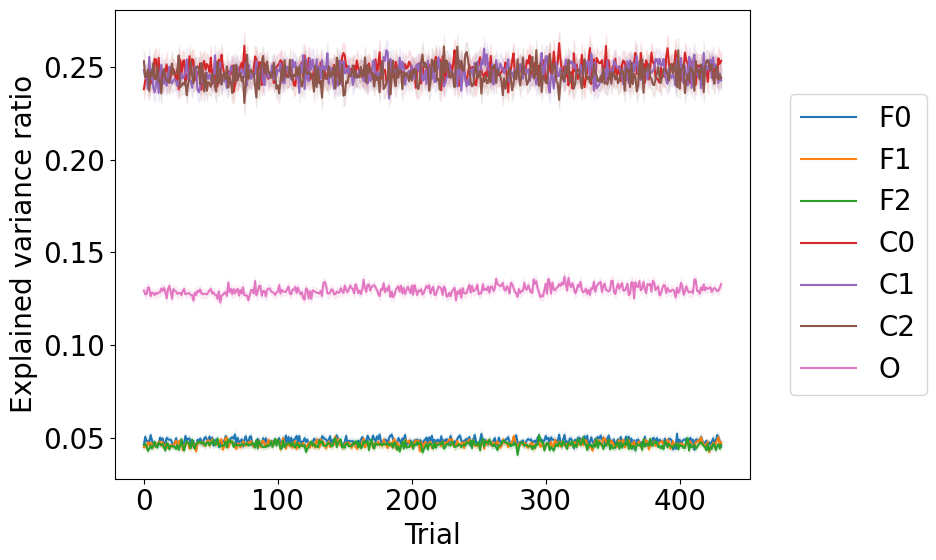

In [52]:
dim_labels = ["F0", "F1", "F2", "C0", "C1", "C2", "O"]

fig, ax = plt.subplots(figsize=(8,6))

for idx_k, k in enumerate(['s','p','c','pc','sc','sp','spc']):
#     ax.plot(-10, h2o_variance_ratio[:,idx_k].mean(0), marker='>', 
#             markeredgecolor='k', markerfacecolor=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,0.5]),
#            markersize=15)
#     delta_h2o_gain_mod_variance_ratio = \
#         h2o_gain_mod_variance_ratio[1:]-h2o_gain_mod_variance_ratio[:-1]
    plot_mean_and_std(ax=ax,
                      m=h2o_gain_mod_variance_ratio[...,idx_k].mean(1), 
                      sd=h2o_gain_mod_variance_ratio[...,idx_k].std(1)/np.sqrt(92),
                      label=dim_labels[idx_k], 
                      color=mpl.colormaps['tab10'](idx_k)*np.array([1,1,1,0.]))
ax.set_xlabel('Trial')
ax.set_ylabel('Explained variance ratio')
# ax.set_title('No effect of gain modulation on readout')
fig.tight_layout()
lgd = ax.legend(bbox_to_anchor=(1.3, 0.5), loc='center right')


with PdfPages(f'plots/{plot_save_dir}/output_gain_mod_variance.pdf') as pdf:
    pdf.savefig(fig, bbox_extra_artists=(lgd,), bbox_inches='tight')
    print(f'Figure saved at plots/{args["exp_dir"]}/output_gain_mod_variance.pdf')


## Recurrence through plastic weights
$$
(I-W_sdiag(\sigma'_{}))^{-1} = \sum_{k=0}^T (W_sdiag(\sigma'_{}))^k \approx W_sdiag(\sigma')
$$

In [210]:
rec_intra_gain_mod = []
rec_inter_ff_gain_mod = []
rec_inter_fb_gain_mod = []

for i in range(NUM_AREAS):
    rec_intra_gain_mod.append(inv_jac[...,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                             list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE)),:]
                                          [...,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                             list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])


for i in range(NUM_AREAS-1):
    rec_inter_ff_gain_mod.append(inv_jac[...,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                                list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE)),:]
                                            [...,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE))])
    rec_inter_fb_gain_mod.append(inv_jac[...,list(range(i*E_SIZE, (i+1)*E_SIZE))+\
                                                list(range(2*E_SIZE+i*I_SIZE, 2*E_SIZE+(i+1)*I_SIZE)),:]
                                            [...,list(range((i+1)*E_SIZE, (i+2)*E_SIZE))+\
                                                list(range(2*E_SIZE+(i+1)*I_SIZE, 2*E_SIZE+(i+2)*I_SIZE))])

In [211]:
print(rec_intra_gain_mod[0].shape, rec_intra_gain_mod[1].shape,
      rec_inter_ff_gain_mod[0].shape, rec_inter_fb_gain_mod[0].shape)

torch.Size([432, 92, 80, 80]) torch.Size([432, 92, 80, 80]) torch.Size([432, 92, 80, 80]) torch.Size([432, 92, 80, 80])


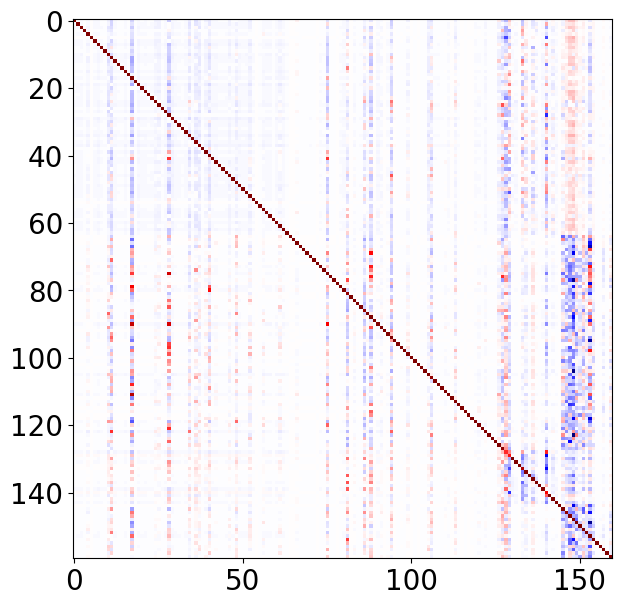

In [221]:
plt.imshow(inv_jac[399,42], vmin=-1, vmax=1, cmap='seismic')

In [222]:
def get_all_dpca_axes_by_dim_order(dim_order_reverse, curr_model_dpca,
                                   ft_keys=['s','p','c'], conj_keys=['pc','sc','sp'], obj_key='spc'):
    permutted_key_order = [ft_keys[i] for i in dim_order_reverse] + \
                          [conj_keys[i] for i in dim_order_reverse] + \
                          [obj_key]
    
    return np.concatenate([curr_model_dpca.P[k] for k in permutted_key_order], axis=1)
    
    

In [223]:

input_rec_overlap_gain_mod = np.empty((432, 92, 26, 26))

for idx_sess in tqdm.tqdm(range(92)):
    all_dpca_axes_in = get_all_dpca_axes_by_dim_order(task_mdprl.test_stim_dim_order[idx_sess], \
                                                all_model_dpca_in[all_saved_states['model_assignment'][idx_sess]])
    for idx_trial in range(432):
        curr_input_rec_overlap_gain_mod = all_dpca_axes_in.T@\
                                     rec_intra_gain_mod[0][idx_trial, idx_sess].detach().numpy()@\
                                     all_dpca_axes_in
        input_rec_overlap_gain_mod[idx_trial, idx_sess] = curr_input_rec_overlap_gain_mod

100%|██████████| 92/92 [00:01<00:00, 69.79it/s]


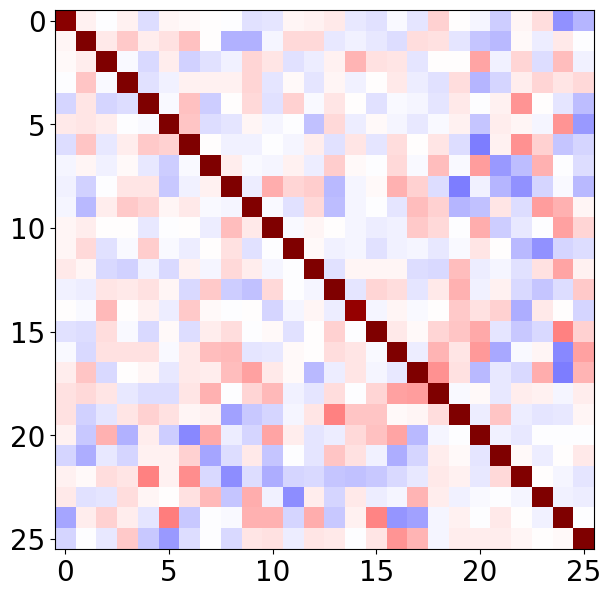

In [235]:
plt.imshow(input_rec_overlap_gain_mod[430,23], vmin=-1, vmax=1, cmap='seismic')

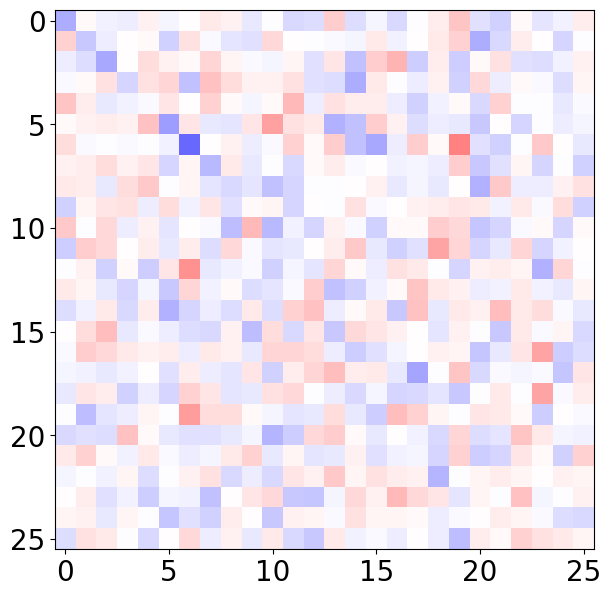

In [306]:
plt.imshow(input_rec_overlap_gain_mod[100].mean(0)-input_rec_overlap_gain_mod[0].mean(0), 
           vmin=-0.1, vmax=0.1, cmap='seismic');

In [259]:
output_rec_overlap_gain_mod = np.empty((432, 92, 26, 26))

for idx_sess in tqdm.tqdm(range(92)):
    all_dpca_axes_out = get_all_dpca_axes_by_dim_order(task_mdprl.test_stim_dim_order_reverse[idx_sess], \
                                        all_model_dpca_out[all_saved_states['model_assignment'][idx_sess]])
    for idx_trial in range(432):
        curr_output_rec_overlap_gain_mod = all_dpca_axes_out.T@\
                                     rec_intra_gain_mod[1][idx_trial, idx_sess].detach().numpy()@\
                                     all_dpca_axes_out
        output_rec_overlap_gain_mod[idx_trial, idx_sess] = curr_output_rec_overlap_gain_mod

100%|██████████| 92/92 [00:01<00:00, 75.61it/s]


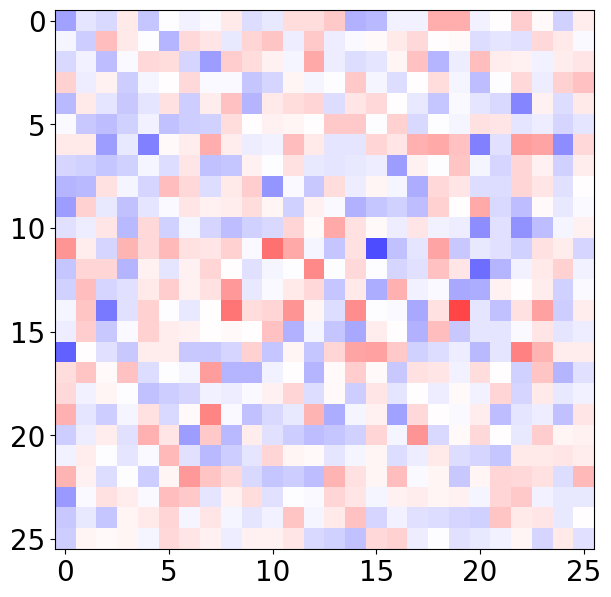

In [309]:
plt.imshow(output_rec_overlap_gain_mod[21].mean(0)-output_rec_overlap_gain_mod[0].mean(0), 
           vmin=-0.1, vmax=0.1, cmap='seismic');


In [288]:
rec_ff_overlap_gain_mod = np.empty((432, 92, 26, 26))

for idx_sess in tqdm.tqdm(range(92)):
    all_dpca_axes_in = get_all_dpca_axes_by_dim_order(task_mdprl.test_stim_dim_order_reverse[idx_sess], \
                                        all_model_dpca_in[all_saved_states['model_assignment'][idx_sess]])
    all_dpca_axes_out = get_all_dpca_axes_by_dim_order(task_mdprl.test_stim_dim_order_reverse[idx_sess], \
                                        all_model_dpca_out[all_saved_states['model_assignment'][idx_sess]])
    for idx_trial in range(432):
        curr_rec_ff_overlap_gain_mod = all_dpca_axes_out.T@\
                                     rec_inter_ff_gain_mod[0][idx_trial, idx_sess].detach().numpy()@\
                                     all_dpca_axes_in
        rec_ff_overlap_gain_mod[idx_trial, idx_sess] = curr_rec_ff_overlap_gain_mod

100%|██████████| 92/92 [00:01<00:00, 51.88it/s]


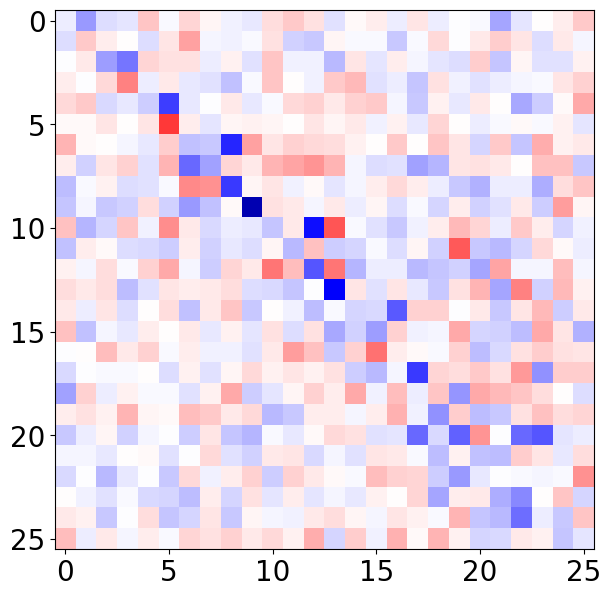

In [290]:
plt.imshow(rec_ff_overlap_gain_mod[0].mean(0), vmin=-0.2, vmax=0.2, cmap='seismic');


In [265]:
rec_fb_overlap_gain_mod = np.empty((432, 92, 26, 26))

for idx_sess in tqdm.tqdm(range(92)):
    all_dpca_axes_in = get_all_dpca_axes_by_dim_order(task_mdprl.test_stim_dim_order_reverse[idx_sess], \
                                        all_model_dpca_in[all_saved_states['model_assignment'][idx_sess]])
    all_dpca_axes_out = get_all_dpca_axes_by_dim_order(task_mdprl.test_stim_dim_order_reverse[idx_sess], \
                                        all_model_dpca_out[all_saved_states['model_assignment'][idx_sess]])
    for idx_trial in range(432):
        curr_rec_fb_overlap_gain_mod = all_dpca_axes_in.T@\
                                     rec_inter_fb_gain_mod[0][idx_trial, idx_sess].detach().numpy()@\
                                     all_dpca_axes_out
        rec_fb_overlap_gain_mod[idx_trial, idx_sess] = curr_rec_fb_overlap_gain_mod

100%|██████████| 92/92 [00:02<00:00, 41.06it/s]


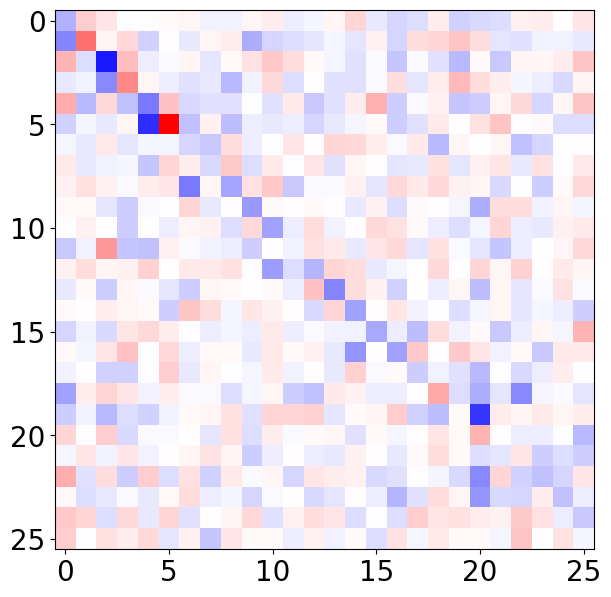

In [293]:
plt.imshow(rec_fb_overlap_gain_mod[3].mean(0), vmin=-0.1, vmax=0.1, cmap='seismic');

### Routing through alignment
$$
(A\odot(h_{s-1}h_{s-1}^{\top}))h_s
$$

In [208]:
h_avg_ch.shape

torch.Size([432, 92, 160])

In [ ]:
for idx_sess in tqdm.tqdm(range(92)):
    all_dpca_axes_in = get_all_dpca_axes_by_dim_order(task_mdprl.test_stim_dim_order_reverse[idx_sess], \
                                        all_model_dpca_in[all_saved_states['model_assignment'][idx_sess]])
    all_dpca_axes_out = get_all_dpca_axes_by_dim_order(task_mdprl.test_stim_dim_order_reverse[idx_sess], \
                                        all_model_dpca_out[all_saved_states['model_assignment'][idx_sess]])
    for idx_trial in range(432):
        curr_rec_fb_overlap_gain_mod = all_dpca_axes_in.T@\
                                     rec_inter_fb_gain_mod[0][idx_trial, idx_sess].detach().numpy()@\
                                     all_dpca_axes_out
        rec_fb_overlap_gain_mod[idx_trial, idx_sess] = curr_rec_fb_overlap_gain_mod
        
        

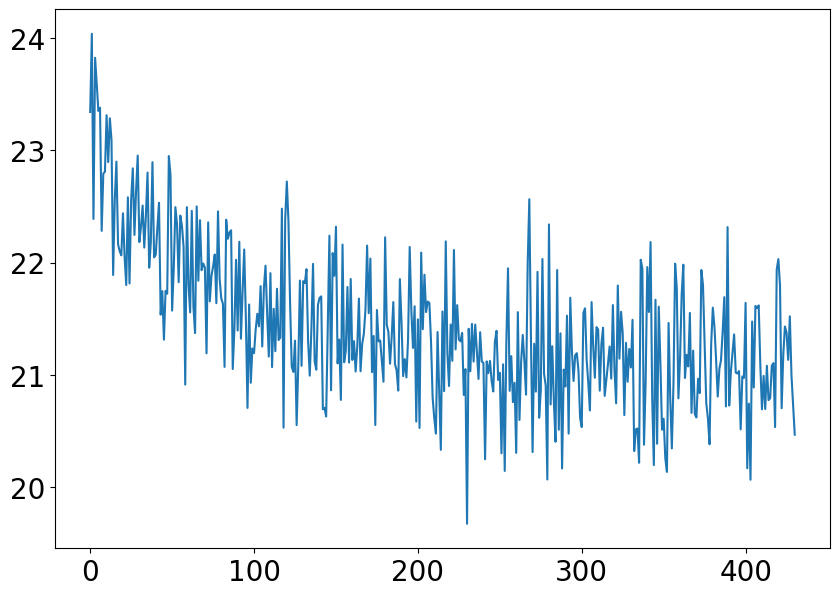

In [222]:
plt.plot((h_avg_ch[1:]*h_avg_lrn[:-1]).sum(-1).mean(1))

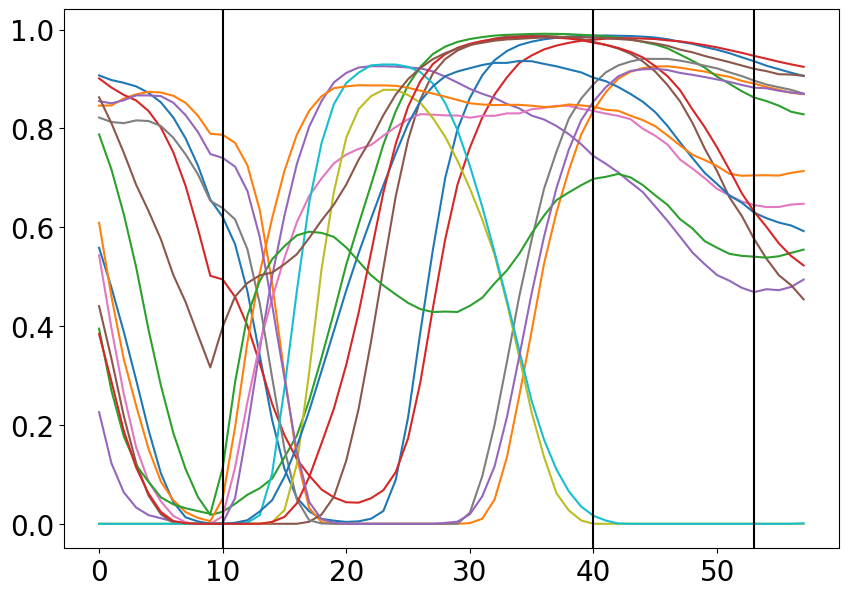

In [45]:
plt.plot(all_saved_states['hs'][40,:,:,128:144].mean(1));
plt.axvline(np.where(task_mdprl.T_stim)[0][0], color='black')
plt.axvline(np.where(task_mdprl.T_ch)[0][0], color='black')
plt.axvline(np.where(task_mdprl.T_rwd)[0][0], color='black')
# plt.colorbar()

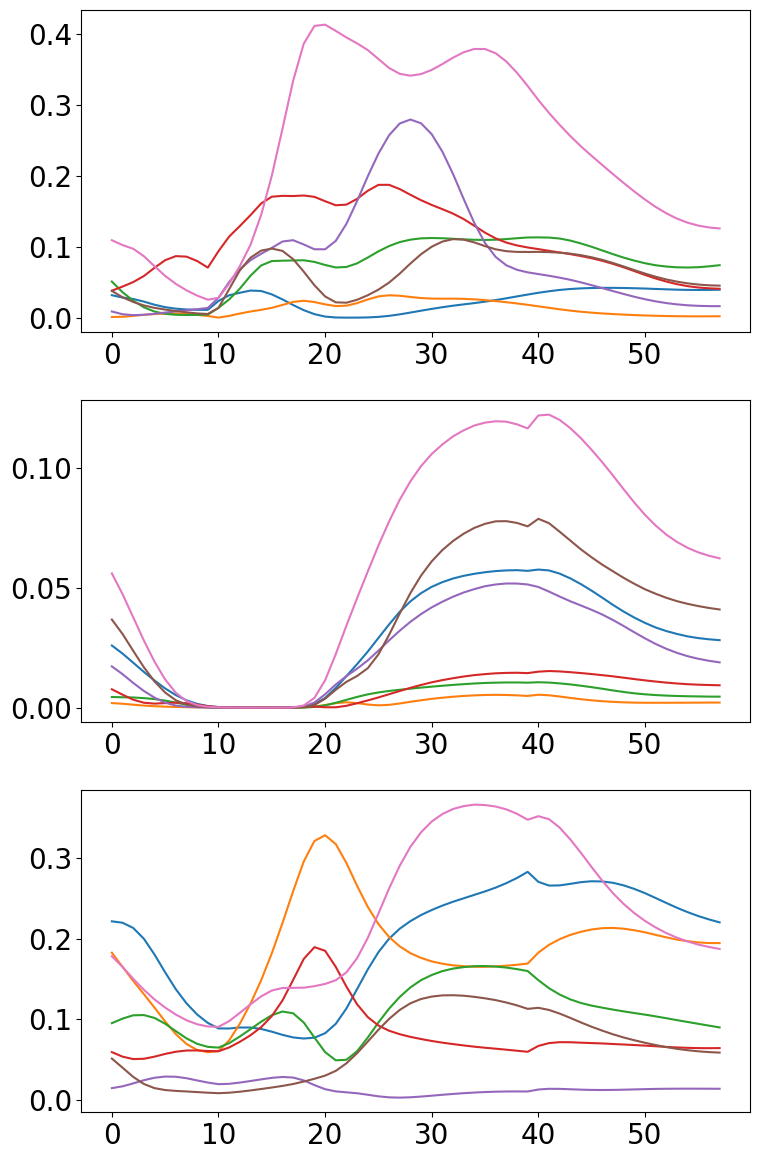

In [46]:
# ttt=np.arange(0, 80)

fig, axes = plt.subplots(3,1, figsize=(8, 12))
for k_idx, k in enumerate(['s', 'p', 'c', 'pc', 'sc', 'sp', 'spc']):
    axes[0].plot(((all_saved_states['hs'][:][:,:,:,input_weight_inds].mean((0,2))@dpca_in.P[k])**2).sum(-1));
    axes[1].plot(((all_saved_states['hs'][:][:,:,:,output_weight_inds].mean((0,2))@dpca_out.P[k])**2).sum(-1));
    axes[2].plot(((all_saved_states['hs'][:][:,:,:,output_weight_inds].mean((0,2))@dpca_ch.P[k])**2).sum(-1));
    
fig.tight_layout()

# print(obj_to_ft_conj(all_saved_states['choices'][ttt,:,iii], task_mdprl))
# print(obj_to_ft_conj(all_saved_states['foregone'][ttt,:,iii], task_mdprl))
# print(all_saved_states['rewards'][ttt,:,iii])
# print(obj_to_ft_conj(all_saved_states['stimuli'][ttt,:,iii], task_mdprl))
# print(obj_to_value_est(all_saved_states['stimuli'][ttt,:,iii], task_mdprl))

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 3.000e+00, 2.000e+00,
        4.000e+00, 6.000e+00, 5.000e+00, 1.000e+01, 1.500e+01, 1.500e+01,
        2.200e+01, 2.600e+01, 3.600e+01, 2.700e+01, 4.600e+01, 4.200e+01,
        3.800e+01, 6.100e+01, 7.900e+01, 8.100e+01, 9.100e+01, 7.300e+01,
        8.600e+01, 9.400e+01, 9.400e+01, 8.500e+01, 1.210e+02, 1.320e+02,
        1.890e+02, 2.780e+02, 4.540e+02, 7.420e+02, 1.373e+03, 2.226e+03,
        3.669e+03, 5.439e+03, 6.650e+03, 5.855e+03, 4.159e+03, 2.673e+03,
        1.542e+03, 8.730e+02, 5.090e+02, 3.120e+02, 1.970e+02, 1.430e+02,
        1.160e+02, 1.030e+02, 9.000e+01, 8.700e+01, 7.900e+01, 7.300e+01,
        8.000e+01, 7.700e+01, 6.800e+01, 6.200e+01, 5.900e+01, 6.400e+01,
        4.800e+01, 2.500e+01, 2.900e+01, 2.100e+01, 1.500e+01, 2.000e+01,
        6.000e+00, 1.000e+01, 6.000e+0

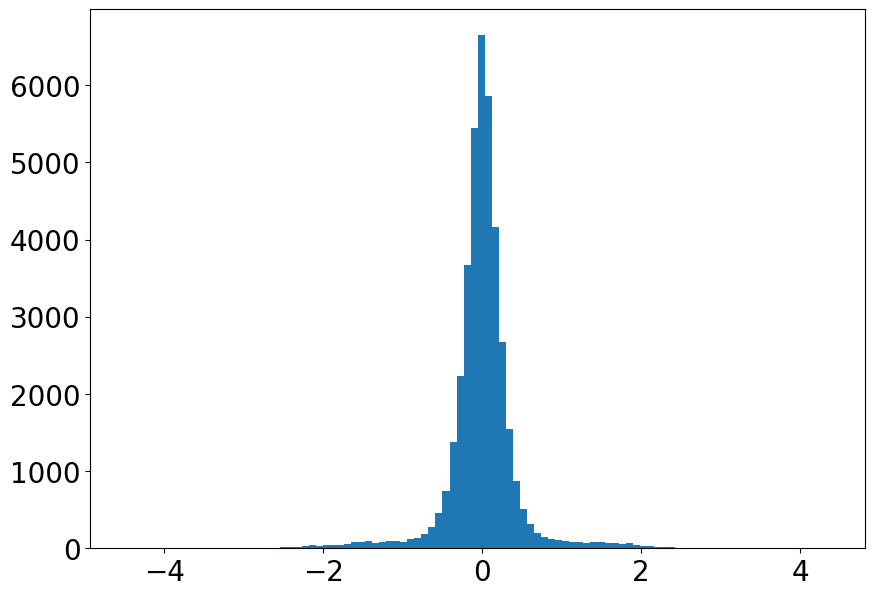

In [13]:
plt.hist(all_saved_states['sensitivity'].flatten(), bins=100)